Starting from a 
* pre-trained model with a 
* pre-trained tokenizer

we perform finetuning on a negation task

In [1]:
%load_ext autoreload
%autoreload 2

import os 
import numpy as np
import random
from tqdm import tqdm

from torch.nn import CrossEntropyLoss
from torch.utils.data import Dataset, DataLoader
from torch import device, cuda, version

import apex

import dcc_splitter as splitter
import ner_training as trainer
import pandas as pd

import seaborn
import matplotlib.pyplot as plt

from collections import namedtuple

from transformers import AutoTokenizer, RobertaTokenizer, AutoModelForTokenClassification

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [3]:
device = device("cuda:0") if cuda.is_available() else device("cpu")

/home/koekiemonster/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:115.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
device

device(type='cpu')

In [5]:
dcc_dir = None
output_dir = None
skip_file = None
n_splits = 10
random_state = None
base_folder = "/media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels"
output_folder = "fine_tuned_token_classification"
mod_name = "robbert-v2-dutch-base" # "robbert-v2-dutch-base" # belabBERT_115k # bert-base-dutch
 

args = namedtuple
args.task = "negation" # experiencer, temporality
args.model_path = os.path.join(base_folder, mod_name)
args.model_type = "roberta" # bertje
args.output_dir = os.path.join(base_folder, output_folder)
args.num_epochs = 4
args.eval_steps = 10 
args.lr = 5e-5
args.batch_size=16
args.gradient_accumulation_steps=1
args.block_size = 64
args.save_model=False
args.bio=True
args.do_eval=True
args.do_write=False
args.bootstrap=False
args.do_print_class_report=False

random.seed(77)

In [6]:
# dcc-splitter for folds
dcc_splitter = splitter.DCCSplitter(dcc_dir, output_dir, skip_file, n_splits, random_state, write_to_file=False)
splits = dcc_splitter.split()

In [7]:
# load NER DCC set
dcc = pd.read_csv("../data/RobBERT/DCC.tsv", 
                  sep="\t", 
                  skip_blank_lines=True, 
                  engine="python", 
                  encoding="utf-8",
                  on_bad_lines="warn", 
                  keep_default_na=False)

Skipping line 13610: field larger than field limit (131072)
Skipping line 20017: field larger than field limit (131072)
Skipping line 33436: field larger than field limit (131072)
Skipping line 39932: field larger than field limit (131072)
Skipping line 48840: field larger than field limit (131072)
Skipping line 67717: field larger than field limit (131072)
Skipping line 70612: field larger than field limit (131072)
Skipping line 75877: field larger than field limit (131072)
Skipping line 98174: field larger than field limit (131072)


In [8]:
Texts = dcc.groupby('Id').Word.apply(lambda x: " ".join(x))

In [9]:
dcc.loc[dcc.Id=='GP2218'][['Word', 'BIO', 'Negation', 'Experiencer', 'Temporality']].values

array([['Trombofilie', 'B', 'NotNegated', 'Patient', 'Recent'],
       ['O', 'O', 'O', 'O', 'O'],
       ['?', 'O', 'O', 'O', 'O'],
       ['ACUUT', 'O', 'O', 'O', 'O'],
       ['ANTERO', 'O', 'O', 'O', 'O'],
       ['Car', 'O', 'O', 'O', 'O'],
       ['[O]', 'O', 'O', 'O', 'O'],
       ['SEPTAAL', 'O', 'O', 'O', 'O'],
       ['-', 'O', 'O', 'O', 'O'],
       ['ANTEROLATERAAL', 'O', 'O', 'O', 'O'],
       ['INFARCT', 'B', 'NotNegated', 'Patient', 'Recent'],
       ['.', 'O', 'O', 'O', 'O'],
       ['ER', 'O', 'O', 'O', 'O'],
       ['WERD', 'O', 'O', 'O', 'O'],
       ['EEN', 'O', 'O', 'O', 'O'],
       ['STENT', 'O', 'O', 'O', 'O'],
       ['GE', 'O', 'O', 'O', 'O'],
       ['Car', 'O', 'O', 'O', 'O'],
       ['[O]', 'O', 'O', 'O', 'O'],
       ['IMPLANTEERD', 'O', 'O', 'O', 'O'],
       ['IN', 'O', 'O', 'O', 'O'],
       ['DE', 'O', 'O', 'O', 'O'],
       ['LAD', 'O', 'O', 'O', 'O'],
       ['.', 'O', 'O', 'O', 'O'],
       ['NA', 'O', 'O', 'O', 'O'],
       ['PTCA', 'O', 'O', 'O', '

In [10]:
tag_ids = {'negation':{'B-Negated':0,'B-NotNegated':1,'I-Negated':2,'I-NotNegated':3},
          'temporality':{'B-Recent':0,'B-Historical':1,'B-Hypothetical':2,'I-Recent':3,'I-Historical':4,'I-Hypothetical':5},
          'experiencer':{'B-Patient':0,'B-Other':1,'I-Patient':2,'I-Other':3}}

tag2id = tag_ids[args.task]
tokenizer = AutoTokenizer.from_pretrained(args.model_path)

## Over all document sources

improvement: only output best model based on validation scores

In [11]:
# cycle through folds
scores = []
predlist = []
test_lists = []
loss_history = {}
for idx, fold in tqdm(enumerate(splits)):
    # re-init model for each fold, otherwise it keeps on training the same throughout all folds..
    token_model = AutoModelForTokenClassification.from_pretrained(args.model_path, num_labels = len(tag2id))
    
    train_list, test_list = fold['train'], fold['test']
    
    ## eval is optional (to gauge the best number of steps/epochs)
    eval_list = random.choices(train_list,k=int(len(train_list)/10)) if args.do_eval else []
    eval_dcc = dcc.loc[dcc.Id.isin(eval_list)]
    test_dcc = dcc.loc[dcc.Id.isin(test_list)]
    train_dcc = dcc.loc[(dcc.Id.isin(train_list)) & (~dcc.Id.isin(eval_list))]
    
    test_list = test_dcc.Id.tolist()
    eval_list = eval_dcc.Id.tolist()

    ###
    train_dataset = trainer.TextDatasetFromDataFrame(train_dcc, tokenizer, args) 
    test_dataset = trainer.TextDatasetFromDataFrame(test_dcc, tokenizer, args)
    eval_dataset = trainer.TextDatasetFromDataFrame(eval_dcc, tokenizer, args)
    
    args.do_print_class_report=False
    # Train on all document sources
    trained_model, eval_loss_history = trainer.train_model(model=token_model.to(device), 
                                                            tokenizer=tokenizer, 
                                                            train_dataset=train_dataset, 
                                                            eval_dataset=eval_dataset, 
                                                            tag2id=tag2id,
                                                            device=device, 
                                                            args=args,
                                                            max_grad_norm=1.0,
                                                            amp=False)
    args.do_print_class_report=True
    # Evaluate on all document sources
    f1, prec, rec, preds, truth = trainer.eval_model(model=trained_model, 
                                       tokenizer=tokenizer, 
                                       eval_dataset=test_dataset, 
                                       tag2id=tag2id, 
                                       device=device, 
                                       args=args, 
                                       return_pred=True)
    
    loss_history[idx]=eval_loss_history
    scores.append({'fold': idx, 'f1': f1, 'precision': prec, 'recall': rec})
    predlist.append({'fold': idx, 'prediction': preds, 'truth': truth})
    test_lists.append(test_list)
    

0it [00:00, ?it/s]Some weights of the model checkpoint at /media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/robbert-v2-dutch-base were not used when initializing RobertaForTokenClassification: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint

RobertaConfig {
  "_name_or_path": "/media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/robbert-v2-dutch-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "v

Epoch 1:   0%|                                                                                                                | 0/163 [00:00<?, ?it/s]

Epoch 1, step 0: training loss = 1.69


Epoch 1:   1%|▋                                                                                                       | 1/163 [00:10<27:37, 10.23s/it]

F1: 0.690 


Epoch 1:   6%|██████▎                                                                                                | 10/163 [00:31<06:13,  2.44s/it]

Epoch 1, step 10: training loss = 0.93


Epoch 1:   7%|██████▉                                                                                                | 11/163 [00:41<12:35,  4.97s/it]

F1: 0.745 


Epoch 1:  12%|████████████▋                                                                                          | 20/163 [00:59<04:56,  2.07s/it]

Epoch 1, step 20: training loss = 0.86


Epoch 1:  13%|█████████████▎                                                                                         | 21/163 [01:08<09:54,  4.19s/it]

F1: 0.785 


Epoch 1:  18%|██████████████████▉                                                                                    | 30/163 [01:28<04:58,  2.24s/it]

Epoch 1, step 30: training loss = 0.74


Epoch 1:  19%|███████████████████▌                                                                                   | 31/163 [01:38<10:31,  4.79s/it]

F1: 0.833 


Epoch 1:  25%|█████████████████████████▎                                                                             | 40/163 [01:56<03:59,  1.94s/it]

Epoch 1, step 40: training loss = 0.66


Epoch 1:  25%|█████████████████████████▉                                                                             | 41/163 [02:05<08:23,  4.13s/it]

F1: 0.854 


Epoch 1:  31%|███████████████████████████████▌                                                                       | 50/163 [02:24<03:59,  2.12s/it]

Epoch 1, step 50: training loss = 0.62


Epoch 1:  31%|████████████████████████████████▏                                                                      | 51/163 [02:33<07:32,  4.04s/it]

F1: 0.909 


Epoch 1:  37%|█████████████████████████████████████▉                                                                 | 60/163 [02:52<03:44,  2.18s/it]

Epoch 1, step 60: training loss = 0.59


Epoch 1:  37%|██████████████████████████████████████▌                                                                | 61/163 [03:03<07:55,  4.66s/it]

F1: 0.906 


Epoch 1:  43%|████████████████████████████████████████████▏                                                          | 70/163 [03:22<03:20,  2.16s/it]

Epoch 1, step 70: training loss = 0.55


Epoch 1:  44%|████████████████████████████████████████████▊                                                          | 71/163 [03:32<07:08,  4.66s/it]

F1: 0.939 


Epoch 1:  49%|██████████████████████████████████████████████████▌                                                    | 80/163 [03:51<03:02,  2.20s/it]

Epoch 1, step 80: training loss = 0.52


Epoch 1:  50%|███████████████████████████████████████████████████▏                                                   | 81/163 [04:01<05:55,  4.34s/it]

F1: 0.925 


Epoch 1:  55%|████████████████████████████████████████████████████████▊                                              | 90/163 [04:18<02:21,  1.94s/it]

Epoch 1, step 90: training loss = 0.49


Epoch 1:  56%|█████████████████████████████████████████████████████████▌                                             | 91/163 [04:27<04:53,  4.08s/it]

F1: 0.945 


Epoch 1:  61%|██████████████████████████████████████████████████████████████▌                                       | 100/163 [04:45<02:12,  2.10s/it]

Epoch 1, step 100: training loss = 0.48


Epoch 1:  62%|███████████████████████████████████████████████████████████████▏                                      | 101/163 [04:56<04:40,  4.52s/it]

F1: 0.939 


Epoch 1:  67%|████████████████████████████████████████████████████████████████████▊                                 | 110/163 [05:12<01:44,  1.98s/it]

Epoch 1, step 110: training loss = 0.46


Epoch 1:  68%|█████████████████████████████████████████████████████████████████████▍                                | 111/163 [05:21<03:33,  4.11s/it]

F1: 0.916 


Epoch 1:  74%|███████████████████████████████████████████████████████████████████████████                           | 120/163 [05:40<01:31,  2.13s/it]

Epoch 1, step 120: training loss = 0.44


Epoch 1:  74%|███████████████████████████████████████████████████████████████████████████▋                          | 121/163 [05:49<02:57,  4.23s/it]

F1: 0.904 


Epoch 1:  80%|█████████████████████████████████████████████████████████████████████████████████▎                    | 130/163 [06:06<01:02,  1.90s/it]

Epoch 1, step 130: training loss = 0.43


Epoch 1:  80%|█████████████████████████████████████████████████████████████████████████████████▉                    | 131/163 [06:14<02:04,  3.89s/it]

F1: 0.929 


Epoch 1:  86%|███████████████████████████████████████████████████████████████████████████████████████▌              | 140/163 [06:31<00:44,  1.92s/it]

Epoch 1, step 140: training loss = 0.42


Epoch 1:  87%|████████████████████████████████████████████████████████████████████████████████████████▏             | 141/163 [06:39<01:25,  3.88s/it]

F1: 0.939 


Epoch 1:  92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 150/163 [06:55<00:24,  1.87s/it]

Epoch 1, step 150: training loss = 0.40


Epoch 1:  93%|██████████████████████████████████████████████████████████████████████████████████████████████▍       | 151/163 [07:04<00:45,  3.80s/it]

F1: 0.943 


Epoch 1:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████  | 160/163 [07:20<00:05,  1.88s/it]

Epoch 1, step 160: training loss = 0.39


Epoch 1:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 161/163 [07:28<00:07,  3.86s/it]

F1: 0.952 


Epoch 2:   4%|████▍                                                                                                   | 7/163 [00:12<04:39,  1.79s/it]

Epoch 2, step 170: training loss = 0.21


Epoch 2:   5%|█████                                                                                                   | 8/163 [00:20<10:04,  3.90s/it]

F1: 0.934 


Epoch 2:  10%|██████████▋                                                                                            | 17/163 [00:37<05:05,  2.10s/it]

Epoch 2, step 180: training loss = 0.17


Epoch 2:  11%|███████████▎                                                                                           | 18/163 [00:47<10:05,  4.18s/it]

F1: 0.945 


Epoch 2:  17%|█████████████████                                                                                      | 27/163 [01:03<04:22,  1.93s/it]

Epoch 2, step 190: training loss = 0.16


Epoch 2:  17%|█████████████████▋                                                                                     | 28/163 [01:12<08:54,  3.96s/it]

F1: 0.942 


Epoch 2:  23%|███████████████████████▍                                                                               | 37/163 [01:28<04:03,  1.93s/it]

Epoch 2, step 200: training loss = 0.16


Epoch 2:  23%|████████████████████████                                                                               | 38/163 [01:37<08:11,  3.93s/it]

F1: 0.939 


Epoch 2:  29%|█████████████████████████████▋                                                                         | 47/163 [01:53<03:40,  1.90s/it]

Epoch 2, step 210: training loss = 0.16


Epoch 2:  29%|██████████████████████████████▎                                                                        | 48/163 [02:02<07:55,  4.14s/it]

F1: 0.932 


Epoch 2:  35%|████████████████████████████████████                                                                   | 57/163 [02:21<03:39,  2.07s/it]

Epoch 2, step 220: training loss = 0.15


Epoch 2:  36%|████████████████████████████████████▋                                                                  | 58/163 [02:30<07:16,  4.16s/it]

F1: 0.949 


Epoch 2:  41%|██████████████████████████████████████████▎                                                            | 67/163 [02:47<03:12,  2.01s/it]

Epoch 2, step 230: training loss = 0.15


Epoch 2:  42%|██████████████████████████████████████████▉                                                            | 68/163 [02:57<07:00,  4.43s/it]

F1: 0.933 


Epoch 2:  47%|████████████████████████████████████████████████▋                                                      | 77/163 [03:15<02:55,  2.04s/it]

Epoch 2, step 240: training loss = 0.14


Epoch 2:  48%|█████████████████████████████████████████████████▎                                                     | 78/163 [03:23<05:37,  3.97s/it]

F1: 0.937 


Epoch 2:  53%|██████████████████████████████████████████████████████▉                                                | 87/163 [03:40<02:25,  1.92s/it]

Epoch 2, step 250: training loss = 0.14


Epoch 2:  54%|███████████████████████████████████████████████████████▌                                               | 88/163 [03:49<04:58,  3.98s/it]

F1: 0.942 


Epoch 2:  60%|█████████████████████████████████████████████████████████████▎                                         | 97/163 [04:06<02:10,  1.98s/it]

Epoch 2, step 260: training loss = 0.14


Epoch 2:  60%|█████████████████████████████████████████████████████████████▉                                         | 98/163 [04:16<04:31,  4.18s/it]

F1: 0.939 


Epoch 2:  66%|██████████████████████████████████████████████████████████████████▉                                   | 107/163 [04:33<01:51,  1.99s/it]

Epoch 2, step 270: training loss = 0.15


Epoch 2:  66%|███████████████████████████████████████████████████████████████████▌                                  | 108/163 [04:42<03:53,  4.25s/it]

F1: 0.942 


Epoch 2:  72%|█████████████████████████████████████████████████████████████████████████▏                            | 117/163 [05:01<01:34,  2.06s/it]

Epoch 2, step 280: training loss = 0.15


Epoch 2:  72%|█████████████████████████████████████████████████████████████████████████▊                            | 118/163 [05:10<03:08,  4.19s/it]

F1: 0.952 


Epoch 2:  78%|███████████████████████████████████████████████████████████████████████████████▍                      | 127/163 [05:26<01:09,  1.94s/it]

Epoch 2, step 290: training loss = 0.15


Epoch 2:  79%|████████████████████████████████████████████████████████████████████████████████                      | 128/163 [05:36<02:29,  4.27s/it]

F1: 0.947 


Epoch 2:  84%|█████████████████████████████████████████████████████████████████████████████████████▋                | 137/163 [05:54<00:54,  2.10s/it]

Epoch 2, step 300: training loss = 0.15


Epoch 2:  85%|██████████████████████████████████████████████████████████████████████████████████████▎               | 138/163 [06:04<01:54,  4.60s/it]

F1: 0.939 


Epoch 2:  90%|███████████████████████████████████████████████████████████████████████████████████████████▉          | 147/163 [06:21<00:30,  1.92s/it]

Epoch 2, step 310: training loss = 0.16


Epoch 2:  91%|████████████████████████████████████████████████████████████████████████████████████████████▌         | 148/163 [06:30<00:59,  3.97s/it]

F1: 0.943 


Epoch 2:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████▏   | 157/163 [06:48<00:14,  2.33s/it]

Epoch 2, step 320: training loss = 0.16


Epoch 2:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████▊   | 158/163 [07:01<00:26,  5.36s/it]

F1: 0.948 


Epoch 3:   2%|██▌                                                                                                     | 4/163 [00:09<05:49,  2.20s/it]

Epoch 3, step 330: training loss = 0.15


Epoch 3:   3%|███▏                                                                                                    | 5/163 [00:19<13:54,  5.28s/it]

F1: 0.950 


Epoch 3:   9%|████████▊                                                                                              | 14/163 [00:40<05:36,  2.26s/it]

Epoch 3, step 340: training loss = 0.12


Epoch 3:   9%|█████████▍                                                                                             | 15/163 [00:50<11:51,  4.81s/it]

F1: 0.955 


Epoch 3:  15%|███████████████▏                                                                                       | 24/163 [01:11<05:24,  2.34s/it]

Epoch 3, step 350: training loss = 0.12


Epoch 3:  15%|███████████████▊                                                                                       | 25/163 [01:22<11:19,  4.92s/it]

F1: 0.952 


Epoch 3:  21%|█████████████████████▍                                                                                 | 34/163 [01:43<05:16,  2.45s/it]

Epoch 3, step 360: training loss = 0.11


Epoch 3:  21%|██████████████████████                                                                                 | 35/163 [01:54<10:42,  5.02s/it]

F1: 0.948 


Epoch 3:  27%|███████████████████████████▊                                                                           | 44/163 [02:14<04:55,  2.48s/it]

Epoch 3, step 370: training loss = 0.11


Epoch 3:  28%|████████████████████████████▍                                                                          | 45/163 [02:26<10:30,  5.35s/it]

F1: 0.949 


Epoch 3:  33%|██████████████████████████████████                                                                     | 54/163 [02:46<03:53,  2.14s/it]

Epoch 3, step 380: training loss = 0.10


Epoch 3:  34%|██████████████████████████████████▊                                                                    | 55/163 [02:59<09:20,  5.19s/it]

F1: 0.942 


Epoch 3:  39%|████████████████████████████████████████▍                                                              | 64/163 [03:15<03:13,  1.96s/it]

Epoch 3, step 390: training loss = 0.10


Epoch 3:  40%|█████████████████████████████████████████                                                              | 65/163 [03:24<06:39,  4.08s/it]

F1: 0.944 


Epoch 3:  45%|██████████████████████████████████████████████▊                                                        | 74/163 [03:42<03:08,  2.12s/it]

Epoch 3, step 400: training loss = 0.10


Epoch 3:  46%|███████████████████████████████████████████████▍                                                       | 75/163 [03:52<06:46,  4.62s/it]

F1: 0.950 


Epoch 3:  52%|█████████████████████████████████████████████████████                                                  | 84/163 [04:11<02:55,  2.22s/it]

Epoch 3, step 410: training loss = 0.10


Epoch 3:  52%|█████████████████████████████████████████████████████▋                                                 | 85/163 [04:23<06:43,  5.17s/it]

F1: 0.950 


Epoch 3:  58%|███████████████████████████████████████████████████████████▍                                           | 94/163 [04:42<02:40,  2.33s/it]

Epoch 3, step 420: training loss = 0.09


Epoch 3:  58%|████████████████████████████████████████████████████████████                                           | 95/163 [04:53<05:36,  4.94s/it]

F1: 0.944 


Epoch 3:  64%|█████████████████████████████████████████████████████████████████                                     | 104/163 [05:14<02:18,  2.35s/it]

Epoch 3, step 430: training loss = 0.09


Epoch 3:  64%|█████████████████████████████████████████████████████████████████▋                                    | 105/163 [05:24<04:28,  4.63s/it]

F1: 0.947 


Epoch 3:  70%|███████████████████████████████████████████████████████████████████████▎                              | 114/163 [05:41<01:42,  2.10s/it]

Epoch 3, step 440: training loss = 0.09


Epoch 3:  71%|███████████████████████████████████████████████████████████████████████▉                              | 115/163 [05:49<03:10,  3.98s/it]

F1: 0.946 


Epoch 3:  76%|█████████████████████████████████████████████████████████████████████████████▌                        | 124/163 [06:07<01:13,  1.89s/it]

Epoch 3, step 450: training loss = 0.09


Epoch 3:  77%|██████████████████████████████████████████████████████████████████████████████▏                       | 125/163 [06:17<02:40,  4.21s/it]

F1: 0.951 


Epoch 3:  82%|███████████████████████████████████████████████████████████████████████████████████▊                  | 134/163 [06:32<00:53,  1.84s/it]

Epoch 3, step 460: training loss = 0.09


Epoch 3:  83%|████████████████████████████████████████████████████████████████████████████████████▍                 | 135/163 [06:41<01:45,  3.76s/it]

F1: 0.954 


Epoch 3:  88%|██████████████████████████████████████████████████████████████████████████████████████████            | 144/163 [06:57<00:35,  1.87s/it]

Epoch 3, step 470: training loss = 0.09


Epoch 3:  89%|██████████████████████████████████████████████████████████████████████████████████████████▋           | 145/163 [07:05<01:08,  3.80s/it]

F1: 0.951 


Epoch 3:  94%|████████████████████████████████████████████████████████████████████████████████████████████████▎     | 154/163 [07:22<00:16,  1.89s/it]

Epoch 3, step 480: training loss = 0.08


Epoch 3:  95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 155/163 [07:31<00:33,  4.16s/it]

F1: 0.953 


Epoch 4:   1%|▋                                                                                                       | 1/163 [00:01<04:40,  1.73s/it]

Epoch 4, step 490: training loss = 0.04


Epoch 4:   1%|█▎                                                                                                      | 2/163 [00:11<16:56,  6.32s/it]

F1: 0.950 


Epoch 4:   7%|██████▉                                                                                                | 11/163 [00:30<05:44,  2.27s/it]

Epoch 4, step 500: training loss = 0.03


Epoch 4:   7%|███████▌                                                                                               | 12/163 [00:41<11:57,  4.75s/it]

F1: 0.943 


Epoch 4:  13%|█████████████▎                                                                                         | 21/163 [00:58<04:51,  2.05s/it]

Epoch 4, step 510: training loss = 0.03


Epoch 4:  13%|█████████████▉                                                                                         | 22/163 [01:10<11:36,  4.94s/it]

F1: 0.941 


Epoch 4:  19%|███████████████████▌                                                                                   | 31/163 [01:27<04:38,  2.11s/it]

Epoch 4, step 520: training loss = 0.03


Epoch 4:  20%|████████████████████▏                                                                                  | 32/163 [01:37<09:18,  4.26s/it]

F1: 0.955 


Epoch 4:  25%|█████████████████████████▉                                                                             | 41/163 [01:54<03:54,  1.92s/it]

Epoch 4, step 530: training loss = 0.04


Epoch 4:  26%|██████████████████████████▌                                                                            | 42/163 [02:02<08:03,  3.99s/it]

F1: 0.950 


Epoch 4:  31%|████████████████████████████████▏                                                                      | 51/163 [02:19<03:47,  2.04s/it]

Epoch 4, step 540: training loss = 0.04


Epoch 4:  32%|████████████████████████████████▊                                                                      | 52/163 [02:28<07:36,  4.12s/it]

F1: 0.949 


Epoch 4:  37%|██████████████████████████████████████▌                                                                | 61/163 [02:45<03:40,  2.16s/it]

Epoch 4, step 550: training loss = 0.04


Epoch 4:  38%|███████████████████████████████████████▏                                                               | 62/163 [02:54<06:54,  4.11s/it]

F1: 0.953 


Epoch 4:  44%|████████████████████████████████████████████▊                                                          | 71/163 [03:10<02:53,  1.89s/it]

Epoch 4, step 560: training loss = 0.04


Epoch 4:  44%|█████████████████████████████████████████████▍                                                         | 72/163 [03:19<06:04,  4.01s/it]

F1: 0.950 


Epoch 4:  50%|███████████████████████████████████████████████████▏                                                   | 81/163 [03:35<02:38,  1.93s/it]

Epoch 4, step 570: training loss = 0.04


Epoch 4:  50%|███████████████████████████████████████████████████▊                                                   | 82/163 [03:44<05:25,  4.02s/it]

F1: 0.953 


Epoch 4:  56%|█████████████████████████████████████████████████████████▌                                             | 91/163 [04:00<02:16,  1.90s/it]

Epoch 4, step 580: training loss = 0.04


Epoch 4:  56%|██████████████████████████████████████████████████████████▏                                            | 92/163 [04:09<04:29,  3.80s/it]

F1: 0.953 


Epoch 4:  62%|███████████████████████████████████████████████████████████████▏                                      | 101/163 [04:25<02:04,  2.01s/it]

Epoch 4, step 590: training loss = 0.05


Epoch 4:  63%|███████████████████████████████████████████████████████████████▊                                      | 102/163 [04:34<04:06,  4.04s/it]

F1: 0.951 


Epoch 4:  68%|█████████████████████████████████████████████████████████████████████▍                                | 111/163 [04:50<01:39,  1.91s/it]

Epoch 4, step 600: training loss = 0.05


Epoch 4:  69%|██████████████████████████████████████████████████████████████████████                                | 112/163 [04:59<03:27,  4.07s/it]

F1: 0.953 


Epoch 4:  74%|███████████████████████████████████████████████████████████████████████████▋                          | 121/163 [05:16<01:19,  1.90s/it]

Epoch 4, step 610: training loss = 0.05


Epoch 4:  75%|████████████████████████████████████████████████████████████████████████████▎                         | 122/163 [05:24<02:36,  3.82s/it]

F1: 0.950 


Epoch 4:  80%|█████████████████████████████████████████████████████████████████████████████████▉                    | 131/163 [05:45<01:15,  2.36s/it]

Epoch 4, step 620: training loss = 0.05


Epoch 4:  81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 132/163 [05:55<02:28,  4.78s/it]

F1: 0.953 


Epoch 4:  87%|████████████████████████████████████████████████████████████████████████████████████████▏             | 141/163 [06:12<00:45,  2.05s/it]

Epoch 4, step 630: training loss = 0.04


Epoch 4:  87%|████████████████████████████████████████████████████████████████████████████████████████▊             | 142/163 [06:24<01:47,  5.11s/it]

F1: 0.953 


Epoch 4:  93%|██████████████████████████████████████████████████████████████████████████████████████████████▍       | 151/163 [06:44<00:28,  2.39s/it]

Epoch 4, step 640: training loss = 0.04


Epoch 4:  93%|███████████████████████████████████████████████████████████████████████████████████████████████       | 152/163 [06:56<00:57,  5.27s/it]

F1: 0.953 


Epoch 4:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 161/163 [07:16<00:04,  2.32s/it]

Epoch 4, step 650: training loss = 0.04


Epoch 4:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎| 162/163 [07:27<00:05,  5.06s/it]

F1: 0.953 


Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 163/163 [07:29<00:00,  2.76s/it]


Training finished, best model f = 0.955


1it [30:26, 1826.88s/it]

F1: 0.936 
              precision    recall  f1-score   support

     Negated       0.94      0.94      0.94        80
  NotNegated       0.92      0.95      0.94       527

   micro avg       0.93      0.95      0.94       607
   macro avg       0.93      0.94      0.94       607
weighted avg       0.93      0.95      0.94       607



Some weights of the model checkpoint at /media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/robbert-v2-dutch-base were not used when initializing RobertaForTokenClassification: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at /media/koekiem

RobertaConfig {
  "_name_or_path": "/media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/robbert-v2-dutch-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "v

Epoch 1:   0%|                                                                                                                | 0/162 [00:00<?, ?it/s]

Epoch 1, step 0: training loss = 1.44


Epoch 1:   1%|▋                                                                                                       | 1/162 [00:11<31:10, 11.62s/it]

F1: 0.468 


Epoch 1:   6%|██████▎                                                                                                | 10/162 [00:32<06:01,  2.38s/it]

Epoch 1, step 10: training loss = 0.86


Epoch 1:   7%|██████▉                                                                                                | 11/162 [00:45<13:46,  5.47s/it]

F1: 0.705 


Epoch 1:  12%|████████████▋                                                                                          | 20/162 [01:05<05:28,  2.31s/it]

Epoch 1, step 20: training loss = 0.76


Epoch 1:  13%|█████████████▎                                                                                         | 21/162 [01:18<13:01,  5.55s/it]

F1: 0.714 


Epoch 1:  19%|███████████████████                                                                                    | 30/162 [01:36<04:32,  2.06s/it]

Epoch 1, step 30: training loss = 0.74


Epoch 1:  19%|███████████████████▋                                                                                   | 31/162 [01:46<09:28,  4.34s/it]

F1: 0.753 


Epoch 1:  25%|█████████████████████████▍                                                                             | 40/162 [02:03<04:13,  2.08s/it]

Epoch 1, step 40: training loss = 0.68


Epoch 1:  25%|██████████████████████████                                                                             | 41/162 [02:13<09:09,  4.54s/it]

F1: 0.857 


Epoch 1:  31%|███████████████████████████████▊                                                                       | 50/162 [02:30<03:48,  2.04s/it]

Epoch 1, step 50: training loss = 0.62


Epoch 1:  31%|████████████████████████████████▍                                                                      | 51/162 [02:40<08:23,  4.54s/it]

F1: 0.873 


Epoch 1:  37%|██████████████████████████████████████▏                                                                | 60/162 [02:58<03:25,  2.01s/it]

Epoch 1, step 60: training loss = 0.58


Epoch 1:  38%|██████████████████████████████████████▊                                                                | 61/162 [03:08<07:11,  4.28s/it]

F1: 0.873 


Epoch 1:  43%|████████████████████████████████████████████▌                                                          | 70/162 [03:28<03:28,  2.26s/it]

Epoch 1, step 70: training loss = 0.54


Epoch 1:  44%|█████████████████████████████████████████████▏                                                         | 71/162 [03:39<07:30,  4.96s/it]

F1: 0.898 


Epoch 1:  49%|██████████████████████████████████████████████████▊                                                    | 80/162 [03:59<03:20,  2.45s/it]

Epoch 1, step 80: training loss = 0.51


Epoch 1:  50%|███████████████████████████████████████████████████▌                                                   | 81/162 [04:10<06:58,  5.17s/it]

F1: 0.888 


Epoch 1:  56%|█████████████████████████████████████████████████████████▏                                             | 90/162 [04:29<02:38,  2.19s/it]

Epoch 1, step 90: training loss = 0.49


Epoch 1:  56%|█████████████████████████████████████████████████████████▊                                             | 91/162 [04:39<05:07,  4.33s/it]

F1: 0.899 


Epoch 1:  62%|██████████████████████████████████████████████████████████████▉                                       | 100/162 [04:55<02:07,  2.05s/it]

Epoch 1, step 100: training loss = 0.47


Epoch 1:  62%|███████████████████████████████████████████████████████████████▌                                      | 101/162 [05:04<04:04,  4.00s/it]

F1: 0.883 


Epoch 1:  68%|█████████████████████████████████████████████████████████████████████▎                                | 110/162 [05:22<01:51,  2.14s/it]

Epoch 1, step 110: training loss = 0.47


Epoch 1:  69%|█████████████████████████████████████████████████████████████████████▉                                | 111/162 [05:34<04:10,  4.91s/it]

F1: 0.897 


Epoch 1:  74%|███████████████████████████████████████████████████████████████████████████▌                          | 120/162 [05:51<01:29,  2.12s/it]

Epoch 1, step 120: training loss = 0.44


Epoch 1:  75%|████████████████████████████████████████████████████████████████████████████▏                         | 121/162 [06:03<03:33,  5.20s/it]

F1: 0.899 


Epoch 1:  80%|█████████████████████████████████████████████████████████████████████████████████▊                    | 130/162 [06:20<01:03,  1.98s/it]

Epoch 1, step 130: training loss = 0.43


Epoch 1:  81%|██████████████████████████████████████████████████████████████████████████████████▍                   | 131/162 [06:29<02:06,  4.07s/it]

F1: 0.902 


Epoch 1:  86%|████████████████████████████████████████████████████████████████████████████████████████▏             | 140/162 [06:45<00:43,  1.96s/it]

Epoch 1, step 140: training loss = 0.42


Epoch 1:  87%|████████████████████████████████████████████████████████████████████████████████████████▊             | 141/162 [06:54<01:26,  4.10s/it]

F1: 0.888 


Epoch 1:  93%|██████████████████████████████████████████████████████████████████████████████████████████████▍       | 150/162 [07:14<00:26,  2.22s/it]

Epoch 1, step 150: training loss = 0.41


Epoch 1:  93%|███████████████████████████████████████████████████████████████████████████████████████████████       | 151/162 [07:24<00:50,  4.55s/it]

F1: 0.901 


Epoch 1:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 160/162 [07:40<00:03,  1.92s/it]

Epoch 1, step 160: training loss = 0.40


Epoch 1:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎| 161/162 [07:49<00:04,  4.09s/it]

F1: 0.895 


Epoch 2:   5%|█████▏                                                                                                  | 8/162 [00:15<05:16,  2.05s/it]

Epoch 2, step 170: training loss = 0.10


Epoch 2:   6%|█████▊                                                                                                  | 9/162 [00:25<11:25,  4.48s/it]

F1: 0.901 


Epoch 2:  11%|███████████▍                                                                                           | 18/162 [00:43<05:08,  2.14s/it]

Epoch 2, step 180: training loss = 0.10


Epoch 2:  12%|████████████                                                                                           | 19/162 [00:52<10:04,  4.23s/it]

F1: 0.900 


Epoch 2:  17%|█████████████████▊                                                                                     | 28/162 [01:09<04:56,  2.21s/it]

Epoch 2, step 190: training loss = 0.13


Epoch 2:  18%|██████████████████▍                                                                                    | 29/162 [01:22<12:08,  5.48s/it]

F1: 0.904 


Epoch 2:  23%|████████████████████████▏                                                                              | 38/162 [01:43<04:58,  2.41s/it]

Epoch 2, step 200: training loss = 0.13


Epoch 2:  24%|████████████████████████▊                                                                              | 39/162 [01:54<10:15,  5.00s/it]

F1: 0.896 


Epoch 2:  30%|██████████████████████████████▌                                                                        | 48/162 [02:12<03:48,  2.01s/it]

Epoch 2, step 210: training loss = 0.14


Epoch 2:  30%|███████████████████████████████▏                                                                       | 49/162 [02:22<08:22,  4.45s/it]

F1: 0.905 


Epoch 2:  36%|████████████████████████████████████▉                                                                  | 58/162 [02:41<03:40,  2.12s/it]

Epoch 2, step 220: training loss = 0.14


Epoch 2:  36%|█████████████████████████████████████▌                                                                 | 59/162 [02:50<07:18,  4.26s/it]

F1: 0.917 


Epoch 2:  42%|███████████████████████████████████████████▏                                                           | 68/162 [03:07<03:08,  2.01s/it]

Epoch 2, step 230: training loss = 0.14


Epoch 2:  43%|███████████████████████████████████████████▊                                                           | 69/162 [03:17<06:57,  4.49s/it]

F1: 0.908 


Epoch 2:  48%|█████████████████████████████████████████████████▌                                                     | 78/162 [03:38<03:29,  2.50s/it]

Epoch 2, step 240: training loss = 0.15


Epoch 2:  49%|██████████████████████████████████████████████████▏                                                    | 79/162 [03:49<06:46,  4.90s/it]

F1: 0.899 


Epoch 2:  54%|███████████████████████████████████████████████████████▉                                               | 88/162 [04:07<02:29,  2.02s/it]

Epoch 2, step 250: training loss = 0.14


Epoch 2:  55%|████████████████████████████████████████████████████████▌                                              | 89/162 [04:18<05:53,  4.85s/it]

F1: 0.909 


Epoch 2:  60%|██████████████████████████████████████████████████████████████▎                                        | 98/162 [04:36<02:04,  1.94s/it]

Epoch 2, step 260: training loss = 0.15


Epoch 2:  61%|██████████████████████████████████████████████████████████████▉                                        | 99/162 [04:45<04:28,  4.26s/it]

F1: 0.916 


Epoch 2:  67%|████████████████████████████████████████████████████████████████████                                  | 108/162 [05:02<01:46,  1.97s/it]

Epoch 2, step 270: training loss = 0.16


Epoch 2:  67%|████████████████████████████████████████████████████████████████████▋                                 | 109/162 [05:13<03:57,  4.49s/it]

F1: 0.912 


Epoch 2:  73%|██████████████████████████████████████████████████████████████████████████▎                           | 118/162 [05:30<01:31,  2.09s/it]

Epoch 2, step 280: training loss = 0.16


Epoch 2:  73%|██████████████████████████████████████████████████████████████████████████▉                           | 119/162 [05:39<02:55,  4.08s/it]

F1: 0.902 


Epoch 2:  79%|████████████████████████████████████████████████████████████████████████████████▌                     | 128/162 [05:57<01:10,  2.08s/it]

Epoch 2, step 290: training loss = 0.16


Epoch 2:  80%|█████████████████████████████████████████████████████████████████████████████████▏                    | 129/162 [06:07<02:23,  4.33s/it]

F1: 0.913 


Epoch 2:  85%|██████████████████████████████████████████████████████████████████████████████████████▉               | 138/162 [06:25<00:50,  2.10s/it]

Epoch 2, step 300: training loss = 0.16


Epoch 2:  86%|███████████████████████████████████████████████████████████████████████████████████████▌              | 139/162 [06:36<01:46,  4.61s/it]

F1: 0.904 


Epoch 2:  91%|█████████████████████████████████████████████████████████████████████████████████████████████▏        | 148/162 [06:53<00:29,  2.14s/it]

Epoch 2, step 310: training loss = 0.15


Epoch 2:  92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 149/162 [07:03<00:57,  4.39s/it]

F1: 0.898 


Epoch 2:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍  | 158/162 [07:20<00:07,  1.98s/it]

Epoch 2, step 320: training loss = 0.15


Epoch 2:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████  | 159/162 [07:30<00:13,  4.37s/it]

F1: 0.924 


Epoch 3:   4%|███▊                                                                                                    | 6/162 [00:13<05:59,  2.30s/it]

Epoch 3, step 330: training loss = 0.07


Epoch 3:   4%|████▍                                                                                                   | 7/162 [00:24<13:15,  5.13s/it]

F1: 0.912 


Epoch 3:  10%|██████████▏                                                                                            | 16/162 [00:43<05:24,  2.22s/it]

Epoch 3, step 340: training loss = 0.05


Epoch 3:  10%|██████████▊                                                                                            | 17/162 [00:56<12:49,  5.30s/it]

F1: 0.904 


Epoch 3:  16%|████████████████▌                                                                                      | 26/162 [01:16<05:28,  2.42s/it]

Epoch 3, step 350: training loss = 0.07


Epoch 3:  17%|█████████████████▏                                                                                     | 27/162 [01:26<10:28,  4.65s/it]

F1: 0.917 


Epoch 3:  22%|██████████████████████▉                                                                                | 36/162 [01:46<05:02,  2.40s/it]

Epoch 3, step 360: training loss = 0.09


Epoch 3:  23%|███████████████████████▌                                                                               | 37/162 [01:58<11:12,  5.38s/it]

F1: 0.916 


Epoch 3:  28%|█████████████████████████████▏                                                                         | 46/162 [02:19<04:46,  2.47s/it]

Epoch 3, step 370: training loss = 0.09


Epoch 3:  29%|█████████████████████████████▉                                                                         | 47/162 [02:32<10:45,  5.62s/it]

F1: 0.916 


Epoch 3:  35%|███████████████████████████████████▌                                                                   | 56/162 [02:53<04:26,  2.51s/it]

Epoch 3, step 380: training loss = 0.09


Epoch 3:  35%|████████████████████████████████████▏                                                                  | 57/162 [03:07<10:05,  5.77s/it]

F1: 0.911 


Epoch 3:  41%|█████████████████████████████████████████▉                                                             | 66/162 [03:28<03:58,  2.48s/it]

Epoch 3, step 390: training loss = 0.09


Epoch 3:  41%|██████████████████████████████████████████▌                                                            | 67/162 [03:40<08:25,  5.32s/it]

F1: 0.913 


Epoch 3:  47%|████████████████████████████████████████████████▎                                                      | 76/162 [04:00<03:18,  2.31s/it]

Epoch 3, step 400: training loss = 0.09


Epoch 3:  48%|████████████████████████████████████████████████▉                                                      | 77/162 [04:13<07:48,  5.51s/it]

F1: 0.920 


Epoch 3:  53%|██████████████████████████████████████████████████████▋                                                | 86/162 [04:32<02:53,  2.28s/it]

Epoch 3, step 410: training loss = 0.09


Epoch 3:  54%|███████████████████████████████████████████████████████▎                                               | 87/162 [04:45<06:47,  5.44s/it]

F1: 0.916 


Epoch 3:  59%|█████████████████████████████████████████████████████████████                                          | 96/162 [05:02<02:09,  1.96s/it]

Epoch 3, step 420: training loss = 0.09


Epoch 3:  60%|█████████████████████████████████████████████████████████████▋                                         | 97/162 [05:11<04:17,  3.96s/it]

F1: 0.918 


Epoch 3:  65%|██████████████████████████████████████████████████████████████████▋                                   | 106/162 [05:27<01:47,  1.92s/it]

Epoch 3, step 430: training loss = 0.09


Epoch 3:  66%|███████████████████████████████████████████████████████████████████▎                                  | 107/162 [05:37<03:55,  4.28s/it]

F1: 0.916 


Epoch 3:  72%|█████████████████████████████████████████████████████████████████████████                             | 116/162 [05:55<01:32,  2.02s/it]

Epoch 3, step 440: training loss = 0.09


Epoch 3:  72%|█████████████████████████████████████████████████████████████████████████▋                            | 117/162 [06:04<03:12,  4.27s/it]

F1: 0.916 


Epoch 3:  78%|███████████████████████████████████████████████████████████████████████████████▎                      | 126/162 [06:21<01:13,  2.04s/it]

Epoch 3, step 450: training loss = 0.09


Epoch 3:  78%|███████████████████████████████████████████████████████████████████████████████▉                      | 127/162 [06:32<02:40,  4.57s/it]

F1: 0.921 


Epoch 3:  84%|█████████████████████████████████████████████████████████████████████████████████████▋                | 136/162 [06:49<00:50,  1.94s/it]

Epoch 3, step 460: training loss = 0.09


Epoch 3:  85%|██████████████████████████████████████████████████████████████████████████████████████▎               | 137/162 [06:58<01:42,  4.12s/it]

F1: 0.917 


Epoch 3:  90%|███████████████████████████████████████████████████████████████████████████████████████████▉          | 146/162 [07:15<00:32,  2.03s/it]

Epoch 3, step 470: training loss = 0.08


Epoch 3:  91%|████████████████████████████████████████████████████████████████████████████████████████████▌         | 147/162 [07:24<01:02,  4.15s/it]

F1: 0.916 


Epoch 3:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████▏   | 156/162 [07:42<00:13,  2.20s/it]

Epoch 3, step 480: training loss = 0.09


Epoch 3:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████▊   | 157/162 [07:51<00:21,  4.27s/it]

F1: 0.921 


Epoch 4:   2%|██▌                                                                                                     | 4/162 [00:07<04:53,  1.86s/it]

Epoch 4, step 490: training loss = 0.02


Epoch 4:   3%|███▏                                                                                                    | 5/162 [00:17<12:30,  4.78s/it]

F1: 0.915 


Epoch 4:   9%|████████▉                                                                                              | 14/162 [00:34<04:54,  1.99s/it]

Epoch 4, step 500: training loss = 0.05


Epoch 4:   9%|█████████▌                                                                                             | 15/162 [00:43<10:17,  4.20s/it]

F1: 0.921 


Epoch 4:  15%|███████████████▎                                                                                       | 24/162 [01:00<04:24,  1.92s/it]

Epoch 4, step 510: training loss = 0.04


Epoch 4:  15%|███████████████▉                                                                                       | 25/162 [01:09<09:14,  4.05s/it]

F1: 0.916 


Epoch 4:  21%|█████████████████████▌                                                                                 | 34/162 [01:26<04:24,  2.06s/it]

Epoch 4, step 520: training loss = 0.03


Epoch 4:  22%|██████████████████████▎                                                                                | 35/162 [01:36<09:09,  4.33s/it]

F1: 0.924 


Epoch 4:  27%|███████████████████████████▉                                                                           | 44/162 [01:54<03:57,  2.01s/it]

Epoch 4, step 530: training loss = 0.03


Epoch 4:  28%|████████████████████████████▌                                                                          | 45/162 [02:04<08:36,  4.42s/it]

F1: 0.925 


Epoch 4:  33%|██████████████████████████████████▎                                                                    | 54/162 [02:20<03:18,  1.84s/it]

Epoch 4, step 540: training loss = 0.04


Epoch 4:  34%|██████████████████████████████████▉                                                                    | 55/162 [02:29<07:17,  4.09s/it]

F1: 0.924 


Epoch 4:  40%|████████████████████████████████████████▋                                                              | 64/162 [02:46<03:07,  1.91s/it]

Epoch 4, step 550: training loss = 0.04


Epoch 4:  40%|█████████████████████████████████████████▎                                                             | 65/162 [02:55<06:28,  4.00s/it]

F1: 0.922 


Epoch 4:  46%|███████████████████████████████████████████████                                                        | 74/162 [03:12<02:52,  1.96s/it]

Epoch 4, step 560: training loss = 0.04


Epoch 4:  46%|███████████████████████████████████████████████▋                                                       | 75/162 [03:22<06:25,  4.43s/it]

F1: 0.920 


Epoch 4:  52%|█████████████████████████████████████████████████████▍                                                 | 84/162 [03:37<02:20,  1.80s/it]

Epoch 4, step 570: training loss = 0.04


Epoch 4:  52%|██████████████████████████████████████████████████████                                                 | 85/162 [03:46<05:13,  4.08s/it]

F1: 0.920 


Epoch 4:  58%|███████████████████████████████████████████████████████████▊                                           | 94/162 [04:04<02:17,  2.01s/it]

Epoch 4, step 580: training loss = 0.04


Epoch 4:  59%|████████████████████████████████████████████████████████████▍                                          | 95/162 [04:13<04:34,  4.10s/it]

F1: 0.922 


Epoch 4:  64%|█████████████████████████████████████████████████████████████████▍                                    | 104/162 [04:30<01:55,  2.00s/it]

Epoch 4, step 590: training loss = 0.04


Epoch 4:  65%|██████████████████████████████████████████████████████████████████                                    | 105/162 [04:38<03:50,  4.05s/it]

F1: 0.922 


Epoch 4:  70%|███████████████████████████████████████████████████████████████████████▊                              | 114/162 [04:55<01:35,  2.00s/it]

Epoch 4, step 600: training loss = 0.04


Epoch 4:  71%|████████████████████████████████████████████████████████████████████████▍                             | 115/162 [05:04<03:13,  4.11s/it]

F1: 0.922 


Epoch 4:  77%|██████████████████████████████████████████████████████████████████████████████                        | 124/162 [05:20<01:13,  1.93s/it]

Epoch 4, step 610: training loss = 0.04


Epoch 4:  77%|██████████████████████████████████████████████████████████████████████████████▋                       | 125/162 [05:30<02:41,  4.35s/it]

F1: 0.925 


Epoch 4:  83%|████████████████████████████████████████████████████████████████████████████████████▎                 | 134/162 [05:47<00:57,  2.05s/it]

Epoch 4, step 620: training loss = 0.04


Epoch 4:  83%|█████████████████████████████████████████████████████████████████████████████████████                 | 135/162 [05:57<01:57,  4.36s/it]

F1: 0.925 


Epoch 4:  89%|██████████████████████████████████████████████████████████████████████████████████████████▋           | 144/162 [06:13<00:33,  1.88s/it]

Epoch 4, step 630: training loss = 0.04


Epoch 4:  90%|███████████████████████████████████████████████████████████████████████████████████████████▎          | 145/162 [06:23<01:15,  4.47s/it]

F1: 0.922 


Epoch 4:  95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 154/162 [06:40<00:15,  1.99s/it]

Epoch 4, step 640: training loss = 0.04


Epoch 4:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████▌    | 155/162 [06:48<00:27,  3.98s/it]

F1: 0.922 


Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 162/162 [07:01<00:00,  2.60s/it]


Training finished, best model f = 0.925


2it [1:01:24, 1845.00s/it]

F1: 0.915 
              precision    recall  f1-score   support

     Negated       0.88      0.94      0.91        62
  NotNegated       0.91      0.93      0.92       514

   micro avg       0.90      0.93      0.92       576
   macro avg       0.89      0.93      0.91       576
weighted avg       0.90      0.93      0.92       576



Some weights of the model checkpoint at /media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/robbert-v2-dutch-base were not used when initializing RobertaForTokenClassification: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at /media/koekiem

RobertaConfig {
  "_name_or_path": "/media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/robbert-v2-dutch-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "v

Epoch 1:   0%|                                                                                                                | 0/161 [00:00<?, ?it/s]

Epoch 1, step 0: training loss = 1.25


Epoch 1:   1%|▋                                                                                                       | 1/161 [00:09<24:04,  9.03s/it]

F1: 0.736 


Epoch 1:   6%|██████▍                                                                                                | 10/161 [00:25<04:36,  1.83s/it]

Epoch 1, step 10: training loss = 0.91


Epoch 1:   7%|███████                                                                                                | 11/161 [00:34<10:01,  4.01s/it]

F1: 0.742 


Epoch 1:  12%|████████████▊                                                                                          | 20/161 [00:51<04:25,  1.88s/it]

Epoch 1, step 20: training loss = 0.79


Epoch 1:  13%|█████████████▍                                                                                         | 21/161 [01:00<09:40,  4.15s/it]

F1: 0.772 


Epoch 1:  19%|███████████████████▏                                                                                   | 30/161 [01:16<04:12,  1.93s/it]

Epoch 1, step 30: training loss = 0.67


Epoch 1:  19%|███████████████████▊                                                                                   | 31/161 [01:25<08:53,  4.10s/it]

F1: 0.836 


Epoch 1:  25%|█████████████████████████▌                                                                             | 40/161 [01:42<03:43,  1.85s/it]

Epoch 1, step 40: training loss = 0.60


Epoch 1:  25%|██████████████████████████▏                                                                            | 41/161 [01:51<08:25,  4.21s/it]

F1: 0.903 


Epoch 1:  31%|███████████████████████████████▉                                                                       | 50/161 [02:08<03:39,  1.98s/it]

Epoch 1, step 50: training loss = 0.54


Epoch 1:  32%|████████████████████████████████▋                                                                      | 51/161 [02:19<08:16,  4.51s/it]

F1: 0.892 


Epoch 1:  37%|██████████████████████████████████████▍                                                                | 60/161 [02:35<03:16,  1.94s/it]

Epoch 1, step 60: training loss = 0.48


Epoch 1:  38%|███████████████████████████████████████                                                                | 61/161 [02:44<06:54,  4.14s/it]

F1: 0.878 


Epoch 1:  43%|████████████████████████████████████████████▊                                                          | 70/161 [03:02<03:14,  2.14s/it]

Epoch 1, step 70: training loss = 0.47


Epoch 1:  44%|█████████████████████████████████████████████▍                                                         | 71/161 [03:11<06:16,  4.18s/it]

F1: 0.917 


Epoch 1:  50%|███████████████████████████████████████████████████▏                                                   | 80/161 [03:27<02:35,  1.92s/it]

Epoch 1, step 80: training loss = 0.45


Epoch 1:  50%|███████████████████████████████████████████████████▊                                                   | 81/161 [03:36<05:23,  4.05s/it]

F1: 0.900 


Epoch 1:  56%|█████████████████████████████████████████████████████████▌                                             | 90/161 [03:55<02:24,  2.03s/it]

Epoch 1, step 90: training loss = 0.44


Epoch 1:  57%|██████████████████████████████████████████████████████████▏                                            | 91/161 [04:05<05:01,  4.31s/it]

F1: 0.894 


Epoch 1:  62%|███████████████████████████████████████████████████████████████▎                                      | 100/161 [04:22<02:02,  2.01s/it]

Epoch 1, step 100: training loss = 0.42


Epoch 1:  63%|███████████████████████████████████████████████████████████████▉                                      | 101/161 [04:31<04:08,  4.14s/it]

F1: 0.912 


Epoch 1:  68%|█████████████████████████████████████████████████████████████████████▋                                | 110/161 [04:48<01:42,  2.02s/it]

Epoch 1, step 110: training loss = 0.41


Epoch 1:  69%|██████████████████████████████████████████████████████████████████████▎                               | 111/161 [04:59<03:49,  4.59s/it]

F1: 0.919 


Epoch 1:  75%|████████████████████████████████████████████████████████████████████████████                          | 120/161 [05:15<01:20,  1.97s/it]

Epoch 1, step 120: training loss = 0.39


Epoch 1:  75%|████████████████████████████████████████████████████████████████████████████▋                         | 121/161 [05:25<02:46,  4.17s/it]

F1: 0.903 


Epoch 1:  81%|██████████████████████████████████████████████████████████████████████████████████▎                   | 130/161 [05:42<01:04,  2.07s/it]

Epoch 1, step 130: training loss = 0.38


Epoch 1:  81%|██████████████████████████████████████████████████████████████████████████████████▉                   | 131/161 [05:51<02:05,  4.17s/it]

F1: 0.904 


Epoch 1:  87%|████████████████████████████████████████████████████████████████████████████████████████▋             | 140/161 [06:07<00:40,  1.91s/it]

Epoch 1, step 140: training loss = 0.38


Epoch 1:  88%|█████████████████████████████████████████████████████████████████████████████████████████▎            | 141/161 [06:17<01:25,  4.28s/it]

F1: 0.921 


Epoch 1:  93%|███████████████████████████████████████████████████████████████████████████████████████████████       | 150/161 [06:34<00:23,  2.10s/it]

Epoch 1, step 150: training loss = 0.37


Epoch 1:  94%|███████████████████████████████████████████████████████████████████████████████████████████████▋      | 151/161 [06:43<00:41,  4.19s/it]

F1: 0.912 


Epoch 1:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎| 160/161 [07:00<00:01,  1.95s/it]

Epoch 1, step 160: training loss = 0.36


Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [07:10<00:00,  2.67s/it]


F1: 0.925 


Epoch 2:   6%|█████▊                                                                                                  | 9/161 [00:16<04:39,  1.84s/it]

Epoch 2, step 170: training loss = 0.16


Epoch 2:   6%|██████▍                                                                                                | 10/161 [00:25<10:16,  4.08s/it]

F1: 0.912 


Epoch 2:  12%|████████████▏                                                                                          | 19/161 [00:42<04:50,  2.05s/it]

Epoch 2, step 180: training loss = 0.15


Epoch 2:  12%|████████████▊                                                                                          | 20/161 [00:51<09:40,  4.12s/it]

F1: 0.914 


Epoch 2:  18%|██████████████████▌                                                                                    | 29/161 [01:08<04:31,  2.06s/it]

Epoch 2, step 190: training loss = 0.13


Epoch 2:  19%|███████████████████▏                                                                                   | 30/161 [01:19<10:06,  4.63s/it]

F1: 0.925 


Epoch 2:  24%|████████████████████████▉                                                                              | 39/161 [01:35<03:48,  1.87s/it]

Epoch 2, step 200: training loss = 0.14


Epoch 2:  25%|█████████████████████████▌                                                                             | 40/161 [01:45<08:42,  4.32s/it]

F1: 0.925 


Epoch 2:  30%|███████████████████████████████▎                                                                       | 49/161 [02:02<04:04,  2.19s/it]

Epoch 2, step 210: training loss = 0.14


Epoch 2:  31%|███████████████████████████████▉                                                                       | 50/161 [02:11<07:40,  4.15s/it]

F1: 0.922 


Epoch 2:  37%|█████████████████████████████████████▋                                                                 | 59/161 [02:27<03:08,  1.85s/it]

Epoch 2, step 220: training loss = 0.14


Epoch 2:  37%|██████████████████████████████████████▍                                                                | 60/161 [02:37<07:05,  4.21s/it]

F1: 0.925 


Epoch 2:  43%|████████████████████████████████████████████▏                                                          | 69/161 [02:54<03:02,  1.99s/it]

Epoch 2, step 230: training loss = 0.15


Epoch 2:  43%|████████████████████████████████████████████▊                                                          | 70/161 [03:04<06:41,  4.42s/it]

F1: 0.917 


Epoch 2:  49%|██████████████████████████████████████████████████▌                                                    | 79/161 [03:22<03:05,  2.27s/it]

Epoch 2, step 240: training loss = 0.16


Epoch 2:  50%|███████████████████████████████████████████████████▏                                                   | 80/161 [03:32<06:01,  4.47s/it]

F1: 0.914 


Epoch 2:  55%|████████████████████████████████████████████████████████▉                                              | 89/161 [03:48<02:21,  1.97s/it]

Epoch 2, step 250: training loss = 0.16


Epoch 2:  56%|█████████████████████████████████████████████████████████▌                                             | 90/161 [03:57<04:46,  4.04s/it]

F1: 0.917 


Epoch 2:  61%|███████████████████████████████████████████████████████████████▎                                       | 99/161 [04:14<01:59,  1.93s/it]

Epoch 2, step 260: training loss = 0.15


Epoch 2:  62%|███████████████████████████████████████████████████████████████▎                                      | 100/161 [04:23<04:08,  4.07s/it]

F1: 0.935 


Epoch 2:  68%|█████████████████████████████████████████████████████████████████████                                 | 109/161 [04:40<01:53,  2.18s/it]

Epoch 2, step 270: training loss = 0.15


Epoch 2:  68%|█████████████████████████████████████████████████████████████████████▋                                | 110/161 [04:50<03:46,  4.43s/it]

F1: 0.928 


Epoch 2:  74%|███████████████████████████████████████████████████████████████████████████▍                          | 119/161 [05:08<01:29,  2.12s/it]

Epoch 2, step 280: training loss = 0.15


Epoch 2:  75%|████████████████████████████████████████████████████████████████████████████                          | 120/161 [05:17<02:48,  4.10s/it]

F1: 0.929 


Epoch 2:  80%|█████████████████████████████████████████████████████████████████████████████████▋                    | 129/161 [05:34<01:05,  2.05s/it]

Epoch 2, step 290: training loss = 0.14


Epoch 2:  81%|██████████████████████████████████████████████████████████████████████████████████▎                   | 130/161 [05:44<02:22,  4.59s/it]

F1: 0.923 


Epoch 2:  86%|████████████████████████████████████████████████████████████████████████████████████████              | 139/161 [06:02<00:43,  1.97s/it]

Epoch 2, step 300: training loss = 0.14


Epoch 2:  87%|████████████████████████████████████████████████████████████████████████████████████████▋             | 140/161 [06:14<01:45,  5.01s/it]

F1: 0.919 


Epoch 2:  93%|██████████████████████████████████████████████████████████████████████████████████████████████▍       | 149/161 [06:33<00:25,  2.16s/it]

Epoch 2, step 310: training loss = 0.15


Epoch 2:  93%|███████████████████████████████████████████████████████████████████████████████████████████████       | 150/161 [06:43<00:51,  4.65s/it]

F1: 0.918 


Epoch 2:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 159/161 [07:03<00:04,  2.36s/it]

Epoch 2, step 320: training loss = 0.15


Epoch 2:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎| 160/161 [07:14<00:04,  4.86s/it]

F1: 0.920 


Epoch 3:   5%|█████▏                                                                                                  | 8/161 [00:16<05:15,  2.06s/it]

Epoch 3, step 330: training loss = 0.07


Epoch 3:   6%|█████▊                                                                                                  | 9/161 [00:28<12:35,  4.97s/it]

F1: 0.922 


Epoch 3:  11%|███████████▌                                                                                           | 18/161 [00:46<05:06,  2.14s/it]

Epoch 3, step 340: training loss = 0.07


Epoch 3:  12%|████████████▏                                                                                          | 19/161 [00:57<11:22,  4.81s/it]

F1: 0.927 


Epoch 3:  17%|█████████████████▉                                                                                     | 28/161 [01:16<05:23,  2.43s/it]

Epoch 3, step 350: training loss = 0.06


Epoch 3:  18%|██████████████████▌                                                                                    | 29/161 [01:27<11:07,  5.06s/it]

F1: 0.924 


Epoch 3:  24%|████████████████████████▎                                                                              | 38/161 [01:46<04:52,  2.38s/it]

Epoch 3, step 360: training loss = 0.06


Epoch 3:  24%|████████████████████████▉                                                                              | 39/161 [01:58<10:49,  5.33s/it]

F1: 0.927 


Epoch 3:  30%|██████████████████████████████▋                                                                        | 48/161 [02:17<04:21,  2.31s/it]

Epoch 3, step 370: training loss = 0.06


Epoch 3:  30%|███████████████████████████████▎                                                                       | 49/161 [02:30<10:19,  5.53s/it]

F1: 0.928 


Epoch 3:  36%|█████████████████████████████████████                                                                  | 58/161 [02:49<03:51,  2.25s/it]

Epoch 3, step 380: training loss = 0.07


Epoch 3:  37%|█████████████████████████████████████▋                                                                 | 59/161 [03:01<08:43,  5.13s/it]

F1: 0.923 


Epoch 3:  42%|███████████████████████████████████████████▌                                                           | 68/161 [03:22<03:52,  2.50s/it]

Epoch 3, step 390: training loss = 0.06


Epoch 3:  43%|████████████████████████████████████████████▏                                                          | 69/161 [03:35<08:25,  5.49s/it]

F1: 0.928 


Epoch 3:  48%|█████████████████████████████████████████████████▉                                                     | 78/161 [03:56<03:27,  2.50s/it]

Epoch 3, step 400: training loss = 0.06


Epoch 3:  49%|██████████████████████████████████████████████████▌                                                    | 79/161 [04:09<07:54,  5.78s/it]

F1: 0.929 


Epoch 3:  55%|████████████████████████████████████████████████████████▎                                              | 88/161 [04:30<02:47,  2.29s/it]

Epoch 3, step 410: training loss = 0.06


Epoch 3:  55%|████████████████████████████████████████████████████████▉                                              | 89/161 [04:41<05:43,  4.77s/it]

F1: 0.920 


Epoch 3:  61%|██████████████████████████████████████████████████████████████▋                                        | 98/161 [05:02<02:34,  2.45s/it]

Epoch 3, step 420: training loss = 0.07


Epoch 3:  61%|███████████████████████████████████████████████████████████████▎                                       | 99/161 [05:13<05:21,  5.18s/it]

F1: 0.924 


Epoch 3:  67%|████████████████████████████████████████████████████████████████████▍                                 | 108/161 [05:33<02:07,  2.40s/it]

Epoch 3, step 430: training loss = 0.07


Epoch 3:  68%|█████████████████████████████████████████████████████████████████████                                 | 109/161 [05:45<04:29,  5.18s/it]

F1: 0.921 


Epoch 3:  73%|██████████████████████████████████████████████████████████████████████████▊                           | 118/161 [06:03<01:34,  2.19s/it]

Epoch 3, step 440: training loss = 0.07


Epoch 3:  74%|███████████████████████████████████████████████████████████████████████████▍                          | 119/161 [06:15<03:37,  5.19s/it]

F1: 0.916 


Epoch 3:  80%|█████████████████████████████████████████████████████████████████████████████████                     | 128/161 [06:36<01:19,  2.41s/it]

Epoch 3, step 450: training loss = 0.06


Epoch 3:  80%|█████████████████████████████████████████████████████████████████████████████████▋                    | 129/161 [06:48<02:50,  5.32s/it]

F1: 0.923 


Epoch 3:  86%|███████████████████████████████████████████████████████████████████████████████████████▍              | 138/161 [07:09<00:57,  2.50s/it]

Epoch 3, step 460: training loss = 0.06


Epoch 3:  86%|████████████████████████████████████████████████████████████████████████████████████████              | 139/161 [07:20<01:49,  4.98s/it]

F1: 0.923 


Epoch 3:  92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 148/161 [07:37<00:25,  1.98s/it]

Epoch 3, step 470: training loss = 0.07


Epoch 3:  93%|██████████████████████████████████████████████████████████████████████████████████████████████▍       | 149/161 [07:48<00:55,  4.60s/it]

F1: 0.925 


Epoch 3:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████  | 158/161 [08:07<00:07,  2.35s/it]

Epoch 3, step 480: training loss = 0.07


Epoch 3:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 159/161 [08:20<00:11,  5.53s/it]

F1: 0.933 


Epoch 4:   4%|████▌                                                                                                   | 7/161 [00:15<05:40,  2.21s/it]

Epoch 4, step 490: training loss = 0.03


Epoch 4:   5%|█████▏                                                                                                  | 8/161 [00:28<14:37,  5.74s/it]

F1: 0.922 


Epoch 4:  11%|██████████▉                                                                                            | 17/161 [00:49<05:50,  2.43s/it]

Epoch 4, step 500: training loss = 0.04


Epoch 4:  11%|███████████▌                                                                                           | 18/161 [01:02<13:16,  5.57s/it]

F1: 0.920 


Epoch 4:  17%|█████████████████▎                                                                                     | 27/161 [01:23<05:16,  2.36s/it]

Epoch 4, step 510: training loss = 0.04


Epoch 4:  17%|█████████████████▉                                                                                     | 28/161 [01:36<12:17,  5.54s/it]

F1: 0.922 


Epoch 4:  23%|███████████████████████▋                                                                               | 37/161 [01:56<04:26,  2.15s/it]

Epoch 4, step 520: training loss = 0.04


Epoch 4:  24%|████████████████████████▎                                                                              | 38/161 [02:05<08:51,  4.32s/it]

F1: 0.925 


Epoch 4:  29%|██████████████████████████████                                                                         | 47/161 [02:22<03:38,  1.92s/it]

Epoch 4, step 530: training loss = 0.04


Epoch 4:  30%|██████████████████████████████▋                                                                        | 48/161 [02:31<07:54,  4.20s/it]

F1: 0.926 


Epoch 4:  35%|████████████████████████████████████▍                                                                  | 57/161 [02:48<03:19,  1.92s/it]

Epoch 4, step 540: training loss = 0.04


Epoch 4:  36%|█████████████████████████████████████                                                                  | 58/161 [02:58<07:28,  4.36s/it]

F1: 0.918 


Epoch 4:  42%|██████████████████████████████████████████▊                                                            | 67/161 [03:17<03:29,  2.23s/it]

Epoch 4, step 550: training loss = 0.03


Epoch 4:  42%|███████████████████████████████████████████▌                                                           | 68/161 [03:27<07:09,  4.62s/it]

F1: 0.926 


Epoch 4:  48%|█████████████████████████████████████████████████▎                                                     | 77/161 [03:48<03:24,  2.44s/it]

Epoch 4, step 560: training loss = 0.03


Epoch 4:  48%|█████████████████████████████████████████████████▉                                                     | 78/161 [04:01<07:45,  5.60s/it]

F1: 0.928 


Epoch 4:  54%|███████████████████████████████████████████████████████▋                                               | 87/161 [04:18<02:26,  1.97s/it]

Epoch 4, step 570: training loss = 0.03


Epoch 4:  55%|████████████████████████████████████████████████████████▎                                              | 88/161 [04:29<05:27,  4.48s/it]

F1: 0.929 


Epoch 4:  60%|██████████████████████████████████████████████████████████████                                         | 97/161 [04:46<02:04,  1.95s/it]

Epoch 4, step 580: training loss = 0.03


Epoch 4:  61%|██████████████████████████████████████████████████████████████▋                                        | 98/161 [04:56<04:47,  4.56s/it]

F1: 0.926 


Epoch 4:  66%|███████████████████████████████████████████████████████████████████▊                                  | 107/161 [05:18<02:10,  2.42s/it]

Epoch 4, step 590: training loss = 0.03


Epoch 4:  67%|████████████████████████████████████████████████████████████████████▍                                 | 108/161 [05:28<04:19,  4.89s/it]

F1: 0.928 


Epoch 4:  73%|██████████████████████████████████████████████████████████████████████████                            | 117/161 [05:47<01:29,  2.05s/it]

Epoch 4, step 600: training loss = 0.03


Epoch 4:  73%|██████████████████████████████████████████████████████████████████████████▊                           | 118/161 [05:57<03:08,  4.38s/it]

F1: 0.926 


Epoch 4:  79%|████████████████████████████████████████████████████████████████████████████████▍                     | 127/161 [06:14<01:08,  2.02s/it]

Epoch 4, step 610: training loss = 0.03


Epoch 4:  80%|█████████████████████████████████████████████████████████████████████████████████                     | 128/161 [06:26<02:49,  5.15s/it]

F1: 0.926 


Epoch 4:  85%|██████████████████████████████████████████████████████████████████████████████████████▊               | 137/161 [06:46<00:55,  2.29s/it]

Epoch 4, step 620: training loss = 0.03


Epoch 4:  86%|███████████████████████████████████████████████████████████████████████████████████████▍              | 138/161 [06:56<01:49,  4.77s/it]

F1: 0.929 


Epoch 4:  91%|█████████████████████████████████████████████████████████████████████████████████████████████▏        | 147/161 [07:15<00:31,  2.23s/it]

Epoch 4, step 630: training loss = 0.03


Epoch 4:  92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 148/161 [07:27<01:09,  5.33s/it]

F1: 0.929 


Epoch 4:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍  | 157/161 [07:46<00:08,  2.22s/it]

Epoch 4, step 640: training loss = 0.03


Epoch 4:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████  | 158/161 [07:57<00:14,  4.78s/it]

F1: 0.926 


Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [08:03<00:00,  3.01s/it]


Training finished, best model f = 0.935


3it [1:32:48, 1862.95s/it]

F1: 0.936 
              precision    recall  f1-score   support

     Negated       0.90      0.86      0.88       109
  NotNegated       0.93      0.96      0.95       514

   micro avg       0.93      0.95      0.94       623
   macro avg       0.91      0.91      0.91       623
weighted avg       0.93      0.95      0.94       623



Some weights of the model checkpoint at /media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/robbert-v2-dutch-base were not used when initializing RobertaForTokenClassification: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at /media/koekiem

RobertaConfig {
  "_name_or_path": "/media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/robbert-v2-dutch-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "v

Epoch 1:   0%|                                                                                                                | 0/162 [00:00<?, ?it/s]

Epoch 1, step 0: training loss = 1.43


Epoch 1:   1%|▋                                                                                                       | 1/162 [00:09<25:17,  9.43s/it]

F1: 0.588 


Epoch 1:   6%|██████▎                                                                                                | 10/162 [00:25<04:42,  1.86s/it]

Epoch 1, step 10: training loss = 0.91


Epoch 1:   7%|██████▉                                                                                                | 11/162 [00:34<10:19,  4.10s/it]

F1: 0.716 


Epoch 1:  12%|████████████▋                                                                                          | 20/162 [00:53<05:21,  2.26s/it]

Epoch 1, step 20: training loss = 0.81


Epoch 1:  13%|█████████████▎                                                                                         | 21/162 [01:05<12:04,  5.14s/it]

F1: 0.751 


Epoch 1:  19%|███████████████████                                                                                    | 30/162 [01:25<05:15,  2.39s/it]

Epoch 1, step 30: training loss = 0.74


Epoch 1:  19%|███████████████████▋                                                                                   | 31/162 [01:38<12:08,  5.56s/it]

F1: 0.829 


Epoch 1:  25%|█████████████████████████▍                                                                             | 40/162 [01:56<04:21,  2.14s/it]

Epoch 1, step 40: training loss = 0.66


Epoch 1:  25%|██████████████████████████                                                                             | 41/162 [02:09<10:33,  5.24s/it]

F1: 0.832 


Epoch 1:  31%|███████████████████████████████▊                                                                       | 50/162 [02:26<04:04,  2.18s/it]

Epoch 1, step 50: training loss = 0.61


Epoch 1:  31%|████████████████████████████████▍                                                                      | 51/162 [02:36<08:20,  4.51s/it]

F1: 0.861 


Epoch 1:  37%|██████████████████████████████████████▏                                                                | 60/162 [02:56<04:06,  2.41s/it]

Epoch 1, step 60: training loss = 0.59


Epoch 1:  38%|██████████████████████████████████████▊                                                                | 61/162 [03:07<08:25,  5.01s/it]

F1: 0.873 


Epoch 1:  43%|████████████████████████████████████████████▌                                                          | 70/162 [03:26<03:37,  2.37s/it]

Epoch 1, step 70: training loss = 0.54


Epoch 1:  44%|█████████████████████████████████████████████▏                                                         | 71/162 [03:39<08:23,  5.53s/it]

F1: 0.892 


Epoch 1:  49%|██████████████████████████████████████████████████▊                                                    | 80/162 [04:01<03:22,  2.47s/it]

Epoch 1, step 80: training loss = 0.50


Epoch 1:  50%|███████████████████████████████████████████████████▌                                                   | 81/162 [04:15<08:08,  6.03s/it]

F1: 0.901 


Epoch 1:  56%|█████████████████████████████████████████████████████████▏                                             | 90/162 [04:37<02:59,  2.49s/it]

Epoch 1, step 90: training loss = 0.47


Epoch 1:  56%|█████████████████████████████████████████████████████████▊                                             | 91/162 [04:50<06:34,  5.56s/it]

F1: 0.891 


Epoch 1:  62%|██████████████████████████████████████████████████████████████▉                                       | 100/162 [05:09<02:16,  2.19s/it]

Epoch 1, step 100: training loss = 0.45


Epoch 1:  62%|███████████████████████████████████████████████████████████████▌                                      | 101/162 [05:18<04:27,  4.38s/it]

F1: 0.918 


Epoch 1:  68%|█████████████████████████████████████████████████████████████████████▎                                | 110/162 [05:36<01:41,  1.96s/it]

Epoch 1, step 110: training loss = 0.43


Epoch 1:  69%|█████████████████████████████████████████████████████████████████████▉                                | 111/162 [05:45<03:29,  4.10s/it]

F1: 0.905 


Epoch 1:  74%|███████████████████████████████████████████████████████████████████████████▌                          | 120/162 [06:01<01:18,  1.87s/it]

Epoch 1, step 120: training loss = 0.42


Epoch 1:  75%|████████████████████████████████████████████████████████████████████████████▏                         | 121/162 [06:10<02:49,  4.13s/it]

F1: 0.916 


Epoch 1:  80%|█████████████████████████████████████████████████████████████████████████████████▊                    | 130/162 [06:27<01:02,  1.95s/it]

Epoch 1, step 130: training loss = 0.41


Epoch 1:  81%|██████████████████████████████████████████████████████████████████████████████████▍                   | 131/162 [06:37<02:11,  4.24s/it]

F1: 0.920 


Epoch 1:  86%|████████████████████████████████████████████████████████████████████████████████████████▏             | 140/162 [06:54<00:46,  2.09s/it]

Epoch 1, step 140: training loss = 0.40


Epoch 1:  87%|████████████████████████████████████████████████████████████████████████████████████████▊             | 141/162 [07:04<01:32,  4.41s/it]

F1: 0.909 


Epoch 1:  93%|██████████████████████████████████████████████████████████████████████████████████████████████▍       | 150/162 [07:21<00:23,  2.00s/it]

Epoch 1, step 150: training loss = 0.39


Epoch 1:  93%|███████████████████████████████████████████████████████████████████████████████████████████████       | 151/162 [07:30<00:47,  4.28s/it]

F1: 0.927 


Epoch 1:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 160/162 [07:48<00:04,  2.04s/it]

Epoch 1, step 160: training loss = 0.38


Epoch 1:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎| 161/162 [07:57<00:04,  4.23s/it]

F1: 0.918 


Epoch 2:   5%|█████▏                                                                                                  | 8/162 [00:14<04:32,  1.77s/it]

Epoch 2, step 170: training loss = 0.20


Epoch 2:   6%|█████▊                                                                                                  | 9/162 [00:23<10:30,  4.12s/it]

F1: 0.936 


Epoch 2:  11%|███████████▍                                                                                           | 18/162 [00:40<04:28,  1.86s/it]

Epoch 2, step 180: training loss = 0.16


Epoch 2:  12%|████████████                                                                                           | 19/162 [00:51<11:14,  4.71s/it]

F1: 0.934 


Epoch 2:  17%|█████████████████▊                                                                                     | 28/162 [01:07<04:13,  1.89s/it]

Epoch 2, step 190: training loss = 0.16


Epoch 2:  18%|██████████████████▍                                                                                    | 29/162 [01:16<08:50,  3.99s/it]

F1: 0.933 


Epoch 2:  23%|████████████████████████▏                                                                              | 38/162 [01:33<03:56,  1.91s/it]

Epoch 2, step 200: training loss = 0.16


Epoch 2:  24%|████████████████████████▊                                                                              | 39/162 [01:42<08:36,  4.20s/it]

F1: 0.941 


Epoch 2:  30%|██████████████████████████████▌                                                                        | 48/162 [01:59<03:54,  2.06s/it]

Epoch 2, step 210: training loss = 0.16


Epoch 2:  30%|███████████████████████████████▏                                                                       | 49/162 [02:08<07:55,  4.21s/it]

F1: 0.946 


Epoch 2:  36%|████████████████████████████████████▉                                                                  | 58/162 [02:25<03:19,  1.92s/it]

Epoch 2, step 220: training loss = 0.16


Epoch 2:  36%|█████████████████████████████████████▌                                                                 | 59/162 [02:35<07:29,  4.37s/it]

F1: 0.930 


Epoch 2:  42%|███████████████████████████████████████████▏                                                           | 68/162 [02:52<03:21,  2.14s/it]

Epoch 2, step 230: training loss = 0.16


Epoch 2:  43%|███████████████████████████████████████████▊                                                           | 69/162 [03:02<06:41,  4.32s/it]

F1: 0.930 


Epoch 2:  48%|█████████████████████████████████████████████████▌                                                     | 78/162 [03:17<02:34,  1.83s/it]

Epoch 2, step 240: training loss = 0.16


Epoch 2:  49%|██████████████████████████████████████████████████▏                                                    | 79/162 [03:28<06:02,  4.37s/it]

F1: 0.936 


Epoch 2:  54%|███████████████████████████████████████████████████████▉                                               | 88/162 [03:45<02:26,  1.97s/it]

Epoch 2, step 250: training loss = 0.15


Epoch 2:  55%|████████████████████████████████████████████████████████▌                                              | 89/162 [03:54<05:05,  4.18s/it]

F1: 0.943 


Epoch 2:  60%|██████████████████████████████████████████████████████████████▎                                        | 98/162 [04:12<02:13,  2.08s/it]

Epoch 2, step 260: training loss = 0.15


Epoch 2:  61%|██████████████████████████████████████████████████████████████▉                                        | 99/162 [04:23<04:48,  4.57s/it]

F1: 0.926 


Epoch 2:  67%|████████████████████████████████████████████████████████████████████                                  | 108/162 [04:40<01:55,  2.14s/it]

Epoch 2, step 270: training loss = 0.15


Epoch 2:  67%|████████████████████████████████████████████████████████████████████▋                                 | 109/162 [04:50<03:45,  4.26s/it]

F1: 0.935 


Epoch 2:  73%|██████████████████████████████████████████████████████████████████████████▎                           | 118/162 [05:06<01:25,  1.95s/it]

Epoch 2, step 280: training loss = 0.16


Epoch 2:  73%|██████████████████████████████████████████████████████████████████████████▉                           | 119/162 [05:15<03:00,  4.20s/it]

F1: 0.932 


Epoch 2:  79%|████████████████████████████████████████████████████████████████████████████████▌                     | 128/162 [05:32<01:05,  1.92s/it]

Epoch 2, step 290: training loss = 0.16


Epoch 2:  80%|█████████████████████████████████████████████████████████████████████████████████▏                    | 129/162 [05:41<02:14,  4.08s/it]

F1: 0.946 


Epoch 2:  85%|██████████████████████████████████████████████████████████████████████████████████████▉               | 138/162 [05:58<00:47,  1.96s/it]

Epoch 2, step 300: training loss = 0.15


Epoch 2:  86%|███████████████████████████████████████████████████████████████████████████████████████▌              | 139/162 [06:08<01:39,  4.32s/it]

F1: 0.945 


Epoch 2:  91%|█████████████████████████████████████████████████████████████████████████████████████████████▏        | 148/162 [06:28<00:32,  2.29s/it]

Epoch 2, step 310: training loss = 0.16


Epoch 2:  92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 149/162 [06:40<01:07,  5.21s/it]

F1: 0.940 


Epoch 2:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍  | 158/162 [06:59<00:09,  2.30s/it]

Epoch 2, step 320: training loss = 0.16


Epoch 2:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████  | 159/162 [07:12<00:15,  5.29s/it]

F1: 0.948 


Epoch 3:   4%|███▊                                                                                                    | 6/162 [00:14<06:07,  2.36s/it]

Epoch 3, step 330: training loss = 0.09


Epoch 3:   4%|████▍                                                                                                   | 7/162 [00:25<13:37,  5.27s/it]

F1: 0.938 


Epoch 3:  10%|██████████▏                                                                                            | 16/162 [00:45<05:52,  2.41s/it]

Epoch 3, step 340: training loss = 0.08


Epoch 3:  10%|██████████▊                                                                                            | 17/162 [00:56<11:47,  4.88s/it]

F1: 0.932 


Epoch 3:  16%|████████████████▌                                                                                      | 26/162 [01:16<05:33,  2.45s/it]

Epoch 3, step 350: training loss = 0.08


Epoch 3:  17%|█████████████████▏                                                                                     | 27/162 [01:26<10:37,  4.72s/it]

F1: 0.938 


Epoch 3:  22%|██████████████████████▉                                                                                | 36/162 [01:44<04:15,  2.03s/it]

Epoch 3, step 360: training loss = 0.07


Epoch 3:  23%|███████████████████████▌                                                                               | 37/162 [01:57<10:52,  5.22s/it]

F1: 0.932 


Epoch 3:  28%|█████████████████████████████▏                                                                         | 46/162 [02:16<04:11,  2.17s/it]

Epoch 3, step 370: training loss = 0.07


Epoch 3:  29%|█████████████████████████████▉                                                                         | 47/162 [02:26<08:34,  4.47s/it]

F1: 0.934 


Epoch 3:  35%|███████████████████████████████████▌                                                                   | 56/162 [02:45<03:52,  2.19s/it]

Epoch 3, step 380: training loss = 0.07


Epoch 3:  35%|████████████████████████████████████▏                                                                  | 57/162 [02:57<08:48,  5.04s/it]

F1: 0.941 


Epoch 3:  41%|█████████████████████████████████████████▉                                                             | 66/162 [03:15<03:36,  2.25s/it]

Epoch 3, step 390: training loss = 0.08


Epoch 3:  41%|██████████████████████████████████████████▌                                                            | 67/162 [03:26<07:33,  4.77s/it]

F1: 0.941 


Epoch 3:  47%|████████████████████████████████████████████████▎                                                      | 76/162 [03:45<02:58,  2.08s/it]

Epoch 3, step 400: training loss = 0.08


Epoch 3:  48%|████████████████████████████████████████████████▉                                                      | 77/162 [03:57<07:18,  5.16s/it]

F1: 0.931 


Epoch 3:  53%|██████████████████████████████████████████████████████▋                                                | 86/162 [04:17<02:40,  2.12s/it]

Epoch 3, step 410: training loss = 0.08


Epoch 3:  54%|███████████████████████████████████████████████████████▎                                               | 87/162 [04:26<05:12,  4.17s/it]

F1: 0.933 


Epoch 3:  59%|█████████████████████████████████████████████████████████████                                          | 96/162 [04:44<02:25,  2.21s/it]

Epoch 3, step 420: training loss = 0.08


Epoch 3:  60%|█████████████████████████████████████████████████████████████▋                                         | 97/162 [04:54<05:01,  4.65s/it]

F1: 0.932 


Epoch 3:  65%|██████████████████████████████████████████████████████████████████▋                                   | 106/162 [05:10<01:47,  1.93s/it]

Epoch 3, step 430: training loss = 0.08


Epoch 3:  66%|███████████████████████████████████████████████████████████████████▎                                  | 107/162 [05:19<03:45,  4.10s/it]

F1: 0.934 


Epoch 3:  72%|█████████████████████████████████████████████████████████████████████████                             | 116/162 [05:36<01:29,  1.96s/it]

Epoch 3, step 440: training loss = 0.08


Epoch 3:  72%|█████████████████████████████████████████████████████████████████████████▋                            | 117/162 [05:46<03:20,  4.45s/it]

F1: 0.934 


Epoch 3:  78%|███████████████████████████████████████████████████████████████████████████████▎                      | 126/162 [06:06<01:19,  2.21s/it]

Epoch 3, step 450: training loss = 0.08


Epoch 3:  78%|███████████████████████████████████████████████████████████████████████████████▉                      | 127/162 [06:18<02:55,  5.02s/it]

F1: 0.933 


Epoch 3:  84%|█████████████████████████████████████████████████████████████████████████████████████▋                | 136/162 [06:35<00:53,  2.05s/it]

Epoch 3, step 460: training loss = 0.07


Epoch 3:  85%|██████████████████████████████████████████████████████████████████████████████████████▎               | 137/162 [06:45<01:51,  4.45s/it]

F1: 0.939 


Epoch 3:  90%|███████████████████████████████████████████████████████████████████████████████████████████▉          | 146/162 [07:03<00:32,  2.06s/it]

Epoch 3, step 470: training loss = 0.08


Epoch 3:  91%|████████████████████████████████████████████████████████████████████████████████████████████▌         | 147/162 [07:13<01:08,  4.60s/it]

F1: 0.940 


Epoch 3:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████▏   | 156/162 [07:30<00:13,  2.20s/it]

Epoch 3, step 480: training loss = 0.07


Epoch 3:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████▊   | 157/162 [07:41<00:23,  4.78s/it]

F1: 0.944 


Epoch 4:   2%|██▌                                                                                                     | 4/162 [00:07<05:05,  1.93s/it]

Epoch 4, step 490: training loss = 0.03


Epoch 4:   3%|███▏                                                                                                    | 5/162 [00:18<13:45,  5.26s/it]

F1: 0.942 


Epoch 4:   9%|████████▉                                                                                              | 14/162 [00:39<06:01,  2.44s/it]

Epoch 4, step 500: training loss = 0.04


Epoch 4:   9%|█████████▌                                                                                             | 15/162 [00:50<12:27,  5.09s/it]

F1: 0.941 


Epoch 4:  15%|███████████████▎                                                                                       | 24/162 [01:09<04:55,  2.14s/it]

Epoch 4, step 510: training loss = 0.03


Epoch 4:  15%|███████████████▉                                                                                       | 25/162 [01:21<11:15,  4.93s/it]

F1: 0.935 


Epoch 4:  21%|█████████████████████▌                                                                                 | 34/162 [01:41<05:22,  2.52s/it]

Epoch 4, step 520: training loss = 0.03


Epoch 4:  22%|██████████████████████▎                                                                                | 35/162 [01:54<12:10,  5.75s/it]

F1: 0.943 


Epoch 4:  27%|███████████████████████████▉                                                                           | 44/162 [02:12<04:02,  2.06s/it]

Epoch 4, step 530: training loss = 0.03


Epoch 4:  28%|████████████████████████████▌                                                                          | 45/162 [02:23<08:54,  4.57s/it]

F1: 0.943 


Epoch 4:  33%|██████████████████████████████████▎                                                                    | 54/162 [02:41<03:44,  2.08s/it]

Epoch 4, step 540: training loss = 0.04


Epoch 4:  34%|██████████████████████████████████▉                                                                    | 55/162 [02:51<08:11,  4.60s/it]

F1: 0.942 


Epoch 4:  40%|████████████████████████████████████████▋                                                              | 64/162 [03:07<03:05,  1.89s/it]

Epoch 4, step 550: training loss = 0.03


Epoch 4:  40%|█████████████████████████████████████████▎                                                             | 65/162 [03:17<06:56,  4.30s/it]

F1: 0.936 


Epoch 4:  46%|███████████████████████████████████████████████                                                        | 74/162 [03:36<03:09,  2.15s/it]

Epoch 4, step 560: training loss = 0.03


Epoch 4:  46%|███████████████████████████████████████████████▋                                                       | 75/162 [03:48<07:18,  5.04s/it]

F1: 0.941 


Epoch 4:  52%|█████████████████████████████████████████████████████▍                                                 | 84/162 [04:04<02:32,  1.96s/it]

Epoch 4, step 570: training loss = 0.04


Epoch 4:  52%|██████████████████████████████████████████████████████                                                 | 85/162 [04:14<05:27,  4.25s/it]

F1: 0.943 


Epoch 4:  58%|███████████████████████████████████████████████████████████▊                                           | 94/162 [04:31<02:20,  2.07s/it]

Epoch 4, step 580: training loss = 0.04


Epoch 4:  59%|████████████████████████████████████████████████████████████▍                                          | 95/162 [04:40<04:42,  4.22s/it]

F1: 0.940 


Epoch 4:  64%|█████████████████████████████████████████████████████████████████▍                                    | 104/162 [04:57<01:50,  1.91s/it]

Epoch 4, step 590: training loss = 0.04


Epoch 4:  65%|██████████████████████████████████████████████████████████████████                                    | 105/162 [05:07<04:18,  4.53s/it]

F1: 0.940 


Epoch 4:  70%|███████████████████████████████████████████████████████████████████████▊                              | 114/162 [05:24<01:42,  2.13s/it]

Epoch 4, step 600: training loss = 0.04


Epoch 4:  71%|████████████████████████████████████████████████████████████████████████▍                             | 115/162 [05:35<03:34,  4.57s/it]

F1: 0.937 


Epoch 4:  77%|██████████████████████████████████████████████████████████████████████████████                        | 124/162 [05:54<01:27,  2.31s/it]

Epoch 4, step 610: training loss = 0.04


Epoch 4:  77%|██████████████████████████████████████████████████████████████████████████████▋                       | 125/162 [06:03<02:47,  4.54s/it]

F1: 0.940 


Epoch 4:  83%|████████████████████████████████████████████████████████████████████████████████████▎                 | 134/162 [06:23<01:04,  2.32s/it]

Epoch 4, step 620: training loss = 0.04


Epoch 4:  83%|█████████████████████████████████████████████████████████████████████████████████████                 | 135/162 [06:35<02:18,  5.11s/it]

F1: 0.947 


Epoch 4:  89%|██████████████████████████████████████████████████████████████████████████████████████████▋           | 144/162 [06:52<00:37,  2.10s/it]

Epoch 4, step 630: training loss = 0.04


Epoch 4:  90%|███████████████████████████████████████████████████████████████████████████████████████████▎          | 145/162 [07:05<01:27,  5.16s/it]

F1: 0.947 


Epoch 4:  95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 154/162 [07:21<00:14,  1.86s/it]

Epoch 4, step 640: training loss = 0.04


Epoch 4:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████▌    | 155/162 [07:32<00:32,  4.61s/it]

F1: 0.947 


Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 162/162 [07:45<00:00,  2.87s/it]


Training finished, best model f = 0.948


4it [2:04:09, 1869.79s/it]

F1: 0.940 
              precision    recall  f1-score   support

     Negated       0.92      0.86      0.89        65
  NotNegated       0.93      0.96      0.95       524

   micro avg       0.93      0.95      0.94       589
   macro avg       0.93      0.91      0.92       589
weighted avg       0.93      0.95      0.94       589



Some weights of the model checkpoint at /media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/robbert-v2-dutch-base were not used when initializing RobertaForTokenClassification: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at /media/koekiem

RobertaConfig {
  "_name_or_path": "/media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/robbert-v2-dutch-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "v

Epoch 1:   0%|                                                                                                                | 0/161 [00:00<?, ?it/s]

Epoch 1, step 0: training loss = 1.33


Epoch 1:   1%|▋                                                                                                       | 1/161 [00:09<24:53,  9.34s/it]

F1: 0.696 


Epoch 1:   6%|██████▍                                                                                                | 10/161 [00:27<05:33,  2.21s/it]

Epoch 1, step 10: training loss = 0.83


Epoch 1:   7%|███████                                                                                                | 11/161 [00:37<11:20,  4.54s/it]

F1: 0.700 


Epoch 1:  12%|████████████▊                                                                                          | 20/161 [00:54<04:34,  1.95s/it]

Epoch 1, step 20: training loss = 0.73


Epoch 1:  13%|█████████████▍                                                                                         | 21/161 [01:03<09:48,  4.20s/it]

F1: 0.700 


Epoch 1:  19%|███████████████████▏                                                                                   | 30/161 [01:21<04:17,  1.97s/it]

Epoch 1, step 30: training loss = 0.70


Epoch 1:  19%|███████████████████▊                                                                                   | 31/161 [01:31<09:34,  4.42s/it]

F1: 0.707 


Epoch 1:  25%|█████████████████████████▌                                                                             | 40/161 [01:49<04:18,  2.14s/it]

Epoch 1, step 40: training loss = 0.66


Epoch 1:  25%|██████████████████████████▏                                                                            | 41/161 [01:59<08:32,  4.27s/it]

F1: 0.830 


Epoch 1:  31%|███████████████████████████████▉                                                                       | 50/161 [02:17<04:07,  2.23s/it]

Epoch 1, step 50: training loss = 0.62


Epoch 1:  32%|████████████████████████████████▋                                                                      | 51/161 [02:27<08:16,  4.51s/it]

F1: 0.875 


Epoch 1:  37%|██████████████████████████████████████▍                                                                | 60/161 [02:44<03:39,  2.17s/it]

Epoch 1, step 60: training loss = 0.57


Epoch 1:  38%|███████████████████████████████████████                                                                | 61/161 [02:54<07:05,  4.25s/it]

F1: 0.861 


Epoch 1:  43%|████████████████████████████████████████████▊                                                          | 70/161 [03:12<03:10,  2.09s/it]

Epoch 1, step 70: training loss = 0.55


Epoch 1:  44%|█████████████████████████████████████████████▍                                                         | 71/161 [03:22<06:45,  4.51s/it]

F1: 0.872 


Epoch 1:  50%|███████████████████████████████████████████████████▏                                                   | 80/161 [03:39<02:42,  2.00s/it]

Epoch 1, step 80: training loss = 0.51


Epoch 1:  50%|███████████████████████████████████████████████████▊                                                   | 81/161 [03:48<05:23,  4.05s/it]

F1: 0.886 


Epoch 1:  56%|█████████████████████████████████████████████████████████▌                                             | 90/161 [04:05<02:21,  1.99s/it]

Epoch 1, step 90: training loss = 0.49


Epoch 1:  57%|██████████████████████████████████████████████████████████▏                                            | 91/161 [04:14<04:39,  4.00s/it]

F1: 0.877 


Epoch 1:  62%|███████████████████████████████████████████████████████████████▎                                      | 100/161 [04:31<01:58,  1.94s/it]

Epoch 1, step 100: training loss = 0.47


Epoch 1:  63%|███████████████████████████████████████████████████████████████▉                                      | 101/161 [04:40<04:14,  4.24s/it]

F1: 0.884 


Epoch 1:  68%|█████████████████████████████████████████████████████████████████████▋                                | 110/161 [04:58<01:39,  1.95s/it]

Epoch 1, step 110: training loss = 0.45


Epoch 1:  69%|██████████████████████████████████████████████████████████████████████▎                               | 111/161 [05:07<03:27,  4.14s/it]

F1: 0.875 


Epoch 1:  75%|████████████████████████████████████████████████████████████████████████████                          | 120/161 [05:23<01:17,  1.90s/it]

Epoch 1, step 120: training loss = 0.43


Epoch 1:  75%|████████████████████████████████████████████████████████████████████████████▋                         | 121/161 [05:32<02:50,  4.26s/it]

F1: 0.886 


Epoch 1:  81%|██████████████████████████████████████████████████████████████████████████████████▎                   | 130/161 [05:49<00:58,  1.90s/it]

Epoch 1, step 130: training loss = 0.42


Epoch 1:  81%|██████████████████████████████████████████████████████████████████████████████████▉                   | 131/161 [05:59<02:08,  4.30s/it]

F1: 0.895 


Epoch 1:  87%|████████████████████████████████████████████████████████████████████████████████████████▋             | 140/161 [06:15<00:41,  1.98s/it]

Epoch 1, step 140: training loss = 0.41


Epoch 1:  88%|█████████████████████████████████████████████████████████████████████████████████████████▎            | 141/161 [06:25<01:26,  4.33s/it]

F1: 0.909 


Epoch 1:  93%|███████████████████████████████████████████████████████████████████████████████████████████████       | 150/161 [06:41<00:22,  2.04s/it]

Epoch 1, step 150: training loss = 0.39


Epoch 1:  94%|███████████████████████████████████████████████████████████████████████████████████████████████▋      | 151/161 [06:50<00:40,  4.09s/it]

F1: 0.895 


Epoch 1:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎| 160/161 [07:07<00:01,  1.90s/it]

Epoch 1, step 160: training loss = 0.38


Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [07:15<00:00,  2.70s/it]


F1: 0.880 


Epoch 2:   6%|█████▊                                                                                                  | 9/161 [00:17<05:01,  1.98s/it]

Epoch 2, step 170: training loss = 0.19


Epoch 2:   6%|██████▍                                                                                                | 10/161 [00:26<10:52,  4.32s/it]

F1: 0.905 


Epoch 2:  12%|████████████▏                                                                                          | 19/161 [00:42<04:21,  1.84s/it]

Epoch 2, step 180: training loss = 0.18


Epoch 2:  12%|████████████▊                                                                                          | 20/161 [00:51<09:23,  4.00s/it]

F1: 0.901 


Epoch 2:  18%|██████████████████▌                                                                                    | 29/161 [01:07<04:09,  1.89s/it]

Epoch 2, step 190: training loss = 0.15


Epoch 2:  19%|███████████████████▏                                                                                   | 30/161 [01:18<09:41,  4.44s/it]

F1: 0.910 


Epoch 2:  24%|████████████████████████▉                                                                              | 39/161 [01:34<03:50,  1.89s/it]

Epoch 2, step 200: training loss = 0.15


Epoch 2:  25%|█████████████████████████▌                                                                             | 40/161 [01:43<08:27,  4.19s/it]

F1: 0.905 


Epoch 2:  30%|███████████████████████████████▎                                                                       | 49/161 [01:59<03:25,  1.84s/it]

Epoch 2, step 210: training loss = 0.14


Epoch 2:  31%|███████████████████████████████▉                                                                       | 50/161 [02:08<07:02,  3.80s/it]

F1: 0.914 


Epoch 2:  37%|█████████████████████████████████████▋                                                                 | 59/161 [02:25<03:17,  1.94s/it]

Epoch 2, step 220: training loss = 0.14


Epoch 2:  37%|██████████████████████████████████████▍                                                                | 60/161 [02:35<07:17,  4.33s/it]

F1: 0.904 


Epoch 2:  43%|████████████████████████████████████████████▏                                                          | 69/161 [02:51<03:04,  2.00s/it]

Epoch 2, step 230: training loss = 0.15


Epoch 2:  43%|████████████████████████████████████████████▊                                                          | 70/161 [03:00<06:10,  4.07s/it]

F1: 0.904 


Epoch 2:  49%|██████████████████████████████████████████████████▌                                                    | 79/161 [03:17<02:38,  1.93s/it]

Epoch 2, step 240: training loss = 0.15


Epoch 2:  50%|███████████████████████████████████████████████████▏                                                   | 80/161 [03:26<05:26,  4.03s/it]

F1: 0.896 


Epoch 2:  55%|████████████████████████████████████████████████████████▉                                              | 89/161 [03:42<02:08,  1.79s/it]

Epoch 2, step 250: training loss = 0.15


Epoch 2:  56%|█████████████████████████████████████████████████████████▌                                             | 90/161 [03:51<04:40,  3.96s/it]

F1: 0.911 


Epoch 2:  61%|███████████████████████████████████████████████████████████████▎                                       | 99/161 [04:06<01:51,  1.80s/it]

Epoch 2, step 260: training loss = 0.15


Epoch 2:  62%|███████████████████████████████████████████████████████████████▎                                      | 100/161 [04:16<04:07,  4.06s/it]

F1: 0.903 


Epoch 2:  68%|█████████████████████████████████████████████████████████████████████                                 | 109/161 [04:32<01:41,  1.96s/it]

Epoch 2, step 270: training loss = 0.15


Epoch 2:  68%|█████████████████████████████████████████████████████████████████████▋                                | 110/161 [04:42<03:48,  4.48s/it]

F1: 0.907 


Epoch 2:  74%|███████████████████████████████████████████████████████████████████████████▍                          | 119/161 [05:01<01:23,  1.98s/it]

Epoch 2, step 280: training loss = 0.15


Epoch 2:  75%|████████████████████████████████████████████████████████████████████████████                          | 120/161 [05:11<03:06,  4.56s/it]

F1: 0.906 


Epoch 2:  80%|█████████████████████████████████████████████████████████████████████████████████▋                    | 129/161 [05:28<01:01,  1.93s/it]

Epoch 2, step 290: training loss = 0.15


Epoch 2:  81%|██████████████████████████████████████████████████████████████████████████████████▎                   | 130/161 [05:39<02:27,  4.75s/it]

F1: 0.907 


Epoch 2:  86%|████████████████████████████████████████████████████████████████████████████████████████              | 139/161 [05:56<00:43,  1.98s/it]

Epoch 2, step 300: training loss = 0.15


Epoch 2:  87%|████████████████████████████████████████████████████████████████████████████████████████▋             | 140/161 [06:04<01:23,  3.99s/it]

F1: 0.896 


Epoch 2:  93%|██████████████████████████████████████████████████████████████████████████████████████████████▍       | 149/161 [06:21<00:23,  1.93s/it]

Epoch 2, step 310: training loss = 0.15


Epoch 2:  93%|███████████████████████████████████████████████████████████████████████████████████████████████       | 150/161 [06:32<00:48,  4.42s/it]

F1: 0.914 


Epoch 2:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 159/161 [06:53<00:05,  2.52s/it]

Epoch 2, step 320: training loss = 0.15


Epoch 2:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎| 160/161 [07:05<00:05,  5.49s/it]

F1: 0.914 


Epoch 3:   5%|█████▏                                                                                                  | 8/161 [00:16<05:16,  2.07s/it]

Epoch 3, step 330: training loss = 0.11


Epoch 3:   6%|█████▊                                                                                                  | 9/161 [00:28<12:50,  5.07s/it]

F1: 0.920 


Epoch 3:  11%|███████████▌                                                                                           | 18/161 [00:44<04:42,  1.98s/it]

Epoch 3, step 340: training loss = 0.09


Epoch 3:  12%|████████████▏                                                                                          | 19/161 [00:53<09:14,  3.90s/it]

F1: 0.914 


Epoch 3:  17%|█████████████████▉                                                                                     | 28/161 [01:11<04:28,  2.02s/it]

Epoch 3, step 350: training loss = 0.08


Epoch 3:  18%|██████████████████▌                                                                                    | 29/161 [01:21<09:34,  4.35s/it]

F1: 0.911 


Epoch 3:  24%|████████████████████████▎                                                                              | 38/161 [01:39<04:41,  2.29s/it]

Epoch 3, step 360: training loss = 0.08


Epoch 3:  24%|████████████████████████▉                                                                              | 39/161 [01:51<09:59,  4.92s/it]

F1: 0.910 


Epoch 3:  30%|██████████████████████████████▋                                                                        | 48/161 [02:11<04:20,  2.30s/it]

Epoch 3, step 370: training loss = 0.08


Epoch 3:  30%|███████████████████████████████▎                                                                       | 49/161 [02:20<08:18,  4.45s/it]

F1: 0.912 


Epoch 3:  36%|█████████████████████████████████████                                                                  | 58/161 [02:37<03:15,  1.89s/it]

Epoch 3, step 380: training loss = 0.08


Epoch 3:  37%|█████████████████████████████████████▋                                                                 | 59/161 [02:48<08:13,  4.84s/it]

F1: 0.907 


Epoch 3:  42%|███████████████████████████████████████████▌                                                           | 68/161 [03:08<03:31,  2.27s/it]

Epoch 3, step 390: training loss = 0.08


Epoch 3:  43%|████████████████████████████████████████████▏                                                          | 69/161 [03:19<07:14,  4.72s/it]

F1: 0.909 


Epoch 3:  48%|█████████████████████████████████████████████████▉                                                     | 78/161 [03:37<03:00,  2.18s/it]

Epoch 3, step 400: training loss = 0.07


Epoch 3:  49%|██████████████████████████████████████████████████▌                                                    | 79/161 [03:47<06:02,  4.42s/it]

F1: 0.915 


Epoch 3:  55%|████████████████████████████████████████████████████████▎                                              | 88/161 [04:06<02:40,  2.20s/it]

Epoch 3, step 410: training loss = 0.08


Epoch 3:  55%|████████████████████████████████████████████████████████▉                                              | 89/161 [04:17<06:04,  5.06s/it]

F1: 0.918 


Epoch 3:  61%|██████████████████████████████████████████████████████████████▋                                        | 98/161 [04:36<02:20,  2.23s/it]

Epoch 3, step 420: training loss = 0.08


Epoch 3:  61%|███████████████████████████████████████████████████████████████▎                                       | 99/161 [04:46<04:49,  4.68s/it]

F1: 0.919 


Epoch 3:  67%|████████████████████████████████████████████████████████████████████▍                                 | 108/161 [05:03<01:46,  2.01s/it]

Epoch 3, step 430: training loss = 0.08


Epoch 3:  68%|█████████████████████████████████████████████████████████████████████                                 | 109/161 [05:13<03:50,  4.44s/it]

F1: 0.919 


Epoch 3:  73%|██████████████████████████████████████████████████████████████████████████▊                           | 118/161 [05:31<01:34,  2.19s/it]

Epoch 3, step 440: training loss = 0.08


Epoch 3:  74%|███████████████████████████████████████████████████████████████████████████▍                          | 119/161 [05:41<03:11,  4.55s/it]

F1: 0.913 


Epoch 3:  80%|█████████████████████████████████████████████████████████████████████████████████                     | 128/161 [05:59<01:09,  2.09s/it]

Epoch 3, step 450: training loss = 0.07


Epoch 3:  80%|█████████████████████████████████████████████████████████████████████████████████▋                    | 129/161 [06:09<02:20,  4.40s/it]

F1: 0.913 


Epoch 3:  86%|███████████████████████████████████████████████████████████████████████████████████████▍              | 138/161 [06:26<00:44,  1.94s/it]

Epoch 3, step 460: training loss = 0.07


Epoch 3:  86%|████████████████████████████████████████████████████████████████████████████████████████              | 139/161 [06:36<01:37,  4.45s/it]

F1: 0.916 


Epoch 3:  92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 148/161 [06:55<00:31,  2.39s/it]

Epoch 3, step 470: training loss = 0.07


Epoch 3:  93%|██████████████████████████████████████████████████████████████████████████████████████████████▍       | 149/161 [07:07<01:01,  5.15s/it]

F1: 0.922 


Epoch 3:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████  | 158/161 [07:25<00:06,  2.10s/it]

Epoch 3, step 480: training loss = 0.07


Epoch 3:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 159/161 [07:36<00:09,  4.86s/it]

F1: 0.924 


Epoch 4:   4%|████▌                                                                                                   | 7/161 [00:12<04:40,  1.82s/it]

Epoch 4, step 490: training loss = 0.04


Epoch 4:   5%|█████▏                                                                                                  | 8/161 [00:22<11:15,  4.41s/it]

F1: 0.917 


Epoch 4:  11%|██████████▉                                                                                            | 17/161 [00:38<04:27,  1.86s/it]

Epoch 4, step 500: training loss = 0.04


Epoch 4:  11%|███████████▌                                                                                           | 18/161 [00:47<09:48,  4.11s/it]

F1: 0.922 


Epoch 4:  17%|█████████████████▎                                                                                     | 27/161 [01:04<04:05,  1.83s/it]

Epoch 4, step 510: training loss = 0.04


Epoch 4:  17%|█████████████████▉                                                                                     | 28/161 [01:12<08:31,  3.85s/it]

F1: 0.926 


Epoch 4:  23%|███████████████████████▋                                                                               | 37/161 [01:28<03:43,  1.81s/it]

Epoch 4, step 520: training loss = 0.03


Epoch 4:  24%|████████████████████████▎                                                                              | 38/161 [01:38<08:40,  4.23s/it]

F1: 0.926 


Epoch 4:  29%|██████████████████████████████                                                                         | 47/161 [01:54<03:27,  1.82s/it]

Epoch 4, step 530: training loss = 0.03


Epoch 4:  30%|██████████████████████████████▋                                                                        | 48/161 [02:03<07:32,  4.01s/it]

F1: 0.914 


Epoch 4:  35%|████████████████████████████████████▍                                                                  | 57/161 [02:19<03:14,  1.87s/it]

Epoch 4, step 540: training loss = 0.03


Epoch 4:  36%|█████████████████████████████████████                                                                  | 58/161 [02:28<07:04,  4.12s/it]

F1: 0.914 


Epoch 4:  42%|██████████████████████████████████████████▊                                                            | 67/161 [02:45<03:14,  2.07s/it]

Epoch 4, step 550: training loss = 0.04


Epoch 4:  42%|███████████████████████████████████████████▌                                                           | 68/161 [02:55<06:37,  4.28s/it]

F1: 0.914 


Epoch 4:  48%|█████████████████████████████████████████████████▎                                                     | 77/161 [03:15<03:16,  2.34s/it]

Epoch 4, step 560: training loss = 0.04


Epoch 4:  48%|█████████████████████████████████████████████████▉                                                     | 78/161 [03:25<06:29,  4.69s/it]

F1: 0.918 


Epoch 4:  54%|███████████████████████████████████████████████████████▋                                               | 87/161 [03:44<02:45,  2.23s/it]

Epoch 4, step 570: training loss = 0.04


Epoch 4:  55%|████████████████████████████████████████████████████████▎                                              | 88/161 [03:52<05:05,  4.19s/it]

F1: 0.918 


Epoch 4:  60%|██████████████████████████████████████████████████████████████                                         | 97/161 [04:09<01:58,  1.86s/it]

Epoch 4, step 580: training loss = 0.04


Epoch 4:  61%|██████████████████████████████████████████████████████████████▋                                        | 98/161 [04:18<04:10,  3.97s/it]

F1: 0.918 


Epoch 4:  66%|███████████████████████████████████████████████████████████████████▊                                  | 107/161 [04:35<01:45,  1.95s/it]

Epoch 4, step 590: training loss = 0.04


Epoch 4:  67%|████████████████████████████████████████████████████████████████████▍                                 | 108/161 [04:46<04:07,  4.67s/it]

F1: 0.918 


Epoch 4:  73%|██████████████████████████████████████████████████████████████████████████                            | 117/161 [05:03<01:29,  2.04s/it]

Epoch 4, step 600: training loss = 0.04


Epoch 4:  73%|██████████████████████████████████████████████████████████████████████████▊                           | 118/161 [05:13<03:08,  4.39s/it]

F1: 0.918 


Epoch 4:  79%|████████████████████████████████████████████████████████████████████████████████▍                     | 127/161 [05:31<01:11,  2.11s/it]

Epoch 4, step 610: training loss = 0.04


Epoch 4:  80%|█████████████████████████████████████████████████████████████████████████████████                     | 128/161 [05:42<02:31,  4.58s/it]

F1: 0.922 


Epoch 4:  85%|██████████████████████████████████████████████████████████████████████████████████████▊               | 137/161 [06:00<00:49,  2.07s/it]

Epoch 4, step 620: training loss = 0.04


Epoch 4:  86%|███████████████████████████████████████████████████████████████████████████████████████▍              | 138/161 [06:09<01:38,  4.29s/it]

F1: 0.922 


Epoch 4:  91%|█████████████████████████████████████████████████████████████████████████████████████████████▏        | 147/161 [06:27<00:30,  2.20s/it]

Epoch 4, step 630: training loss = 0.04


Epoch 4:  92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 148/161 [06:37<00:59,  4.61s/it]

F1: 0.922 


Epoch 4:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍  | 157/161 [06:57<00:09,  2.44s/it]

Epoch 4, step 640: training loss = 0.04


Epoch 4:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████  | 158/161 [07:08<00:14,  4.88s/it]

F1: 0.921 


Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [07:13<00:00,  2.69s/it]


Training finished, best model f = 0.926


5it [2:33:51, 1838.26s/it]

F1: 0.918 
              precision    recall  f1-score   support

     Negated       0.92      0.86      0.89        97
  NotNegated       0.91      0.94      0.92       534

   micro avg       0.91      0.93      0.92       631
   macro avg       0.91      0.90      0.91       631
weighted avg       0.91      0.93      0.92       631



Some weights of the model checkpoint at /media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/robbert-v2-dutch-base were not used when initializing RobertaForTokenClassification: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at /media/koekiem

RobertaConfig {
  "_name_or_path": "/media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/robbert-v2-dutch-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "v

Epoch 1:   0%|                                                                                                                | 0/161 [00:00<?, ?it/s]

Epoch 1, step 0: training loss = 1.59


Epoch 1:   1%|▋                                                                                                       | 1/161 [00:09<24:38,  9.24s/it]

F1: 0.537 


Epoch 1:   6%|██████▍                                                                                                | 10/161 [00:27<05:12,  2.07s/it]

Epoch 1, step 10: training loss = 0.87


Epoch 1:   7%|███████                                                                                                | 11/161 [00:39<12:31,  5.01s/it]

F1: 0.697 


Epoch 1:  12%|████████████▊                                                                                          | 20/161 [00:57<04:53,  2.08s/it]

Epoch 1, step 20: training loss = 0.77


Epoch 1:  13%|█████████████▍                                                                                         | 21/161 [01:07<10:33,  4.52s/it]

F1: 0.710 


Epoch 1:  19%|███████████████████▏                                                                                   | 30/161 [01:24<04:22,  2.00s/it]

Epoch 1, step 30: training loss = 0.71


Epoch 1:  19%|███████████████████▊                                                                                   | 31/161 [01:35<10:01,  4.63s/it]

F1: 0.814 


Epoch 1:  25%|█████████████████████████▌                                                                             | 40/161 [01:52<04:07,  2.04s/it]

Epoch 1, step 40: training loss = 0.65


Epoch 1:  25%|██████████████████████████▏                                                                            | 41/161 [02:01<08:31,  4.26s/it]

F1: 0.881 


Epoch 1:  31%|███████████████████████████████▉                                                                       | 50/161 [02:19<03:57,  2.14s/it]

Epoch 1, step 50: training loss = 0.60


Epoch 1:  32%|████████████████████████████████▋                                                                      | 51/161 [02:29<08:17,  4.52s/it]

F1: 0.881 


Epoch 1:  37%|██████████████████████████████████████▍                                                                | 60/161 [02:46<03:12,  1.90s/it]

Epoch 1, step 60: training loss = 0.56


Epoch 1:  38%|███████████████████████████████████████                                                                | 61/161 [02:56<07:24,  4.45s/it]

F1: 0.922 


Epoch 1:  43%|████████████████████████████████████████████▊                                                          | 70/161 [03:14<03:00,  1.98s/it]

Epoch 1, step 70: training loss = 0.53


Epoch 1:  44%|█████████████████████████████████████████████▍                                                         | 71/161 [03:23<06:23,  4.26s/it]

F1: 0.917 


Epoch 1:  50%|███████████████████████████████████████████████████▏                                                   | 80/161 [03:39<02:34,  1.90s/it]

Epoch 1, step 80: training loss = 0.49


Epoch 1:  50%|███████████████████████████████████████████████████▊                                                   | 81/161 [03:49<05:38,  4.23s/it]

F1: 0.910 


Epoch 1:  56%|█████████████████████████████████████████████████████████▌                                             | 90/161 [04:06<02:18,  1.96s/it]

Epoch 1, step 90: training loss = 0.47


Epoch 1:  57%|██████████████████████████████████████████████████████████▏                                            | 91/161 [04:16<05:10,  4.43s/it]

F1: 0.931 


Epoch 1:  62%|███████████████████████████████████████████████████████████████▎                                      | 100/161 [04:34<02:08,  2.11s/it]

Epoch 1, step 100: training loss = 0.45


Epoch 1:  63%|███████████████████████████████████████████████████████████████▉                                      | 101/161 [04:44<04:25,  4.42s/it]

F1: 0.916 


Epoch 1:  68%|█████████████████████████████████████████████████████████████████████▋                                | 110/161 [05:01<01:42,  2.01s/it]

Epoch 1, step 110: training loss = 0.43


Epoch 1:  69%|██████████████████████████████████████████████████████████████████████▎                               | 111/161 [05:12<03:50,  4.61s/it]

F1: 0.926 


Epoch 1:  75%|████████████████████████████████████████████████████████████████████████████                          | 120/161 [05:29<01:21,  1.99s/it]

Epoch 1, step 120: training loss = 0.42


Epoch 1:  75%|████████████████████████████████████████████████████████████████████████████▋                         | 121/161 [05:38<02:49,  4.25s/it]

F1: 0.895 


Epoch 1:  81%|██████████████████████████████████████████████████████████████████████████████████▎                   | 130/161 [05:54<00:57,  1.84s/it]

Epoch 1, step 130: training loss = 0.41


Epoch 1:  81%|██████████████████████████████████████████████████████████████████████████████████▉                   | 131/161 [06:04<02:04,  4.14s/it]

F1: 0.934 


Epoch 1:  87%|████████████████████████████████████████████████████████████████████████████████████████▋             | 140/161 [06:21<00:44,  2.11s/it]

Epoch 1, step 140: training loss = 0.40


Epoch 1:  88%|█████████████████████████████████████████████████████████████████████████████████████████▎            | 141/161 [06:31<01:26,  4.34s/it]

F1: 0.893 


Epoch 1:  93%|███████████████████████████████████████████████████████████████████████████████████████████████       | 150/161 [06:47<00:20,  1.89s/it]

Epoch 1, step 150: training loss = 0.39


Epoch 1:  94%|███████████████████████████████████████████████████████████████████████████████████████████████▋      | 151/161 [06:56<00:40,  4.03s/it]

F1: 0.930 


Epoch 1:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎| 160/161 [07:13<00:02,  2.04s/it]

Epoch 1, step 160: training loss = 0.38


Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [07:22<00:00,  2.75s/it]


F1: 0.941 


Epoch 2:   6%|█████▊                                                                                                  | 9/161 [00:16<04:43,  1.86s/it]

Epoch 2, step 170: training loss = 0.13


Epoch 2:   6%|██████▍                                                                                                | 10/161 [00:26<10:47,  4.29s/it]

F1: 0.941 


Epoch 2:  12%|████████████▏                                                                                          | 19/161 [00:43<05:13,  2.21s/it]

Epoch 2, step 180: training loss = 0.14


Epoch 2:  12%|████████████▊                                                                                          | 20/161 [00:54<10:55,  4.65s/it]

F1: 0.939 


Epoch 2:  18%|██████████████████▌                                                                                    | 29/161 [01:10<04:05,  1.86s/it]

Epoch 2, step 190: training loss = 0.13


Epoch 2:  19%|███████████████████▏                                                                                   | 30/161 [01:20<09:28,  4.34s/it]

F1: 0.925 


Epoch 2:  24%|████████████████████████▉                                                                              | 39/161 [01:37<03:57,  1.95s/it]

Epoch 2, step 200: training loss = 0.14


Epoch 2:  25%|█████████████████████████▌                                                                             | 40/161 [01:47<08:44,  4.33s/it]

F1: 0.936 


Epoch 2:  30%|███████████████████████████████▎                                                                       | 49/161 [02:04<03:39,  1.96s/it]

Epoch 2, step 210: training loss = 0.13


Epoch 2:  31%|███████████████████████████████▉                                                                       | 50/161 [02:14<08:15,  4.46s/it]

F1: 0.935 


Epoch 2:  37%|█████████████████████████████████████▋                                                                 | 59/161 [02:30<03:20,  1.96s/it]

Epoch 2, step 220: training loss = 0.15


Epoch 2:  37%|██████████████████████████████████████▍                                                                | 60/161 [02:41<07:37,  4.53s/it]

F1: 0.940 


Epoch 2:  43%|████████████████████████████████████████████▏                                                          | 69/161 [02:58<03:14,  2.11s/it]

Epoch 2, step 230: training loss = 0.15


Epoch 2:  43%|████████████████████████████████████████████▊                                                          | 70/161 [03:08<06:48,  4.49s/it]

F1: 0.940 


Epoch 2:  49%|██████████████████████████████████████████████████▌                                                    | 79/161 [03:26<02:42,  1.98s/it]

Epoch 2, step 240: training loss = 0.15


Epoch 2:  50%|███████████████████████████████████████████████████▏                                                   | 80/161 [03:35<05:36,  4.15s/it]

F1: 0.938 


Epoch 2:  55%|████████████████████████████████████████████████████████▉                                              | 89/161 [03:52<02:18,  1.92s/it]

Epoch 2, step 250: training loss = 0.15


Epoch 2:  56%|█████████████████████████████████████████████████████████▌                                             | 90/161 [04:02<05:11,  4.38s/it]

F1: 0.928 


Epoch 2:  61%|███████████████████████████████████████████████████████████████▎                                       | 99/161 [04:18<01:56,  1.88s/it]

Epoch 2, step 260: training loss = 0.15


Epoch 2:  62%|███████████████████████████████████████████████████████████████▎                                      | 100/161 [04:27<04:08,  4.08s/it]

F1: 0.937 


Epoch 2:  68%|█████████████████████████████████████████████████████████████████████                                 | 109/161 [04:44<01:45,  2.04s/it]

Epoch 2, step 270: training loss = 0.16


Epoch 2:  68%|█████████████████████████████████████████████████████████████████████▋                                | 110/161 [04:55<03:53,  4.58s/it]

F1: 0.943 


Epoch 2:  74%|███████████████████████████████████████████████████████████████████████████▍                          | 119/161 [05:12<01:24,  2.02s/it]

Epoch 2, step 280: training loss = 0.16


Epoch 2:  75%|████████████████████████████████████████████████████████████████████████████                          | 120/161 [05:22<03:00,  4.41s/it]

F1: 0.934 


Epoch 2:  80%|█████████████████████████████████████████████████████████████████████████████████▋                    | 129/161 [05:39<01:07,  2.10s/it]

Epoch 2, step 290: training loss = 0.16


Epoch 2:  81%|██████████████████████████████████████████████████████████████████████████████████▎                   | 130/161 [05:50<02:23,  4.64s/it]

F1: 0.942 


Epoch 2:  86%|████████████████████████████████████████████████████████████████████████████████████████              | 139/161 [06:06<00:41,  1.90s/it]

Epoch 2, step 300: training loss = 0.16


Epoch 2:  87%|████████████████████████████████████████████████████████████████████████████████████████▋             | 140/161 [06:16<01:32,  4.41s/it]

F1: 0.943 


Epoch 2:  93%|██████████████████████████████████████████████████████████████████████████████████████████████▍       | 149/161 [06:34<00:26,  2.25s/it]

Epoch 2, step 310: training loss = 0.16


Epoch 2:  93%|███████████████████████████████████████████████████████████████████████████████████████████████       | 150/161 [06:44<00:49,  4.53s/it]

F1: 0.912 


Epoch 2:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 159/161 [07:02<00:04,  2.03s/it]

Epoch 2, step 320: training loss = 0.16


Epoch 2:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎| 160/161 [07:11<00:04,  4.22s/it]

F1: 0.940 


Epoch 3:   5%|█████▏                                                                                                  | 8/161 [00:14<04:33,  1.79s/it]

Epoch 3, step 330: training loss = 0.09


Epoch 3:   6%|█████▊                                                                                                  | 9/161 [00:24<10:47,  4.26s/it]

F1: 0.946 


Epoch 3:  11%|███████████▌                                                                                           | 18/161 [00:40<04:22,  1.84s/it]

Epoch 3, step 340: training loss = 0.08


Epoch 3:  12%|████████████▏                                                                                          | 19/161 [00:49<09:22,  3.96s/it]

F1: 0.941 


Epoch 3:  17%|█████████████████▉                                                                                     | 28/161 [01:05<04:15,  1.92s/it]

Epoch 3, step 350: training loss = 0.07


Epoch 3:  18%|██████████████████▌                                                                                    | 29/161 [01:14<08:51,  4.03s/it]

F1: 0.934 


Epoch 3:  24%|████████████████████████▎                                                                              | 38/161 [01:31<03:59,  1.94s/it]

Epoch 3, step 360: training loss = 0.06


Epoch 3:  24%|████████████████████████▉                                                                              | 39/161 [01:42<09:19,  4.59s/it]

F1: 0.938 


Epoch 3:  30%|██████████████████████████████▋                                                                        | 48/161 [01:58<03:29,  1.86s/it]

Epoch 3, step 370: training loss = 0.07


Epoch 3:  30%|███████████████████████████████▎                                                                       | 49/161 [02:07<07:41,  4.12s/it]

F1: 0.932 


Epoch 3:  36%|█████████████████████████████████████                                                                  | 58/161 [02:23<03:17,  1.92s/it]

Epoch 3, step 380: training loss = 0.07


Epoch 3:  37%|█████████████████████████████████████▋                                                                 | 59/161 [02:33<07:10,  4.22s/it]

F1: 0.938 


Epoch 3:  42%|███████████████████████████████████████████▌                                                           | 68/161 [02:50<02:59,  1.93s/it]

Epoch 3, step 390: training loss = 0.07


Epoch 3:  43%|████████████████████████████████████████████▏                                                          | 69/161 [02:59<06:30,  4.24s/it]

F1: 0.936 


Epoch 3:  48%|█████████████████████████████████████████████████▉                                                     | 78/161 [03:17<02:50,  2.06s/it]

Epoch 3, step 400: training loss = 0.07


Epoch 3:  49%|██████████████████████████████████████████████████▌                                                    | 79/161 [03:27<06:00,  4.40s/it]

F1: 0.940 


Epoch 3:  55%|████████████████████████████████████████████████████████▎                                              | 88/161 [03:43<02:25,  1.99s/it]

Epoch 3, step 410: training loss = 0.07


Epoch 3:  55%|████████████████████████████████████████████████████████▉                                              | 89/161 [03:53<05:07,  4.27s/it]

F1: 0.937 


Epoch 3:  61%|██████████████████████████████████████████████████████████████▋                                        | 98/161 [04:09<01:58,  1.88s/it]

Epoch 3, step 420: training loss = 0.08


Epoch 3:  61%|███████████████████████████████████████████████████████████████▎                                       | 99/161 [04:18<04:10,  4.04s/it]

F1: 0.929 


Epoch 3:  67%|████████████████████████████████████████████████████████████████████▍                                 | 108/161 [04:35<01:39,  1.87s/it]

Epoch 3, step 430: training loss = 0.08


Epoch 3:  68%|█████████████████████████████████████████████████████████████████████                                 | 109/161 [04:44<03:33,  4.10s/it]

F1: 0.938 


Epoch 3:  73%|██████████████████████████████████████████████████████████████████████████▊                           | 118/161 [04:59<01:15,  1.77s/it]

Epoch 3, step 440: training loss = 0.08


Epoch 3:  74%|███████████████████████████████████████████████████████████████████████████▍                          | 119/161 [05:09<02:52,  4.11s/it]

F1: 0.943 


Epoch 3:  80%|█████████████████████████████████████████████████████████████████████████████████                     | 128/161 [05:25<01:00,  1.85s/it]

Epoch 3, step 450: training loss = 0.08


Epoch 3:  80%|█████████████████████████████████████████████████████████████████████████████████▋                    | 129/161 [05:34<02:14,  4.21s/it]

F1: 0.940 


Epoch 3:  86%|███████████████████████████████████████████████████████████████████████████████████████▍              | 138/161 [05:51<00:43,  1.91s/it]

Epoch 3, step 460: training loss = 0.08


Epoch 3:  86%|████████████████████████████████████████████████████████████████████████████████████████              | 139/161 [06:00<01:29,  4.06s/it]

F1: 0.943 


Epoch 3:  92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 148/161 [06:16<00:26,  2.05s/it]

Epoch 3, step 470: training loss = 0.08


Epoch 3:  93%|██████████████████████████████████████████████████████████████████████████████████████████████▍       | 149/161 [06:27<00:53,  4.47s/it]

F1: 0.937 


Epoch 3:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████  | 158/161 [06:44<00:06,  2.03s/it]

Epoch 3, step 480: training loss = 0.08


Epoch 3:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 159/161 [06:52<00:08,  4.08s/it]

F1: 0.940 


Epoch 4:   4%|████▌                                                                                                   | 7/161 [00:11<04:12,  1.64s/it]

Epoch 4, step 490: training loss = 0.01


Epoch 4:   5%|█████▏                                                                                                  | 8/161 [00:20<10:13,  4.01s/it]

F1: 0.941 


Epoch 4:  11%|██████████▉                                                                                            | 17/161 [00:36<04:15,  1.78s/it]

Epoch 4, step 500: training loss = 0.04


Epoch 4:  11%|███████████▌                                                                                           | 18/161 [00:47<10:41,  4.49s/it]

F1: 0.944 


Epoch 4:  17%|█████████████████▎                                                                                     | 27/161 [01:03<04:14,  1.90s/it]

Epoch 4, step 510: training loss = 0.06


Epoch 4:  17%|█████████████████▉                                                                                     | 28/161 [01:13<09:31,  4.30s/it]

F1: 0.937 


Epoch 4:  23%|███████████████████████▋                                                                               | 37/161 [01:28<03:42,  1.80s/it]

Epoch 4, step 520: training loss = 0.05


Epoch 4:  24%|████████████████████████▎                                                                              | 38/161 [01:37<08:21,  4.08s/it]

F1: 0.943 


Epoch 4:  29%|██████████████████████████████                                                                         | 47/161 [01:53<03:29,  1.84s/it]

Epoch 4, step 530: training loss = 0.05


Epoch 4:  30%|██████████████████████████████▋                                                                        | 48/161 [02:03<07:41,  4.08s/it]

F1: 0.941 


Epoch 4:  35%|████████████████████████████████████▍                                                                  | 57/161 [02:18<03:08,  1.81s/it]

Epoch 4, step 540: training loss = 0.04


Epoch 4:  36%|█████████████████████████████████████                                                                  | 58/161 [02:27<06:46,  3.95s/it]

F1: 0.941 


Epoch 4:  42%|██████████████████████████████████████████▊                                                            | 67/161 [02:43<02:48,  1.79s/it]

Epoch 4, step 550: training loss = 0.05


Epoch 4:  42%|███████████████████████████████████████████▌                                                           | 68/161 [02:53<06:32,  4.22s/it]

F1: 0.942 


Epoch 4:  48%|█████████████████████████████████████████████████▎                                                     | 77/161 [03:10<02:45,  1.98s/it]

Epoch 4, step 560: training loss = 0.04


Epoch 4:  48%|█████████████████████████████████████████████████▉                                                     | 78/161 [03:20<05:51,  4.24s/it]

F1: 0.942 


Epoch 4:  54%|███████████████████████████████████████████████████████▋                                               | 87/161 [03:35<02:19,  1.88s/it]

Epoch 4, step 570: training loss = 0.04


Epoch 4:  55%|████████████████████████████████████████████████████████▎                                              | 88/161 [03:45<05:11,  4.27s/it]

F1: 0.940 


Epoch 4:  60%|██████████████████████████████████████████████████████████████                                         | 97/161 [04:01<02:00,  1.88s/it]

Epoch 4, step 580: training loss = 0.04


Epoch 4:  61%|██████████████████████████████████████████████████████████████▋                                        | 98/161 [04:11<04:17,  4.08s/it]

F1: 0.940 


Epoch 4:  66%|███████████████████████████████████████████████████████████████████▊                                  | 107/161 [04:27<01:49,  2.02s/it]

Epoch 4, step 590: training loss = 0.04


Epoch 4:  67%|████████████████████████████████████████████████████████████████████▍                                 | 108/161 [04:37<03:47,  4.29s/it]

F1: 0.935 


Epoch 4:  73%|██████████████████████████████████████████████████████████████████████████                            | 117/161 [04:53<01:23,  1.90s/it]

Epoch 4, step 600: training loss = 0.04


Epoch 4:  73%|██████████████████████████████████████████████████████████████████████████▊                           | 118/161 [05:02<02:58,  4.15s/it]

F1: 0.941 


Epoch 4:  79%|████████████████████████████████████████████████████████████████████████████████▍                     | 127/161 [05:18<01:06,  1.94s/it]

Epoch 4, step 610: training loss = 0.04


Epoch 4:  80%|█████████████████████████████████████████████████████████████████████████████████                     | 128/161 [05:27<02:15,  4.11s/it]

F1: 0.940 


Epoch 4:  85%|██████████████████████████████████████████████████████████████████████████████████████▊               | 137/161 [05:43<00:42,  1.76s/it]

Epoch 4, step 620: training loss = 0.04


Epoch 4:  86%|███████████████████████████████████████████████████████████████████████████████████████▍              | 138/161 [05:51<01:29,  3.89s/it]

F1: 0.940 


Epoch 4:  91%|█████████████████████████████████████████████████████████████████████████████████████████████▏        | 147/161 [06:07<00:25,  1.82s/it]

Epoch 4, step 630: training loss = 0.04


Epoch 4:  92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 148/161 [06:16<00:51,  3.92s/it]

F1: 0.940 


Epoch 4:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍  | 157/161 [06:33<00:08,  2.08s/it]

Epoch 4, step 640: training loss = 0.04


Epoch 4:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████  | 158/161 [06:42<00:12,  4.16s/it]

F1: 0.940 


Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [06:47<00:00,  2.53s/it]


Training finished, best model f = 0.946


6it [3:02:37, 1799.94s/it]

F1: 0.944 
              precision    recall  f1-score   support

     Negated       0.81      0.89      0.85        81
  NotNegated       0.96      0.96      0.96       528

   micro avg       0.94      0.95      0.94       609
   macro avg       0.89      0.92      0.90       609
weighted avg       0.94      0.95      0.94       609



Some weights of the model checkpoint at /media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/robbert-v2-dutch-base were not used when initializing RobertaForTokenClassification: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at /media/koekiem

RobertaConfig {
  "_name_or_path": "/media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/robbert-v2-dutch-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "v

Epoch 1:   0%|                                                                                                                | 0/162 [00:00<?, ?it/s]

Epoch 1, step 0: training loss = 1.92


Epoch 1:   1%|▋                                                                                                       | 1/162 [00:08<24:08,  9.00s/it]

F1: 0.286 


Epoch 1:   6%|██████▎                                                                                                | 10/162 [00:25<05:02,  1.99s/it]

Epoch 1, step 10: training loss = 1.03


Epoch 1:   7%|██████▉                                                                                                | 11/162 [00:34<10:36,  4.21s/it]

F1: 0.694 


Epoch 1:  12%|████████████▋                                                                                          | 20/162 [00:50<04:29,  1.90s/it]

Epoch 1, step 20: training loss = 0.85


Epoch 1:  13%|█████████████▎                                                                                         | 21/162 [01:00<09:55,  4.22s/it]

F1: 0.699 


Epoch 1:  19%|███████████████████                                                                                    | 30/162 [01:17<04:23,  2.00s/it]

Epoch 1, step 30: training loss = 0.72


Epoch 1:  19%|███████████████████▋                                                                                   | 31/162 [01:26<09:12,  4.21s/it]

F1: 0.825 


Epoch 1:  25%|█████████████████████████▍                                                                             | 40/162 [01:43<03:56,  1.93s/it]

Epoch 1, step 40: training loss = 0.65


Epoch 1:  25%|██████████████████████████                                                                             | 41/162 [01:52<07:58,  3.96s/it]

F1: 0.856 


Epoch 1:  31%|███████████████████████████████▊                                                                       | 50/162 [02:08<03:27,  1.86s/it]

Epoch 1, step 50: training loss = 0.60


Epoch 1:  31%|████████████████████████████████▍                                                                      | 51/162 [02:18<08:03,  4.36s/it]

F1: 0.890 


Epoch 1:  37%|██████████████████████████████████████▏                                                                | 60/162 [02:34<03:08,  1.85s/it]

Epoch 1, step 60: training loss = 0.56


Epoch 1:  38%|██████████████████████████████████████▊                                                                | 61/162 [02:43<06:33,  3.90s/it]

F1: 0.888 


Epoch 1:  43%|████████████████████████████████████████████▌                                                          | 70/162 [02:58<02:50,  1.85s/it]

Epoch 1, step 70: training loss = 0.52


Epoch 1:  44%|█████████████████████████████████████████████▏                                                         | 71/162 [03:07<06:04,  4.01s/it]

F1: 0.908 


Epoch 1:  49%|██████████████████████████████████████████████████▊                                                    | 80/162 [03:24<02:40,  1.95s/it]

Epoch 1, step 80: training loss = 0.49


Epoch 1:  50%|███████████████████████████████████████████████████▌                                                   | 81/162 [03:34<05:58,  4.43s/it]

F1: 0.900 


Epoch 1:  56%|█████████████████████████████████████████████████████████▏                                             | 90/162 [03:50<02:12,  1.84s/it]

Epoch 1, step 90: training loss = 0.47


Epoch 1:  56%|█████████████████████████████████████████████████████████▊                                             | 91/162 [03:59<04:46,  4.04s/it]

F1: 0.900 


Epoch 1:  62%|██████████████████████████████████████████████████████████████▉                                       | 100/162 [04:16<01:59,  1.93s/it]

Epoch 1, step 100: training loss = 0.44


Epoch 1:  62%|███████████████████████████████████████████████████████████████▌                                      | 101/162 [04:25<04:05,  4.02s/it]

F1: 0.918 


Epoch 1:  68%|█████████████████████████████████████████████████████████████████████▎                                | 110/162 [04:41<01:40,  1.93s/it]

Epoch 1, step 110: training loss = 0.42


Epoch 1:  69%|█████████████████████████████████████████████████████████████████████▉                                | 111/162 [04:50<03:27,  4.07s/it]

F1: 0.907 


Epoch 1:  74%|███████████████████████████████████████████████████████████████████████████▌                          | 120/162 [05:07<01:21,  1.94s/it]

Epoch 1, step 120: training loss = 0.41


Epoch 1:  75%|████████████████████████████████████████████████████████████████████████████▏                         | 121/162 [05:16<02:42,  3.97s/it]

F1: 0.920 


Epoch 1:  80%|█████████████████████████████████████████████████████████████████████████████████▊                    | 130/162 [05:32<01:03,  1.98s/it]

Epoch 1, step 130: training loss = 0.40


Epoch 1:  81%|██████████████████████████████████████████████████████████████████████████████████▍                   | 131/162 [05:42<02:12,  4.27s/it]

F1: 0.916 


Epoch 1:  86%|████████████████████████████████████████████████████████████████████████████████████████▏             | 140/162 [05:58<00:41,  1.87s/it]

Epoch 1, step 140: training loss = 0.40


Epoch 1:  87%|████████████████████████████████████████████████████████████████████████████████████████▊             | 141/162 [06:07<01:25,  4.06s/it]

F1: 0.919 


Epoch 1:  93%|██████████████████████████████████████████████████████████████████████████████████████████████▍       | 150/162 [06:24<00:23,  1.96s/it]

Epoch 1, step 150: training loss = 0.39


Epoch 1:  93%|███████████████████████████████████████████████████████████████████████████████████████████████       | 151/162 [06:34<00:46,  4.21s/it]

F1: 0.919 


Epoch 1:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 160/162 [06:51<00:04,  2.12s/it]

Epoch 1, step 160: training loss = 0.38


Epoch 1:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎| 161/162 [07:03<00:04,  4.82s/it]

F1: 0.910 


Epoch 2:   5%|█████▏                                                                                                  | 8/162 [00:15<05:38,  2.20s/it]

Epoch 2, step 170: training loss = 0.14


Epoch 2:   6%|█████▊                                                                                                  | 9/162 [00:25<11:52,  4.66s/it]

F1: 0.935 


Epoch 2:  11%|███████████▍                                                                                           | 18/162 [00:41<04:31,  1.89s/it]

Epoch 2, step 180: training loss = 0.18


Epoch 2:  12%|████████████                                                                                           | 19/162 [00:51<10:12,  4.28s/it]

F1: 0.902 


Epoch 2:  17%|█████████████████▊                                                                                     | 28/162 [01:07<04:04,  1.83s/it]

Epoch 2, step 190: training loss = 0.16


Epoch 2:  18%|██████████████████▍                                                                                    | 29/162 [01:16<08:47,  3.97s/it]

F1: 0.932 


Epoch 2:  23%|████████████████████████▏                                                                              | 38/162 [01:34<04:17,  2.07s/it]

Epoch 2, step 200: training loss = 0.16


Epoch 2:  24%|████████████████████████▊                                                                              | 39/162 [01:44<09:17,  4.53s/it]

F1: 0.936 


Epoch 2:  30%|██████████████████████████████▌                                                                        | 48/162 [02:00<03:45,  1.98s/it]

Epoch 2, step 210: training loss = 0.15


Epoch 2:  30%|███████████████████████████████▏                                                                       | 49/162 [02:09<07:23,  3.92s/it]

F1: 0.917 


Epoch 2:  36%|████████████████████████████████████▉                                                                  | 58/162 [02:25<03:20,  1.93s/it]

Epoch 2, step 220: training loss = 0.15


Epoch 2:  36%|█████████████████████████████████████▌                                                                 | 59/162 [02:34<06:50,  3.99s/it]

F1: 0.935 


Epoch 2:  42%|███████████████████████████████████████████▏                                                           | 68/162 [02:50<02:59,  1.91s/it]

Epoch 2, step 230: training loss = 0.15


Epoch 2:  43%|███████████████████████████████████████████▊                                                           | 69/162 [03:00<06:34,  4.25s/it]

F1: 0.935 


Epoch 2:  48%|█████████████████████████████████████████████████▌                                                     | 78/162 [03:16<02:38,  1.88s/it]

Epoch 2, step 240: training loss = 0.15


Epoch 2:  49%|██████████████████████████████████████████████████▏                                                    | 79/162 [03:24<05:24,  3.91s/it]

F1: 0.936 


Epoch 2:  54%|███████████████████████████████████████████████████████▉                                               | 88/162 [03:40<02:12,  1.79s/it]

Epoch 2, step 250: training loss = 0.15


Epoch 2:  55%|████████████████████████████████████████████████████████▌                                              | 89/162 [03:49<04:51,  3.99s/it]

F1: 0.943 


Epoch 2:  60%|██████████████████████████████████████████████████████████████▎                                        | 98/162 [04:06<01:59,  1.87s/it]

Epoch 2, step 260: training loss = 0.15


Epoch 2:  61%|██████████████████████████████████████████████████████████████▉                                        | 99/162 [04:14<04:07,  3.93s/it]

F1: 0.928 


Epoch 2:  67%|████████████████████████████████████████████████████████████████████                                  | 108/162 [04:30<01:38,  1.82s/it]

Epoch 2, step 270: training loss = 0.15


Epoch 2:  67%|████████████████████████████████████████████████████████████████████▋                                 | 109/162 [04:39<03:30,  3.97s/it]

F1: 0.942 


Epoch 2:  73%|██████████████████████████████████████████████████████████████████████████▎                           | 118/162 [04:57<01:25,  1.95s/it]

Epoch 2, step 280: training loss = 0.14


Epoch 2:  73%|██████████████████████████████████████████████████████████████████████████▉                           | 119/162 [05:06<02:54,  4.06s/it]

F1: 0.933 


Epoch 2:  79%|████████████████████████████████████████████████████████████████████████████████▌                     | 128/162 [05:22<01:06,  1.96s/it]

Epoch 2, step 290: training loss = 0.15


Epoch 2:  80%|█████████████████████████████████████████████████████████████████████████████████▏                    | 129/162 [05:32<02:20,  4.26s/it]

F1: 0.928 


Epoch 2:  85%|██████████████████████████████████████████████████████████████████████████████████████▉               | 138/162 [05:48<00:44,  1.87s/it]

Epoch 2, step 300: training loss = 0.14


Epoch 2:  86%|███████████████████████████████████████████████████████████████████████████████████████▌              | 139/162 [05:59<01:42,  4.45s/it]

F1: 0.929 


Epoch 2:  91%|█████████████████████████████████████████████████████████████████████████████████████████████▏        | 148/162 [06:15<00:27,  1.93s/it]

Epoch 2, step 310: training loss = 0.14


Epoch 2:  92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 149/162 [06:24<00:55,  4.26s/it]

F1: 0.923 


Epoch 2:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍  | 158/162 [06:41<00:07,  1.96s/it]

Epoch 2, step 320: training loss = 0.14


Epoch 2:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████  | 159/162 [06:50<00:12,  4.03s/it]

F1: 0.942 


Epoch 3:   4%|███▊                                                                                                    | 6/162 [00:10<04:42,  1.81s/it]

Epoch 3, step 330: training loss = 0.10


Epoch 3:   4%|████▍                                                                                                   | 7/162 [00:19<10:48,  4.18s/it]

F1: 0.946 


Epoch 3:  10%|██████████▏                                                                                            | 16/162 [00:36<04:43,  1.94s/it]

Epoch 3, step 340: training loss = 0.08


Epoch 3:  10%|██████████▊                                                                                            | 17/162 [00:44<09:36,  3.98s/it]

F1: 0.934 


Epoch 3:  16%|████████████████▌                                                                                      | 26/162 [01:00<04:24,  1.95s/it]

Epoch 3, step 350: training loss = 0.07


Epoch 3:  17%|█████████████████▏                                                                                     | 27/162 [01:10<09:24,  4.18s/it]

F1: 0.948 


Epoch 3:  22%|██████████████████████▉                                                                                | 36/162 [01:27<04:03,  1.93s/it]

Epoch 3, step 360: training loss = 0.07


Epoch 3:  23%|███████████████████████▌                                                                               | 37/162 [01:37<08:41,  4.17s/it]

F1: 0.950 


Epoch 3:  28%|█████████████████████████████▏                                                                         | 46/162 [01:54<03:48,  1.97s/it]

Epoch 3, step 370: training loss = 0.07


Epoch 3:  29%|█████████████████████████████▉                                                                         | 47/162 [02:03<07:56,  4.14s/it]

F1: 0.952 


Epoch 3:  35%|███████████████████████████████████▌                                                                   | 56/162 [02:19<03:17,  1.87s/it]

Epoch 3, step 380: training loss = 0.07


Epoch 3:  35%|████████████████████████████████████▏                                                                  | 57/162 [02:28<06:54,  3.94s/it]

F1: 0.949 


Epoch 3:  41%|█████████████████████████████████████████▉                                                             | 66/162 [02:44<02:55,  1.83s/it]

Epoch 3, step 390: training loss = 0.07


Epoch 3:  41%|██████████████████████████████████████████▌                                                            | 67/162 [02:53<06:26,  4.06s/it]

F1: 0.942 


Epoch 3:  47%|████████████████████████████████████████████████▎                                                      | 76/162 [03:09<02:39,  1.86s/it]

Epoch 3, step 400: training loss = 0.07


Epoch 3:  48%|████████████████████████████████████████████████▉                                                      | 77/162 [03:19<06:07,  4.32s/it]

F1: 0.940 


Epoch 3:  53%|██████████████████████████████████████████████████████▋                                                | 86/162 [03:37<02:35,  2.05s/it]

Epoch 3, step 410: training loss = 0.07


Epoch 3:  54%|███████████████████████████████████████████████████████▎                                               | 87/162 [03:46<05:11,  4.16s/it]

F1: 0.936 


Epoch 3:  59%|█████████████████████████████████████████████████████████████                                          | 96/162 [04:02<02:03,  1.87s/it]

Epoch 3, step 420: training loss = 0.07


Epoch 3:  60%|█████████████████████████████████████████████████████████████▋                                         | 97/162 [04:12<04:30,  4.16s/it]

F1: 0.938 


Epoch 3:  65%|██████████████████████████████████████████████████████████████████▋                                   | 106/162 [04:27<01:39,  1.78s/it]

Epoch 3, step 430: training loss = 0.07


Epoch 3:  66%|███████████████████████████████████████████████████████████████████▎                                  | 107/162 [04:36<03:32,  3.86s/it]

F1: 0.938 


Epoch 3:  72%|█████████████████████████████████████████████████████████████████████████                             | 116/162 [04:51<01:23,  1.81s/it]

Epoch 3, step 440: training loss = 0.07


Epoch 3:  72%|█████████████████████████████████████████████████████████████████████████▋                            | 117/162 [05:02<03:24,  4.54s/it]

F1: 0.936 


Epoch 3:  78%|███████████████████████████████████████████████████████████████████████████████▎                      | 126/162 [05:18<01:06,  1.84s/it]

Epoch 3, step 450: training loss = 0.07


Epoch 3:  78%|███████████████████████████████████████████████████████████████████████████████▉                      | 127/162 [05:27<02:19,  3.98s/it]

F1: 0.952 


Epoch 3:  84%|█████████████████████████████████████████████████████████████████████████████████████▋                | 136/162 [05:43<00:46,  1.79s/it]

Epoch 3, step 460: training loss = 0.07


Epoch 3:  85%|██████████████████████████████████████████████████████████████████████████████████████▎               | 137/162 [05:52<01:39,  3.97s/it]

F1: 0.953 


Epoch 3:  90%|███████████████████████████████████████████████████████████████████████████████████████████▉          | 146/162 [06:08<00:30,  1.90s/it]

Epoch 3, step 470: training loss = 0.07


Epoch 3:  91%|████████████████████████████████████████████████████████████████████████████████████████████▌         | 147/162 [06:17<01:02,  4.14s/it]

F1: 0.945 


Epoch 3:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████▏   | 156/162 [06:33<00:10,  1.79s/it]

Epoch 3, step 480: training loss = 0.07


Epoch 3:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████▊   | 157/162 [06:43<00:20,  4.16s/it]

F1: 0.949 


Epoch 4:   2%|██▌                                                                                                     | 4/162 [00:07<04:52,  1.85s/it]

Epoch 4, step 490: training loss = 0.04


Epoch 4:   3%|███▏                                                                                                    | 5/162 [00:16<11:49,  4.52s/it]

F1: 0.942 


Epoch 4:   9%|████████▉                                                                                              | 14/162 [00:31<04:28,  1.82s/it]

Epoch 4, step 500: training loss = 0.04


Epoch 4:   9%|█████████▌                                                                                             | 15/162 [00:40<09:23,  3.83s/it]

F1: 0.950 


Epoch 4:  15%|███████████████▎                                                                                       | 24/162 [00:55<04:09,  1.81s/it]

Epoch 4, step 510: training loss = 0.04


Epoch 4:  15%|███████████████▉                                                                                       | 25/162 [01:05<09:27,  4.15s/it]

F1: 0.950 


Epoch 4:  21%|█████████████████████▌                                                                                 | 34/162 [01:21<04:01,  1.89s/it]

Epoch 4, step 520: training loss = 0.04


Epoch 4:  22%|██████████████████████▎                                                                                | 35/162 [01:30<08:27,  4.00s/it]

F1: 0.949 


Epoch 4:  27%|███████████████████████████▉                                                                           | 44/162 [01:46<03:35,  1.83s/it]

Epoch 4, step 530: training loss = 0.03


Epoch 4:  28%|████████████████████████████▌                                                                          | 45/162 [01:55<08:10,  4.19s/it]

F1: 0.948 


Epoch 4:  33%|██████████████████████████████████▎                                                                    | 54/162 [02:17<04:30,  2.50s/it]

Epoch 4, step 540: training loss = 0.03


Epoch 4:  34%|██████████████████████████████████▉                                                                    | 55/162 [02:30<09:59,  5.61s/it]

F1: 0.950 


Epoch 4:  40%|████████████████████████████████████████▋                                                              | 64/162 [02:47<03:15,  2.00s/it]

Epoch 4, step 550: training loss = 0.04


Epoch 4:  40%|█████████████████████████████████████████▎                                                             | 65/162 [02:58<07:22,  4.57s/it]

F1: 0.940 


Epoch 4:  46%|███████████████████████████████████████████████                                                        | 74/162 [03:16<02:57,  2.02s/it]

Epoch 4, step 560: training loss = 0.04


Epoch 4:  46%|███████████████████████████████████████████████▋                                                       | 75/162 [03:26<06:28,  4.47s/it]

F1: 0.944 


Epoch 4:  52%|█████████████████████████████████████████████████████▍                                                 | 84/162 [03:44<02:34,  1.98s/it]

Epoch 4, step 570: training loss = 0.03


Epoch 4:  52%|██████████████████████████████████████████████████████                                                 | 85/162 [03:55<05:48,  4.52s/it]

F1: 0.945 


Epoch 4:  58%|███████████████████████████████████████████████████████████▊                                           | 94/162 [04:13<02:37,  2.31s/it]

Epoch 4, step 580: training loss = 0.03


Epoch 4:  59%|████████████████████████████████████████████████████████████▍                                          | 95/162 [04:24<05:16,  4.73s/it]

F1: 0.948 


Epoch 4:  64%|█████████████████████████████████████████████████████████████████▍                                    | 104/162 [04:43<02:12,  2.29s/it]

Epoch 4, step 590: training loss = 0.04


Epoch 4:  65%|██████████████████████████████████████████████████████████████████                                    | 105/162 [04:53<04:22,  4.60s/it]

F1: 0.950 


Epoch 4:  70%|███████████████████████████████████████████████████████████████████████▊                              | 114/162 [05:12<01:46,  2.22s/it]

Epoch 4, step 600: training loss = 0.03


Epoch 4:  71%|████████████████████████████████████████████████████████████████████████▍                             | 115/162 [05:23<03:53,  4.97s/it]

F1: 0.947 


Epoch 4:  77%|██████████████████████████████████████████████████████████████████████████████                        | 124/162 [05:42<01:25,  2.26s/it]

Epoch 4, step 610: training loss = 0.04


Epoch 4:  77%|██████████████████████████████████████████████████████████████████████████████▋                       | 125/162 [05:52<02:49,  4.57s/it]

F1: 0.942 


Epoch 4:  83%|████████████████████████████████████████████████████████████████████████████████████▎                 | 134/162 [06:11<01:06,  2.39s/it]

Epoch 4, step 620: training loss = 0.04


Epoch 4:  83%|█████████████████████████████████████████████████████████████████████████████████████                 | 135/162 [06:22<02:15,  5.00s/it]

F1: 0.945 


Epoch 4:  89%|██████████████████████████████████████████████████████████████████████████████████████████▋           | 144/162 [06:40<00:38,  2.14s/it]

Epoch 4, step 630: training loss = 0.03


Epoch 4:  90%|███████████████████████████████████████████████████████████████████████████████████████████▎          | 145/162 [06:49<01:14,  4.41s/it]

F1: 0.945 


Epoch 4:  95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 154/162 [07:07<00:15,  1.99s/it]

Epoch 4, step 640: training loss = 0.03


Epoch 4:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████▌    | 155/162 [07:17<00:30,  4.36s/it]

F1: 0.947 


Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 162/162 [07:29<00:00,  2.78s/it]


Training finished, best model f = 0.953


7it [3:31:24, 1776.26s/it]

F1: 0.932 
              precision    recall  f1-score   support

     Negated       0.91      0.85      0.88        86
  NotNegated       0.93      0.95      0.94       482

   micro avg       0.93      0.93      0.93       568
   macro avg       0.92      0.90      0.91       568
weighted avg       0.93      0.93      0.93       568



Some weights of the model checkpoint at /media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/robbert-v2-dutch-base were not used when initializing RobertaForTokenClassification: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at /media/koekiem

RobertaConfig {
  "_name_or_path": "/media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/robbert-v2-dutch-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "v

Epoch 1:   0%|                                                                                                                | 0/162 [00:00<?, ?it/s]

Epoch 1, step 0: training loss = 1.33


Epoch 1:   1%|▋                                                                                                       | 1/162 [00:12<34:20, 12.80s/it]

F1: 0.678 


Epoch 1:   6%|██████▎                                                                                                | 10/162 [00:29<04:50,  1.91s/it]

Epoch 1, step 10: training loss = 0.86


Epoch 1:   7%|██████▉                                                                                                | 11/162 [00:38<10:32,  4.19s/it]

F1: 0.698 


Epoch 1:  12%|████████████▋                                                                                          | 20/162 [00:56<05:03,  2.14s/it]

Epoch 1, step 20: training loss = 0.78


Epoch 1:  13%|█████████████▎                                                                                         | 21/162 [01:06<10:41,  4.55s/it]

F1: 0.700 


Epoch 1:  19%|███████████████████                                                                                    | 30/162 [01:25<04:55,  2.24s/it]

Epoch 1, step 30: training loss = 0.71


Epoch 1:  19%|███████████████████▋                                                                                   | 31/162 [01:37<11:16,  5.16s/it]

F1: 0.752 


Epoch 1:  25%|█████████████████████████▍                                                                             | 40/162 [01:54<04:21,  2.14s/it]

Epoch 1, step 40: training loss = 0.63


Epoch 1:  25%|██████████████████████████                                                                             | 41/162 [02:04<09:12,  4.56s/it]

F1: 0.816 


Epoch 1:  31%|███████████████████████████████▊                                                                       | 50/162 [02:25<04:32,  2.44s/it]

Epoch 1, step 50: training loss = 0.56


Epoch 1:  31%|████████████████████████████████▍                                                                      | 51/162 [02:36<09:21,  5.06s/it]

F1: 0.863 


Epoch 1:  37%|██████████████████████████████████████▏                                                                | 60/162 [02:56<03:39,  2.15s/it]

Epoch 1, step 60: training loss = 0.53


Epoch 1:  38%|██████████████████████████████████████▊                                                                | 61/162 [03:07<08:03,  4.78s/it]

F1: 0.882 


Epoch 1:  43%|████████████████████████████████████████████▌                                                          | 70/162 [03:26<03:19,  2.16s/it]

Epoch 1, step 70: training loss = 0.50


Epoch 1:  44%|█████████████████████████████████████████████▏                                                         | 71/162 [03:35<06:42,  4.43s/it]

F1: 0.856 


Epoch 1:  49%|██████████████████████████████████████████████████▊                                                    | 80/162 [03:52<02:37,  1.92s/it]

Epoch 1, step 80: training loss = 0.48


Epoch 1:  50%|███████████████████████████████████████████████████▌                                                   | 81/162 [04:01<05:22,  3.99s/it]

F1: 0.877 


Epoch 1:  56%|█████████████████████████████████████████████████████████▏                                             | 90/162 [04:18<02:24,  2.01s/it]

Epoch 1, step 90: training loss = 0.46


Epoch 1:  56%|█████████████████████████████████████████████████████████▊                                             | 91/162 [04:28<05:14,  4.43s/it]

F1: 0.894 


Epoch 1:  62%|██████████████████████████████████████████████████████████████▉                                       | 100/162 [04:44<01:58,  1.92s/it]

Epoch 1, step 100: training loss = 0.45


Epoch 1:  62%|███████████████████████████████████████████████████████████████▌                                      | 101/162 [04:52<03:59,  3.93s/it]

F1: 0.890 


Epoch 1:  68%|█████████████████████████████████████████████████████████████████████▎                                | 110/162 [05:09<01:36,  1.87s/it]

Epoch 1, step 110: training loss = 0.44


Epoch 1:  69%|█████████████████████████████████████████████████████████████████████▉                                | 111/162 [05:17<03:19,  3.91s/it]

F1: 0.904 


Epoch 1:  74%|███████████████████████████████████████████████████████████████████████████▌                          | 120/162 [05:34<01:22,  1.95s/it]

Epoch 1, step 120: training loss = 0.43


Epoch 1:  75%|████████████████████████████████████████████████████████████████████████████▏                         | 121/162 [05:43<02:47,  4.08s/it]

F1: 0.923 


Epoch 1:  80%|█████████████████████████████████████████████████████████████████████████████████▊                    | 130/162 [05:59<01:02,  1.95s/it]

Epoch 1, step 130: training loss = 0.41


Epoch 1:  81%|██████████████████████████████████████████████████████████████████████████████████▍                   | 131/162 [06:09<02:14,  4.32s/it]

F1: 0.887 


Epoch 1:  86%|████████████████████████████████████████████████████████████████████████████████████████▏             | 140/162 [06:26<00:40,  1.85s/it]

Epoch 1, step 140: training loss = 0.40


Epoch 1:  87%|████████████████████████████████████████████████████████████████████████████████████████▊             | 141/162 [06:35<01:28,  4.23s/it]

F1: 0.908 


Epoch 1:  93%|██████████████████████████████████████████████████████████████████████████████████████████████▍       | 150/162 [06:51<00:22,  1.88s/it]

Epoch 1, step 150: training loss = 0.39


Epoch 1:  93%|███████████████████████████████████████████████████████████████████████████████████████████████       | 151/162 [07:00<00:43,  3.97s/it]

F1: 0.913 


Epoch 1:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 160/162 [07:15<00:03,  1.86s/it]

Epoch 1, step 160: training loss = 0.38


Epoch 1:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎| 161/162 [07:25<00:04,  4.18s/it]

F1: 0.911 


Epoch 2:   5%|█████▏                                                                                                  | 8/162 [00:14<04:28,  1.74s/it]

Epoch 2, step 170: training loss = 0.13


Epoch 2:   6%|█████▊                                                                                                  | 9/162 [00:24<10:45,  4.22s/it]

F1: 0.903 


Epoch 2:  11%|███████████▍                                                                                           | 18/162 [00:40<04:33,  1.90s/it]

Epoch 2, step 180: training loss = 0.17


Epoch 2:  12%|████████████                                                                                           | 19/162 [00:50<10:39,  4.47s/it]

F1: 0.923 


Epoch 2:  17%|█████████████████▊                                                                                     | 28/162 [01:08<04:53,  2.19s/it]

Epoch 2, step 190: training loss = 0.16


Epoch 2:  18%|██████████████████▍                                                                                    | 29/162 [01:17<09:26,  4.26s/it]

F1: 0.922 


Epoch 2:  23%|████████████████████████▏                                                                              | 38/162 [01:35<04:34,  2.21s/it]

Epoch 2, step 200: training loss = 0.16


Epoch 2:  24%|████████████████████████▊                                                                              | 39/162 [01:45<09:02,  4.41s/it]

F1: 0.924 


Epoch 2:  30%|██████████████████████████████▌                                                                        | 48/162 [02:02<03:52,  2.04s/it]

Epoch 2, step 210: training loss = 0.16


Epoch 2:  30%|███████████████████████████████▏                                                                       | 49/162 [02:11<07:45,  4.12s/it]

F1: 0.903 


Epoch 2:  36%|████████████████████████████████████▉                                                                  | 58/162 [02:26<03:08,  1.81s/it]

Epoch 2, step 220: training loss = 0.16


Epoch 2:  36%|█████████████████████████████████████▌                                                                 | 59/162 [02:36<07:02,  4.10s/it]

F1: 0.923 


Epoch 2:  42%|███████████████████████████████████████████▏                                                           | 68/162 [02:53<02:57,  1.88s/it]

Epoch 2, step 230: training loss = 0.16


Epoch 2:  43%|███████████████████████████████████████████▊                                                           | 69/162 [03:02<06:15,  4.04s/it]

F1: 0.922 


Epoch 2:  48%|█████████████████████████████████████████████████▌                                                     | 78/162 [03:19<02:48,  2.00s/it]

Epoch 2, step 240: training loss = 0.16


Epoch 2:  49%|██████████████████████████████████████████████████▏                                                    | 79/162 [03:28<05:40,  4.10s/it]

F1: 0.926 


Epoch 2:  54%|███████████████████████████████████████████████████████▉                                               | 88/162 [03:44<02:15,  1.83s/it]

Epoch 2, step 250: training loss = 0.16


Epoch 2:  55%|████████████████████████████████████████████████████████▌                                              | 89/162 [03:53<04:58,  4.09s/it]

F1: 0.922 


Epoch 2:  60%|██████████████████████████████████████████████████████████████▎                                        | 98/162 [04:09<01:57,  1.83s/it]

Epoch 2, step 260: training loss = 0.16


Epoch 2:  61%|██████████████████████████████████████████████████████████████▉                                        | 99/162 [04:18<04:10,  3.98s/it]

F1: 0.918 


Epoch 2:  67%|████████████████████████████████████████████████████████████████████                                  | 108/162 [04:35<01:48,  2.00s/it]

Epoch 2, step 270: training loss = 0.16


Epoch 2:  67%|████████████████████████████████████████████████████████████████████▋                                 | 109/162 [04:47<04:10,  4.72s/it]

F1: 0.915 


Epoch 2:  73%|██████████████████████████████████████████████████████████████████████████▎                           | 118/162 [05:03<01:24,  1.93s/it]

Epoch 2, step 280: training loss = 0.16


Epoch 2:  73%|██████████████████████████████████████████████████████████████████████████▉                           | 119/162 [05:12<02:59,  4.17s/it]

F1: 0.924 


Epoch 2:  79%|████████████████████████████████████████████████████████████████████████████████▌                     | 128/162 [05:29<01:09,  2.04s/it]

Epoch 2, step 290: training loss = 0.16


Epoch 2:  80%|█████████████████████████████████████████████████████████████████████████████████▏                    | 129/162 [05:37<02:11,  3.99s/it]

F1: 0.930 


Epoch 2:  85%|██████████████████████████████████████████████████████████████████████████████████████▉               | 138/162 [05:54<00:43,  1.82s/it]

Epoch 2, step 300: training loss = 0.16


Epoch 2:  86%|███████████████████████████████████████████████████████████████████████████████████████▌              | 139/162 [06:03<01:34,  4.12s/it]

F1: 0.917 


Epoch 2:  91%|█████████████████████████████████████████████████████████████████████████████████████████████▏        | 148/162 [06:20<00:29,  2.10s/it]

Epoch 2, step 310: training loss = 0.16


Epoch 2:  92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 149/162 [06:29<00:52,  4.03s/it]

F1: 0.920 


Epoch 2:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍  | 158/162 [06:46<00:08,  2.17s/it]

Epoch 2, step 320: training loss = 0.16


Epoch 2:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████  | 159/162 [06:55<00:13,  4.46s/it]

F1: 0.918 


Epoch 3:   4%|███▊                                                                                                    | 6/162 [00:11<04:49,  1.85s/it]

Epoch 3, step 330: training loss = 0.07


Epoch 3:   4%|████▍                                                                                                   | 7/162 [00:20<10:33,  4.09s/it]

F1: 0.917 


Epoch 3:  10%|██████████▏                                                                                            | 16/162 [00:35<04:26,  1.83s/it]

Epoch 3, step 340: training loss = 0.08


Epoch 3:  10%|██████████▊                                                                                            | 17/162 [00:44<09:34,  3.96s/it]

F1: 0.928 


Epoch 3:  16%|████████████████▌                                                                                      | 26/162 [01:00<04:00,  1.77s/it]

Epoch 3, step 350: training loss = 0.06


Epoch 3:  17%|█████████████████▏                                                                                     | 27/162 [01:09<09:19,  4.15s/it]

F1: 0.930 


Epoch 3:  22%|██████████████████████▉                                                                                | 36/162 [01:25<03:56,  1.88s/it]

Epoch 3, step 360: training loss = 0.08


Epoch 3:  23%|███████████████████████▌                                                                               | 37/162 [01:34<08:19,  3.99s/it]

F1: 0.934 


Epoch 3:  28%|█████████████████████████████▏                                                                         | 46/162 [01:51<03:43,  1.92s/it]

Epoch 3, step 370: training loss = 0.08


Epoch 3:  29%|█████████████████████████████▉                                                                         | 47/162 [02:01<08:04,  4.21s/it]

F1: 0.936 


Epoch 3:  35%|███████████████████████████████████▌                                                                   | 56/162 [02:16<03:09,  1.79s/it]

Epoch 3, step 380: training loss = 0.07


Epoch 3:  35%|████████████████████████████████████▏                                                                  | 57/162 [02:25<06:57,  3.98s/it]

F1: 0.922 


Epoch 3:  41%|█████████████████████████████████████████▉                                                             | 66/162 [02:41<03:01,  1.89s/it]

Epoch 3, step 390: training loss = 0.07


Epoch 3:  41%|██████████████████████████████████████████▌                                                            | 67/162 [02:52<07:29,  4.73s/it]

F1: 0.927 


Epoch 3:  47%|████████████████████████████████████████████████▎                                                      | 76/162 [03:08<02:40,  1.86s/it]

Epoch 3, step 400: training loss = 0.08


Epoch 3:  48%|████████████████████████████████████████████████▉                                                      | 77/162 [03:17<05:35,  3.95s/it]

F1: 0.937 


Epoch 3:  53%|██████████████████████████████████████████████████████▋                                                | 86/162 [03:33<02:17,  1.81s/it]

Epoch 3, step 410: training loss = 0.08


Epoch 3:  54%|███████████████████████████████████████████████████████▎                                               | 87/162 [03:44<05:41,  4.55s/it]

F1: 0.935 


Epoch 3:  59%|█████████████████████████████████████████████████████████████                                          | 96/162 [04:01<02:10,  1.98s/it]

Epoch 3, step 420: training loss = 0.08


Epoch 3:  60%|█████████████████████████████████████████████████████████████▋                                         | 97/162 [04:10<04:27,  4.11s/it]

F1: 0.932 


Epoch 3:  65%|██████████████████████████████████████████████████████████████████▋                                   | 106/162 [04:26<01:43,  1.85s/it]

Epoch 3, step 430: training loss = 0.09


Epoch 3:  66%|███████████████████████████████████████████████████████████████████▎                                  | 107/162 [04:36<03:56,  4.30s/it]

F1: 0.927 


Epoch 3:  72%|█████████████████████████████████████████████████████████████████████████                             | 116/162 [04:51<01:24,  1.83s/it]

Epoch 3, step 440: training loss = 0.09


Epoch 3:  72%|█████████████████████████████████████████████████████████████████████████▋                            | 117/162 [05:01<03:03,  4.07s/it]

F1: 0.922 


Epoch 3:  78%|███████████████████████████████████████████████████████████████████████████████▎                      | 126/162 [05:16<01:06,  1.86s/it]

Epoch 3, step 450: training loss = 0.09


Epoch 3:  78%|███████████████████████████████████████████████████████████████████████████████▉                      | 127/162 [05:25<02:19,  3.98s/it]

F1: 0.924 


Epoch 3:  84%|█████████████████████████████████████████████████████████████████████████████████████▋                | 136/162 [05:44<00:55,  2.13s/it]

Epoch 3, step 460: training loss = 0.08


Epoch 3:  85%|██████████████████████████████████████████████████████████████████████████████████████▎               | 137/162 [05:52<01:41,  4.08s/it]

F1: 0.923 


Epoch 3:  90%|███████████████████████████████████████████████████████████████████████████████████████████▉          | 146/162 [06:08<00:28,  1.79s/it]

Epoch 3, step 470: training loss = 0.08


Epoch 3:  91%|████████████████████████████████████████████████████████████████████████████████████████████▌         | 147/162 [06:17<00:59,  3.98s/it]

F1: 0.921 


Epoch 3:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████▏   | 156/162 [06:32<00:11,  1.88s/it]

Epoch 3, step 480: training loss = 0.08


Epoch 3:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████▊   | 157/162 [06:41<00:20,  4.04s/it]

F1: 0.929 


Epoch 4:   2%|██▌                                                                                                     | 4/162 [00:07<04:44,  1.80s/it]

Epoch 4, step 490: training loss = 0.04


Epoch 4:   3%|███▏                                                                                                    | 5/162 [00:17<12:29,  4.77s/it]

F1: 0.928 


Epoch 4:   9%|████████▉                                                                                              | 14/162 [00:33<04:32,  1.84s/it]

Epoch 4, step 500: training loss = 0.04


Epoch 4:   9%|█████████▌                                                                                             | 15/162 [00:42<09:31,  3.89s/it]

F1: 0.924 


Epoch 4:  15%|███████████████▎                                                                                       | 24/162 [00:59<04:45,  2.07s/it]

Epoch 4, step 510: training loss = 0.05


Epoch 4:  15%|███████████████▉                                                                                       | 25/162 [01:09<10:07,  4.43s/it]

F1: 0.921 


Epoch 4:  21%|█████████████████████▌                                                                                 | 34/162 [01:25<04:03,  1.90s/it]

Epoch 4, step 520: training loss = 0.04


Epoch 4:  22%|██████████████████████▎                                                                                | 35/162 [01:35<08:38,  4.08s/it]

F1: 0.919 


Epoch 4:  27%|███████████████████████████▉                                                                           | 44/162 [01:53<04:11,  2.13s/it]

Epoch 4, step 530: training loss = 0.04


Epoch 4:  28%|████████████████████████████▌                                                                          | 45/162 [02:02<08:28,  4.35s/it]

F1: 0.926 


Epoch 4:  33%|██████████████████████████████████▎                                                                    | 54/162 [02:19<03:21,  1.86s/it]

Epoch 4, step 540: training loss = 0.04


Epoch 4:  34%|██████████████████████████████████▉                                                                    | 55/162 [02:28<07:01,  3.94s/it]

F1: 0.927 


Epoch 4:  40%|████████████████████████████████████████▋                                                              | 64/162 [02:44<03:03,  1.88s/it]

Epoch 4, step 550: training loss = 0.04


Epoch 4:  40%|█████████████████████████████████████████▎                                                             | 65/162 [02:54<07:09,  4.43s/it]

F1: 0.916 


Epoch 4:  46%|███████████████████████████████████████████████                                                        | 74/162 [03:11<02:56,  2.01s/it]

Epoch 4, step 560: training loss = 0.04


Epoch 4:  46%|███████████████████████████████████████████████▋                                                       | 75/162 [03:20<05:44,  3.96s/it]

F1: 0.916 


Epoch 4:  52%|█████████████████████████████████████████████████████▍                                                 | 84/162 [03:35<02:20,  1.80s/it]

Epoch 4, step 570: training loss = 0.03


Epoch 4:  52%|██████████████████████████████████████████████████████                                                 | 85/162 [03:44<05:02,  3.93s/it]

F1: 0.921 


Epoch 4:  58%|███████████████████████████████████████████████████████████▊                                           | 94/162 [04:00<02:06,  1.86s/it]

Epoch 4, step 580: training loss = 0.03


Epoch 4:  59%|████████████████████████████████████████████████████████████▍                                          | 95/162 [04:09<04:32,  4.07s/it]

F1: 0.927 


Epoch 4:  64%|█████████████████████████████████████████████████████████████████▍                                    | 104/162 [04:24<01:45,  1.82s/it]

Epoch 4, step 590: training loss = 0.04


Epoch 4:  65%|██████████████████████████████████████████████████████████████████                                    | 105/162 [04:33<03:36,  3.81s/it]

F1: 0.932 


Epoch 4:  70%|███████████████████████████████████████████████████████████████████████▊                              | 114/162 [04:48<01:28,  1.84s/it]

Epoch 4, step 600: training loss = 0.04


Epoch 4:  71%|████████████████████████████████████████████████████████████████████████▍                             | 115/162 [04:59<03:30,  4.49s/it]

F1: 0.930 


Epoch 4:  77%|██████████████████████████████████████████████████████████████████████████████                        | 124/162 [05:15<01:13,  1.93s/it]

Epoch 4, step 610: training loss = 0.04


Epoch 4:  77%|██████████████████████████████████████████████████████████████████████████████▋                       | 125/162 [05:24<02:27,  3.98s/it]

F1: 0.923 


Epoch 4:  83%|████████████████████████████████████████████████████████████████████████████████████▎                 | 134/162 [05:41<00:51,  1.85s/it]

Epoch 4, step 620: training loss = 0.04


Epoch 4:  83%|█████████████████████████████████████████████████████████████████████████████████████                 | 135/162 [05:49<01:44,  3.86s/it]

F1: 0.922 


Epoch 4:  89%|██████████████████████████████████████████████████████████████████████████████████████████▋           | 144/162 [06:05<00:33,  1.85s/it]

Epoch 4, step 630: training loss = 0.04


Epoch 4:  90%|███████████████████████████████████████████████████████████████████████████████████████████▎          | 145/162 [06:14<01:05,  3.88s/it]

F1: 0.922 


Epoch 4:  95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 154/162 [06:31<00:15,  1.93s/it]

Epoch 4, step 640: training loss = 0.04


Epoch 4:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████▌    | 155/162 [06:40<00:29,  4.25s/it]

F1: 0.922 


Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 162/162 [06:53<00:00,  2.55s/it]


Training finished, best model f = 0.937


8it [4:00:04, 1758.45s/it]

F1: 0.915 
              precision    recall  f1-score   support

     Negated       0.89      0.80      0.84        93
  NotNegated       0.91      0.95      0.93       500

   micro avg       0.91      0.92      0.91       593
   macro avg       0.90      0.87      0.88       593
weighted avg       0.91      0.92      0.91       593



Some weights of the model checkpoint at /media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/robbert-v2-dutch-base were not used when initializing RobertaForTokenClassification: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at /media/koekiem

RobertaConfig {
  "_name_or_path": "/media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/robbert-v2-dutch-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "v

Epoch 1:   0%|                                                                                                                | 0/161 [00:00<?, ?it/s]

Epoch 1, step 0: training loss = 1.48


Epoch 1:   1%|▋                                                                                                       | 1/161 [00:09<26:39, 10.00s/it]

F1: 0.606 


Epoch 1:   6%|██████▍                                                                                                | 10/161 [00:26<04:50,  1.92s/it]

Epoch 1, step 10: training loss = 0.91


Epoch 1:   7%|███████                                                                                                | 11/161 [00:35<10:06,  4.05s/it]

F1: 0.729 


Epoch 1:  12%|████████████▊                                                                                          | 20/161 [00:52<04:55,  2.09s/it]

Epoch 1, step 20: training loss = 0.84


Epoch 1:  13%|█████████████▍                                                                                         | 21/161 [01:00<09:30,  4.08s/it]

F1: 0.735 


Epoch 1:  19%|███████████████████▏                                                                                   | 30/161 [01:16<04:01,  1.84s/it]

Epoch 1, step 30: training loss = 0.74


Epoch 1:  19%|███████████████████▊                                                                                   | 31/161 [01:25<08:35,  3.96s/it]

F1: 0.801 


Epoch 1:  25%|█████████████████████████▌                                                                             | 40/161 [01:42<03:49,  1.89s/it]

Epoch 1, step 40: training loss = 0.68


Epoch 1:  25%|██████████████████████████▏                                                                            | 41/161 [01:52<08:33,  4.28s/it]

F1: 0.874 


Epoch 1:  31%|███████████████████████████████▉                                                                       | 50/161 [02:09<03:38,  1.97s/it]

Epoch 1, step 50: training loss = 0.61


Epoch 1:  32%|████████████████████████████████▋                                                                      | 51/161 [02:19<07:55,  4.32s/it]

F1: 0.874 


Epoch 1:  37%|██████████████████████████████████████▍                                                                | 60/161 [02:34<03:06,  1.84s/it]

Epoch 1, step 60: training loss = 0.56


Epoch 1:  38%|███████████████████████████████████████                                                                | 61/161 [02:44<06:51,  4.12s/it]

F1: 0.872 


Epoch 1:  43%|████████████████████████████████████████████▊                                                          | 70/161 [03:00<02:53,  1.90s/it]

Epoch 1, step 70: training loss = 0.53


Epoch 1:  44%|█████████████████████████████████████████████▍                                                         | 71/161 [03:11<06:55,  4.61s/it]

F1: 0.904 


Epoch 1:  50%|███████████████████████████████████████████████████▏                                                   | 80/161 [03:28<02:48,  2.08s/it]

Epoch 1, step 80: training loss = 0.50


Epoch 1:  50%|███████████████████████████████████████████████████▊                                                   | 81/161 [03:38<06:01,  4.51s/it]

F1: 0.892 


Epoch 1:  56%|█████████████████████████████████████████████████████████▌                                             | 90/161 [03:53<02:10,  1.83s/it]

Epoch 1, step 90: training loss = 0.49


Epoch 1:  57%|██████████████████████████████████████████████████████████▏                                            | 91/161 [04:02<04:30,  3.86s/it]

F1: 0.914 


Epoch 1:  62%|███████████████████████████████████████████████████████████████▎                                      | 100/161 [04:18<01:50,  1.82s/it]

Epoch 1, step 100: training loss = 0.46


Epoch 1:  63%|███████████████████████████████████████████████████████████████▉                                      | 101/161 [04:27<03:56,  3.94s/it]

F1: 0.898 


Epoch 1:  68%|█████████████████████████████████████████████████████████████████████▋                                | 110/161 [04:43<01:31,  1.79s/it]

Epoch 1, step 110: training loss = 0.45


Epoch 1:  69%|██████████████████████████████████████████████████████████████████████▎                               | 111/161 [04:52<03:19,  3.98s/it]

F1: 0.925 


Epoch 1:  75%|████████████████████████████████████████████████████████████████████████████                          | 120/161 [05:09<01:24,  2.07s/it]

Epoch 1, step 120: training loss = 0.44


Epoch 1:  75%|████████████████████████████████████████████████████████████████████████████▋                         | 121/161 [05:19<02:49,  4.25s/it]

F1: 0.916 


Epoch 1:  81%|██████████████████████████████████████████████████████████████████████████████████▎                   | 130/161 [05:36<01:07,  2.16s/it]

Epoch 1, step 130: training loss = 0.42


Epoch 1:  81%|██████████████████████████████████████████████████████████████████████████████████▉                   | 131/161 [05:45<02:10,  4.34s/it]

F1: 0.912 


Epoch 1:  87%|████████████████████████████████████████████████████████████████████████████████████████▋             | 140/161 [06:02<00:42,  2.01s/it]

Epoch 1, step 140: training loss = 0.41


Epoch 1:  88%|█████████████████████████████████████████████████████████████████████████████████████████▎            | 141/161 [06:11<01:24,  4.21s/it]

F1: 0.906 


Epoch 1:  93%|███████████████████████████████████████████████████████████████████████████████████████████████       | 150/161 [06:28<00:23,  2.09s/it]

Epoch 1, step 150: training loss = 0.40


Epoch 1:  94%|███████████████████████████████████████████████████████████████████████████████████████████████▋      | 151/161 [06:37<00:41,  4.16s/it]

F1: 0.919 


Epoch 1:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎| 160/161 [06:53<00:01,  1.80s/it]

Epoch 1, step 160: training loss = 0.39


Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [07:01<00:00,  2.62s/it]


F1: 0.894 


Epoch 2:   6%|█████▊                                                                                                  | 9/161 [00:15<04:29,  1.77s/it]

Epoch 2, step 170: training loss = 0.19


Epoch 2:   6%|██████▍                                                                                                | 10/161 [00:25<10:12,  4.06s/it]

F1: 0.918 


Epoch 2:  12%|████████████▏                                                                                          | 19/161 [00:42<04:40,  1.97s/it]

Epoch 2, step 180: training loss = 0.18


Epoch 2:  12%|████████████▊                                                                                          | 20/161 [00:51<09:45,  4.15s/it]

F1: 0.918 


Epoch 2:  18%|██████████████████▌                                                                                    | 29/161 [01:08<04:17,  1.95s/it]

Epoch 2, step 190: training loss = 0.18


Epoch 2:  19%|███████████████████▏                                                                                   | 30/161 [01:17<08:32,  3.91s/it]

F1: 0.906 


Epoch 2:  24%|████████████████████████▉                                                                              | 39/161 [01:32<03:46,  1.86s/it]

Epoch 2, step 200: training loss = 0.17


Epoch 2:  25%|█████████████████████████▌                                                                             | 40/161 [01:41<07:57,  3.95s/it]

F1: 0.934 


Epoch 2:  30%|███████████████████████████████▎                                                                       | 49/161 [01:58<03:45,  2.02s/it]

Epoch 2, step 210: training loss = 0.18


Epoch 2:  31%|███████████████████████████████▉                                                                       | 50/161 [02:09<08:51,  4.79s/it]

F1: 0.929 


Epoch 2:  37%|█████████████████████████████████████▋                                                                 | 59/161 [02:27<03:54,  2.30s/it]

Epoch 2, step 220: training loss = 0.18


Epoch 2:  37%|██████████████████████████████████████▍                                                                | 60/161 [02:41<09:27,  5.62s/it]

F1: 0.927 


Epoch 2:  43%|████████████████████████████████████████████▏                                                          | 69/161 [03:02<03:43,  2.42s/it]

Epoch 2, step 230: training loss = 0.17


Epoch 2:  43%|████████████████████████████████████████████▊                                                          | 70/161 [03:15<08:07,  5.35s/it]

F1: 0.938 


Epoch 2:  49%|██████████████████████████████████████████████████▌                                                    | 79/161 [03:33<02:48,  2.06s/it]

Epoch 2, step 240: training loss = 0.17


Epoch 2:  50%|███████████████████████████████████████████████████▏                                                   | 80/161 [03:43<05:58,  4.42s/it]

F1: 0.938 


Epoch 2:  55%|████████████████████████████████████████████████████████▉                                              | 89/161 [03:59<02:13,  1.85s/it]

Epoch 2, step 250: training loss = 0.17


Epoch 2:  56%|█████████████████████████████████████████████████████████▌                                             | 90/161 [04:08<04:41,  3.97s/it]

F1: 0.930 


Epoch 2:  61%|███████████████████████████████████████████████████████████████▎                                       | 99/161 [04:28<02:16,  2.21s/it]

Epoch 2, step 260: training loss = 0.17


Epoch 2:  62%|███████████████████████████████████████████████████████████████▎                                      | 100/161 [04:40<05:15,  5.17s/it]

F1: 0.930 


Epoch 2:  68%|█████████████████████████████████████████████████████████████████████                                 | 109/161 [04:58<01:51,  2.15s/it]

Epoch 2, step 270: training loss = 0.17


Epoch 2:  68%|█████████████████████████████████████████████████████████████████████▋                                | 110/161 [05:11<04:29,  5.28s/it]

F1: 0.934 


Epoch 2:  74%|███████████████████████████████████████████████████████████████████████████▍                          | 119/161 [05:34<01:51,  2.64s/it]

Epoch 2, step 280: training loss = 0.16


Epoch 2:  75%|████████████████████████████████████████████████████████████████████████████                          | 120/161 [05:46<03:44,  5.47s/it]

F1: 0.932 


Epoch 2:  80%|█████████████████████████████████████████████████████████████████████████████████▋                    | 129/161 [06:05<01:08,  2.15s/it]

Epoch 2, step 290: training loss = 0.16


Epoch 2:  81%|██████████████████████████████████████████████████████████████████████████████████▎                   | 130/161 [06:17<02:39,  5.15s/it]

F1: 0.921 


Epoch 2:  86%|████████████████████████████████████████████████████████████████████████████████████████              | 139/161 [06:37<00:52,  2.37s/it]

Epoch 2, step 300: training loss = 0.16


Epoch 2:  87%|████████████████████████████████████████████████████████████████████████████████████████▋             | 140/161 [06:47<01:36,  4.58s/it]

F1: 0.936 


Epoch 2:  93%|██████████████████████████████████████████████████████████████████████████████████████████████▍       | 149/161 [07:04<00:25,  2.08s/it]

Epoch 2, step 310: training loss = 0.16


Epoch 2:  93%|███████████████████████████████████████████████████████████████████████████████████████████████       | 150/161 [07:13<00:45,  4.16s/it]

F1: 0.930 


Epoch 2:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 159/161 [07:29<00:03,  1.93s/it]

Epoch 2, step 320: training loss = 0.15


Epoch 2:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎| 160/161 [07:42<00:05,  5.04s/it]

F1: 0.905 


Epoch 3:   5%|█████▏                                                                                                  | 8/161 [00:16<05:19,  2.09s/it]

Epoch 3, step 330: training loss = 0.10


Epoch 3:   6%|█████▊                                                                                                  | 9/161 [00:26<11:42,  4.62s/it]

F1: 0.910 


Epoch 3:  11%|███████████▌                                                                                           | 18/161 [00:43<05:03,  2.12s/it]

Epoch 3, step 340: training loss = 0.10


Epoch 3:  12%|████████████▏                                                                                          | 19/161 [00:55<11:55,  5.04s/it]

F1: 0.934 


Epoch 3:  17%|█████████████████▉                                                                                     | 28/161 [01:15<05:23,  2.43s/it]

Epoch 3, step 350: training loss = 0.08


Epoch 3:  18%|██████████████████▌                                                                                    | 29/161 [01:27<11:53,  5.40s/it]

F1: 0.937 


Epoch 3:  24%|████████████████████████▎                                                                              | 38/161 [01:46<04:32,  2.22s/it]

Epoch 3, step 360: training loss = 0.08


Epoch 3:  24%|████████████████████████▉                                                                              | 39/161 [01:57<09:45,  4.80s/it]

F1: 0.922 


Epoch 3:  30%|██████████████████████████████▋                                                                        | 48/161 [02:15<03:49,  2.03s/it]

Epoch 3, step 370: training loss = 0.07


Epoch 3:  30%|███████████████████████████████▎                                                                       | 49/161 [02:24<07:58,  4.27s/it]

F1: 0.919 


Epoch 3:  36%|█████████████████████████████████████                                                                  | 58/161 [02:40<03:09,  1.84s/it]

Epoch 3, step 380: training loss = 0.07


Epoch 3:  37%|█████████████████████████████████████▋                                                                 | 59/161 [02:50<07:27,  4.38s/it]

F1: 0.942 


Epoch 3:  42%|███████████████████████████████████████████▌                                                           | 68/161 [03:07<03:03,  1.98s/it]

Epoch 3, step 390: training loss = 0.07


Epoch 3:  43%|████████████████████████████████████████████▏                                                          | 69/161 [03:16<06:13,  4.06s/it]

F1: 0.925 


Epoch 3:  48%|█████████████████████████████████████████████████▉                                                     | 78/161 [03:32<02:43,  1.97s/it]

Epoch 3, step 400: training loss = 0.08


Epoch 3:  49%|██████████████████████████████████████████████████▌                                                    | 79/161 [03:44<06:28,  4.73s/it]

F1: 0.919 


Epoch 3:  55%|████████████████████████████████████████████████████████▎                                              | 88/161 [04:01<02:29,  2.04s/it]

Epoch 3, step 410: training loss = 0.08


Epoch 3:  55%|████████████████████████████████████████████████████████▉                                              | 89/161 [04:12<05:32,  4.62s/it]

F1: 0.940 


Epoch 3:  61%|██████████████████████████████████████████████████████████████▋                                        | 98/161 [04:30<02:12,  2.10s/it]

Epoch 3, step 420: training loss = 0.07


Epoch 3:  61%|███████████████████████████████████████████████████████████████▎                                       | 99/161 [04:41<04:51,  4.69s/it]

F1: 0.926 


Epoch 3:  67%|████████████████████████████████████████████████████████████████████▍                                 | 108/161 [05:00<01:56,  2.19s/it]

Epoch 3, step 430: training loss = 0.08


Epoch 3:  68%|█████████████████████████████████████████████████████████████████████                                 | 109/161 [05:11<04:17,  4.95s/it]

F1: 0.916 


Epoch 3:  73%|██████████████████████████████████████████████████████████████████████████▊                           | 118/161 [05:30<01:34,  2.20s/it]

Epoch 3, step 440: training loss = 0.07


Epoch 3:  74%|███████████████████████████████████████████████████████████████████████████▍                          | 119/161 [05:40<03:18,  4.73s/it]

F1: 0.921 


Epoch 3:  80%|█████████████████████████████████████████████████████████████████████████████████                     | 128/161 [05:59<01:08,  2.08s/it]

Epoch 3, step 450: training loss = 0.07


Epoch 3:  80%|█████████████████████████████████████████████████████████████████████████████████▋                    | 129/161 [06:10<02:32,  4.76s/it]

F1: 0.937 


Epoch 3:  86%|███████████████████████████████████████████████████████████████████████████████████████▍              | 138/161 [06:28<00:50,  2.19s/it]

Epoch 3, step 460: training loss = 0.07


Epoch 3:  86%|████████████████████████████████████████████████████████████████████████████████████████              | 139/161 [06:38<01:37,  4.43s/it]

F1: 0.940 


Epoch 3:  92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 148/161 [06:57<00:28,  2.21s/it]

Epoch 3, step 470: training loss = 0.07


Epoch 3:  93%|██████████████████████████████████████████████████████████████████████████████████████████████▍       | 149/161 [07:07<00:55,  4.62s/it]

F1: 0.933 


Epoch 3:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████  | 158/161 [07:25<00:06,  2.06s/it]

Epoch 3, step 480: training loss = 0.07


Epoch 3:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 159/161 [07:35<00:08,  4.44s/it]

F1: 0.933 


Epoch 4:   4%|████▌                                                                                                   | 7/161 [00:14<05:15,  2.05s/it]

Epoch 4, step 490: training loss = 0.03


Epoch 4:   5%|█████▏                                                                                                  | 8/161 [00:25<12:24,  4.86s/it]

F1: 0.932 


Epoch 4:  11%|██████████▉                                                                                            | 17/161 [00:43<05:15,  2.19s/it]

Epoch 4, step 500: training loss = 0.03


Epoch 4:  11%|███████████▌                                                                                           | 18/161 [00:56<12:30,  5.25s/it]

F1: 0.935 


Epoch 4:  17%|█████████████████▎                                                                                     | 27/161 [01:17<05:43,  2.57s/it]

Epoch 4, step 510: training loss = 0.04


Epoch 4:  17%|█████████████████▉                                                                                     | 28/161 [01:31<13:06,  5.91s/it]

F1: 0.935 


Epoch 4:  23%|███████████████████████▋                                                                               | 37/161 [01:52<04:47,  2.32s/it]

Epoch 4, step 520: training loss = 0.05


Epoch 4:  24%|████████████████████████▎                                                                              | 38/161 [02:01<09:20,  4.55s/it]

F1: 0.936 


Epoch 4:  29%|██████████████████████████████                                                                         | 47/161 [02:19<03:54,  2.06s/it]

Epoch 4, step 530: training loss = 0.04


Epoch 4:  30%|██████████████████████████████▋                                                                        | 48/161 [02:29<08:21,  4.44s/it]

F1: 0.934 


Epoch 4:  35%|████████████████████████████████████▍                                                                  | 57/161 [02:46<03:46,  2.18s/it]

Epoch 4, step 540: training loss = 0.04


Epoch 4:  36%|█████████████████████████████████████                                                                  | 58/161 [02:57<07:49,  4.56s/it]

F1: 0.927 


Epoch 4:  42%|██████████████████████████████████████████▊                                                            | 67/161 [03:16<03:27,  2.21s/it]

Epoch 4, step 550: training loss = 0.04


Epoch 4:  42%|███████████████████████████████████████████▌                                                           | 68/161 [03:25<06:41,  4.32s/it]

F1: 0.930 


Epoch 4:  48%|█████████████████████████████████████████████████▎                                                     | 77/161 [03:41<02:40,  1.91s/it]

Epoch 4, step 560: training loss = 0.04


Epoch 4:  48%|█████████████████████████████████████████████████▉                                                     | 78/161 [03:51<06:04,  4.39s/it]

F1: 0.930 


Epoch 4:  54%|███████████████████████████████████████████████████████▋                                               | 87/161 [04:12<02:49,  2.29s/it]

Epoch 4, step 570: training loss = 0.04


Epoch 4:  55%|████████████████████████████████████████████████████████▎                                              | 88/161 [04:23<06:08,  5.04s/it]

F1: 0.929 


Epoch 4:  60%|██████████████████████████████████████████████████████████████                                         | 97/161 [04:42<02:14,  2.09s/it]

Epoch 4, step 580: training loss = 0.04


Epoch 4:  61%|██████████████████████████████████████████████████████████████▋                                        | 98/161 [04:52<04:39,  4.43s/it]

F1: 0.929 


Epoch 4:  66%|███████████████████████████████████████████████████████████████████▊                                  | 107/161 [05:10<01:59,  2.22s/it]

Epoch 4, step 590: training loss = 0.03


Epoch 4:  67%|████████████████████████████████████████████████████████████████████▍                                 | 108/161 [05:21<04:24,  4.98s/it]

F1: 0.929 


Epoch 4:  73%|██████████████████████████████████████████████████████████████████████████                            | 117/161 [05:38<01:24,  1.92s/it]

Epoch 4, step 600: training loss = 0.03


Epoch 4:  73%|██████████████████████████████████████████████████████████████████████████▊                           | 118/161 [05:47<02:50,  3.96s/it]

F1: 0.930 


Epoch 4:  79%|████████████████████████████████████████████████████████████████████████████████▍                     | 127/161 [06:03<01:00,  1.78s/it]

Epoch 4, step 610: training loss = 0.03


Epoch 4:  80%|█████████████████████████████████████████████████████████████████████████████████                     | 128/161 [06:12<02:13,  4.04s/it]

F1: 0.932 


Epoch 4:  85%|██████████████████████████████████████████████████████████████████████████████████████▊               | 137/161 [06:28<00:44,  1.84s/it]

Epoch 4, step 620: training loss = 0.03


Epoch 4:  86%|███████████████████████████████████████████████████████████████████████████████████████▍              | 138/161 [06:37<01:32,  4.01s/it]

F1: 0.932 


Epoch 4:  91%|█████████████████████████████████████████████████████████████████████████████████████████████▏        | 147/161 [06:53<00:25,  1.81s/it]

Epoch 4, step 630: training loss = 0.03


Epoch 4:  92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 148/161 [07:02<00:54,  4.21s/it]

F1: 0.929 


Epoch 4:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍  | 157/161 [07:20<00:07,  1.92s/it]

Epoch 4, step 640: training loss = 0.03


Epoch 4:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████  | 158/161 [07:30<00:13,  4.49s/it]

F1: 0.929 


Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [07:35<00:00,  2.83s/it]


Training finished, best model f = 0.942


9it [4:30:30, 1779.42s/it]

F1: 0.924 
              precision    recall  f1-score   support

     Negated       0.85      0.82      0.83        82
  NotNegated       0.92      0.95      0.94       550

   micro avg       0.91      0.93      0.92       632
   macro avg       0.89      0.88      0.88       632
weighted avg       0.91      0.93      0.92       632



Some weights of the model checkpoint at /media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/robbert-v2-dutch-base were not used when initializing RobertaForTokenClassification: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at /media/koekiem

RobertaConfig {
  "_name_or_path": "/media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/robbert-v2-dutch-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "v

Epoch 1:   0%|                                                                                                                | 0/162 [00:00<?, ?it/s]

Epoch 1, step 0: training loss = 1.61


Epoch 1:   1%|▋                                                                                                       | 1/162 [00:10<26:50, 10.00s/it]

F1: 0.582 


Epoch 1:   6%|██████▎                                                                                                | 10/162 [00:27<05:15,  2.08s/it]

Epoch 1, step 10: training loss = 0.84


Epoch 1:   7%|██████▉                                                                                                | 11/162 [00:38<12:40,  5.04s/it]

F1: 0.729 


Epoch 1:  12%|████████████▋                                                                                          | 20/162 [00:58<05:18,  2.24s/it]

Epoch 1, step 20: training loss = 0.78


Epoch 1:  13%|█████████████▎                                                                                         | 21/162 [01:10<12:25,  5.28s/it]

F1: 0.765 


Epoch 1:  19%|███████████████████                                                                                    | 30/162 [01:29<04:52,  2.22s/it]

Epoch 1, step 30: training loss = 0.72


Epoch 1:  19%|███████████████████▋                                                                                   | 31/162 [01:39<10:07,  4.64s/it]

F1: 0.795 


Epoch 1:  25%|█████████████████████████▍                                                                             | 40/162 [01:58<04:12,  2.07s/it]

Epoch 1, step 40: training loss = 0.64


Epoch 1:  25%|██████████████████████████                                                                             | 41/162 [02:09<09:22,  4.64s/it]

F1: 0.828 


Epoch 1:  31%|███████████████████████████████▊                                                                       | 50/162 [02:27<04:13,  2.26s/it]

Epoch 1, step 50: training loss = 0.58


Epoch 1:  31%|████████████████████████████████▍                                                                      | 51/162 [02:37<08:25,  4.55s/it]

F1: 0.850 


Epoch 1:  37%|██████████████████████████████████████▏                                                                | 60/162 [02:56<03:41,  2.17s/it]

Epoch 1, step 60: training loss = 0.55


Epoch 1:  38%|██████████████████████████████████████▊                                                                | 61/162 [03:08<08:32,  5.08s/it]

F1: 0.876 


Epoch 1:  43%|████████████████████████████████████████████▌                                                          | 70/162 [03:26<03:07,  2.04s/it]

Epoch 1, step 70: training loss = 0.53


Epoch 1:  44%|█████████████████████████████████████████████▏                                                         | 71/162 [03:36<06:46,  4.47s/it]

F1: 0.886 


Epoch 1:  49%|██████████████████████████████████████████████████▊                                                    | 80/162 [03:53<02:44,  2.00s/it]

Epoch 1, step 80: training loss = 0.50


Epoch 1:  50%|███████████████████████████████████████████████████▌                                                   | 81/162 [04:04<06:05,  4.52s/it]

F1: 0.894 


Epoch 1:  56%|█████████████████████████████████████████████████████████▏                                             | 90/162 [04:21<02:23,  1.99s/it]

Epoch 1, step 90: training loss = 0.49


Epoch 1:  56%|█████████████████████████████████████████████████████████▊                                             | 91/162 [04:32<05:25,  4.59s/it]

F1: 0.899 


Epoch 1:  62%|██████████████████████████████████████████████████████████████▉                                       | 100/162 [04:50<02:09,  2.09s/it]

Epoch 1, step 100: training loss = 0.46


Epoch 1:  62%|███████████████████████████████████████████████████████████████▌                                      | 101/162 [05:02<05:09,  5.08s/it]

F1: 0.898 


Epoch 1:  68%|█████████████████████████████████████████████████████████████████████▎                                | 110/162 [05:22<01:59,  2.30s/it]

Epoch 1, step 110: training loss = 0.45


Epoch 1:  69%|█████████████████████████████████████████████████████████████████████▉                                | 111/162 [05:34<04:16,  5.03s/it]

F1: 0.903 


Epoch 1:  74%|███████████████████████████████████████████████████████████████████████████▌                          | 120/162 [05:52<01:29,  2.14s/it]

Epoch 1, step 120: training loss = 0.44


Epoch 1:  75%|████████████████████████████████████████████████████████████████████████████▏                         | 121/162 [06:03<03:08,  4.60s/it]

F1: 0.910 


Epoch 1:  80%|█████████████████████████████████████████████████████████████████████████████████▊                    | 130/162 [06:20<01:02,  1.95s/it]

Epoch 1, step 130: training loss = 0.42


Epoch 1:  81%|██████████████████████████████████████████████████████████████████████████████████▍                   | 131/162 [06:31<02:25,  4.68s/it]

F1: 0.913 


Epoch 1:  86%|████████████████████████████████████████████████████████████████████████████████████████▏             | 140/162 [06:49<00:47,  2.15s/it]

Epoch 1, step 140: training loss = 0.41


Epoch 1:  87%|████████████████████████████████████████████████████████████████████████████████████████▊             | 141/162 [06:59<01:35,  4.53s/it]

F1: 0.925 


Epoch 1:  93%|██████████████████████████████████████████████████████████████████████████████████████████████▍       | 150/162 [07:17<00:24,  2.04s/it]

Epoch 1, step 150: training loss = 0.40


Epoch 1:  93%|███████████████████████████████████████████████████████████████████████████████████████████████       | 151/162 [07:28<00:50,  4.55s/it]

F1: 0.924 


Epoch 1:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 160/162 [07:46<00:04,  2.22s/it]

Epoch 1, step 160: training loss = 0.38


Epoch 1:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎| 161/162 [07:55<00:04,  4.32s/it]

F1: 0.928 


Epoch 2:   5%|█████▏                                                                                                  | 8/162 [00:15<04:41,  1.83s/it]

Epoch 2, step 170: training loss = 0.19


Epoch 2:   6%|█████▊                                                                                                  | 9/162 [00:28<13:37,  5.34s/it]

F1: 0.933 


Epoch 2:  11%|███████████▍                                                                                           | 18/162 [00:47<05:13,  2.18s/it]

Epoch 2, step 180: training loss = 0.15


Epoch 2:  12%|████████████                                                                                           | 19/162 [00:56<10:29,  4.40s/it]

F1: 0.936 


Epoch 2:  17%|█████████████████▊                                                                                     | 28/162 [01:15<04:51,  2.18s/it]

Epoch 2, step 190: training loss = 0.16


Epoch 2:  18%|██████████████████▍                                                                                    | 29/162 [01:25<10:14,  4.62s/it]

F1: 0.928 


Epoch 2:  23%|████████████████████████▏                                                                              | 38/162 [01:42<04:16,  2.07s/it]

Epoch 2, step 200: training loss = 0.14


Epoch 2:  24%|████████████████████████▊                                                                              | 39/162 [01:51<08:52,  4.33s/it]

F1: 0.920 


Epoch 2:  30%|██████████████████████████████▌                                                                        | 48/162 [02:08<03:42,  1.96s/it]

Epoch 2, step 210: training loss = 0.13


Epoch 2:  30%|███████████████████████████████▏                                                                       | 49/162 [02:19<08:43,  4.63s/it]

F1: 0.919 


Epoch 2:  36%|████████████████████████████████████▉                                                                  | 58/162 [02:35<03:21,  1.94s/it]

Epoch 2, step 220: training loss = 0.15


Epoch 2:  36%|█████████████████████████████████████▌                                                                 | 59/162 [02:45<07:51,  4.58s/it]

F1: 0.924 


Epoch 2:  42%|███████████████████████████████████████████▏                                                           | 68/162 [03:04<03:21,  2.15s/it]

Epoch 2, step 230: training loss = 0.15


Epoch 2:  43%|███████████████████████████████████████████▊                                                           | 69/162 [03:15<07:25,  4.79s/it]

F1: 0.926 


Epoch 2:  48%|█████████████████████████████████████████████████▌                                                     | 78/162 [03:33<03:03,  2.19s/it]

Epoch 2, step 240: training loss = 0.16


Epoch 2:  49%|██████████████████████████████████████████████████▏                                                    | 79/162 [03:44<06:46,  4.89s/it]

F1: 0.928 


Epoch 2:  54%|███████████████████████████████████████████████████████▉                                               | 88/162 [04:02<02:32,  2.06s/it]

Epoch 2, step 250: training loss = 0.16


Epoch 2:  55%|████████████████████████████████████████████████████████▌                                              | 89/162 [04:13<05:37,  4.63s/it]

F1: 0.928 


Epoch 2:  60%|██████████████████████████████████████████████████████████████▎                                        | 98/162 [04:29<01:57,  1.84s/it]

Epoch 2, step 260: training loss = 0.16


Epoch 2:  61%|██████████████████████████████████████████████████████████████▉                                        | 99/162 [04:39<04:36,  4.39s/it]

F1: 0.929 


Epoch 2:  67%|████████████████████████████████████████████████████████████████████                                  | 108/162 [04:58<01:56,  2.15s/it]

Epoch 2, step 270: training loss = 0.15


Epoch 2:  67%|████████████████████████████████████████████████████████████████████▋                                 | 109/162 [05:11<04:42,  5.34s/it]

F1: 0.931 


Epoch 2:  73%|██████████████████████████████████████████████████████████████████████████▎                           | 118/162 [05:28<01:26,  1.97s/it]

Epoch 2, step 280: training loss = 0.16


Epoch 2:  73%|██████████████████████████████████████████████████████████████████████████▉                           | 119/162 [05:38<03:11,  4.46s/it]

F1: 0.930 


Epoch 2:  79%|████████████████████████████████████████████████████████████████████████████████▌                     | 128/162 [05:56<01:11,  2.11s/it]

Epoch 2, step 290: training loss = 0.16


Epoch 2:  80%|█████████████████████████████████████████████████████████████████████████████████▏                    | 129/162 [06:06<02:26,  4.44s/it]

F1: 0.929 


Epoch 2:  85%|██████████████████████████████████████████████████████████████████████████████████████▉               | 138/162 [06:24<00:50,  2.10s/it]

Epoch 2, step 300: training loss = 0.16


Epoch 2:  86%|███████████████████████████████████████████████████████████████████████████████████████▌              | 139/162 [06:34<01:43,  4.48s/it]

F1: 0.928 


Epoch 2:  91%|█████████████████████████████████████████████████████████████████████████████████████████████▏        | 148/162 [06:51<00:28,  2.02s/it]

Epoch 2, step 310: training loss = 0.15


Epoch 2:  92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 149/162 [07:01<00:55,  4.30s/it]

F1: 0.940 


Epoch 2:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍  | 158/162 [07:19<00:08,  2.07s/it]

Epoch 2, step 320: training loss = 0.16


Epoch 2:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████  | 159/162 [07:29<00:13,  4.36s/it]

F1: 0.938 


Epoch 3:   4%|███▊                                                                                                    | 6/162 [00:11<04:59,  1.92s/it]

Epoch 3, step 330: training loss = 0.08


Epoch 3:   4%|████▍                                                                                                   | 7/162 [00:22<12:13,  4.73s/it]

F1: 0.935 


Epoch 3:  10%|██████████▏                                                                                            | 16/162 [00:38<04:32,  1.86s/it]

Epoch 3, step 340: training loss = 0.05


Epoch 3:  10%|██████████▊                                                                                            | 17/162 [00:47<09:55,  4.11s/it]

F1: 0.936 


Epoch 3:  16%|████████████████▌                                                                                      | 26/162 [01:03<04:16,  1.88s/it]

Epoch 3, step 350: training loss = 0.07


Epoch 3:  17%|█████████████████▏                                                                                     | 27/162 [01:13<09:18,  4.14s/it]

F1: 0.932 


Epoch 3:  22%|██████████████████████▉                                                                                | 36/162 [01:30<04:19,  2.06s/it]

Epoch 3, step 360: training loss = 0.07


Epoch 3:  23%|███████████████████████▌                                                                               | 37/162 [01:42<09:59,  4.80s/it]

F1: 0.917 


Epoch 3:  28%|█████████████████████████████▏                                                                         | 46/162 [02:01<04:36,  2.38s/it]

Epoch 3, step 370: training loss = 0.07


Epoch 3:  29%|█████████████████████████████▉                                                                         | 47/162 [02:15<11:00,  5.74s/it]

F1: 0.928 


Epoch 3:  35%|███████████████████████████████████▌                                                                   | 56/162 [02:32<03:23,  1.92s/it]

Epoch 3, step 380: training loss = 0.07


Epoch 3:  35%|████████████████████████████████████▏                                                                  | 57/162 [02:41<07:12,  4.11s/it]

F1: 0.925 


Epoch 3:  41%|█████████████████████████████████████████▉                                                             | 66/162 [02:58<03:07,  1.95s/it]

Epoch 3, step 390: training loss = 0.07


Epoch 3:  41%|██████████████████████████████████████████▌                                                            | 67/162 [03:07<06:42,  4.24s/it]

F1: 0.937 


Epoch 3:  47%|████████████████████████████████████████████████▎                                                      | 76/162 [03:25<02:52,  2.01s/it]

Epoch 3, step 400: training loss = 0.08


Epoch 3:  48%|████████████████████████████████████████████████▉                                                      | 77/162 [03:35<06:33,  4.63s/it]

F1: 0.932 


Epoch 3:  53%|██████████████████████████████████████████████████████▋                                                | 86/162 [03:54<02:35,  2.05s/it]

Epoch 3, step 410: training loss = 0.08


Epoch 3:  54%|███████████████████████████████████████████████████████▎                                               | 87/162 [04:04<05:33,  4.44s/it]

F1: 0.928 


Epoch 3:  59%|█████████████████████████████████████████████████████████████                                          | 96/162 [04:21<02:14,  2.03s/it]

Epoch 3, step 420: training loss = 0.08


Epoch 3:  60%|█████████████████████████████████████████████████████████████▋                                         | 97/162 [04:30<04:27,  4.12s/it]

F1: 0.928 


Epoch 3:  65%|██████████████████████████████████████████████████████████████████▋                                   | 106/162 [04:46<01:46,  1.91s/it]

Epoch 3, step 430: training loss = 0.08


Epoch 3:  66%|███████████████████████████████████████████████████████████████████▎                                  | 107/162 [04:55<03:47,  4.14s/it]

F1: 0.932 


Epoch 3:  72%|█████████████████████████████████████████████████████████████████████████                             | 116/162 [05:12<01:30,  1.97s/it]

Epoch 3, step 440: training loss = 0.08


Epoch 3:  72%|█████████████████████████████████████████████████████████████████████████▋                            | 117/162 [05:21<03:03,  4.08s/it]

F1: 0.930 


Epoch 3:  78%|███████████████████████████████████████████████████████████████████████████████▎                      | 126/162 [05:38<01:19,  2.20s/it]

Epoch 3, step 450: training loss = 0.07


Epoch 3:  78%|███████████████████████████████████████████████████████████████████████████████▉                      | 127/162 [05:48<02:35,  4.43s/it]

F1: 0.929 


Epoch 3:  84%|█████████████████████████████████████████████████████████████████████████████████████▋                | 136/162 [06:04<00:51,  1.98s/it]

Epoch 3, step 460: training loss = 0.07


Epoch 3:  85%|██████████████████████████████████████████████████████████████████████████████████████▎               | 137/162 [06:14<01:45,  4.21s/it]

F1: 0.934 


Epoch 3:  90%|███████████████████████████████████████████████████████████████████████████████████████████▉          | 146/162 [06:30<00:31,  1.97s/it]

Epoch 3, step 470: training loss = 0.07


Epoch 3:  91%|████████████████████████████████████████████████████████████████████████████████████████████▌         | 147/162 [06:39<01:01,  4.09s/it]

F1: 0.934 


Epoch 3:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████▏   | 156/162 [06:56<00:11,  1.96s/it]

Epoch 3, step 480: training loss = 0.07


Epoch 3:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████▊   | 157/162 [07:06<00:21,  4.24s/it]

F1: 0.936 


Epoch 4:   2%|██▌                                                                                                     | 4/162 [00:06<04:34,  1.74s/it]

Epoch 4, step 490: training loss = 0.08


Epoch 4:   3%|███▏                                                                                                    | 5/162 [00:17<12:28,  4.77s/it]

F1: 0.939 


Epoch 4:   9%|████████▉                                                                                              | 14/162 [00:33<04:35,  1.86s/it]

Epoch 4, step 500: training loss = 0.06


Epoch 4:   9%|█████████▌                                                                                             | 15/162 [00:43<10:01,  4.09s/it]

F1: 0.936 


Epoch 4:  15%|███████████████▎                                                                                       | 24/162 [01:00<04:35,  1.99s/it]

Epoch 4, step 510: training loss = 0.05


Epoch 4:  15%|███████████████▉                                                                                       | 25/162 [01:09<09:34,  4.20s/it]

F1: 0.934 


Epoch 4:  21%|█████████████████████▌                                                                                 | 34/162 [01:25<04:05,  1.91s/it]

Epoch 4, step 520: training loss = 0.05


Epoch 4:  22%|██████████████████████▎                                                                                | 35/162 [01:35<08:54,  4.21s/it]

F1: 0.931 


Epoch 4:  27%|███████████████████████████▉                                                                           | 44/162 [01:51<03:36,  1.83s/it]

Epoch 4, step 530: training loss = 0.05


Epoch 4:  28%|████████████████████████████▌                                                                          | 45/162 [02:00<08:00,  4.11s/it]

F1: 0.931 


Epoch 4:  33%|██████████████████████████████████▎                                                                    | 54/162 [02:16<03:22,  1.87s/it]

Epoch 4, step 540: training loss = 0.06


Epoch 4:  34%|██████████████████████████████████▉                                                                    | 55/162 [02:27<08:18,  4.66s/it]

F1: 0.937 


Epoch 4:  40%|████████████████████████████████████████▋                                                              | 64/162 [02:43<03:00,  1.85s/it]

Epoch 4, step 550: training loss = 0.06


Epoch 4:  40%|█████████████████████████████████████████▎                                                             | 65/162 [02:53<06:49,  4.22s/it]

F1: 0.927 


Epoch 4:  46%|███████████████████████████████████████████████                                                        | 74/162 [03:10<02:52,  1.96s/it]

Epoch 4, step 560: training loss = 0.06


Epoch 4:  46%|███████████████████████████████████████████████▋                                                       | 75/162 [03:19<06:04,  4.19s/it]

F1: 0.931 


Epoch 4:  52%|█████████████████████████████████████████████████████▍                                                 | 84/162 [03:36<02:27,  1.90s/it]

Epoch 4, step 570: training loss = 0.06


Epoch 4:  52%|██████████████████████████████████████████████████████                                                 | 85/162 [03:45<05:16,  4.11s/it]

F1: 0.929 


Epoch 4:  58%|███████████████████████████████████████████████████████████▊                                           | 94/162 [04:01<02:04,  1.83s/it]

Epoch 4, step 580: training loss = 0.06


Epoch 4:  59%|████████████████████████████████████████████████████████████▍                                          | 95/162 [04:11<04:52,  4.37s/it]

F1: 0.929 


Epoch 4:  64%|█████████████████████████████████████████████████████████████████▍                                    | 104/162 [04:29<01:58,  2.05s/it]

Epoch 4, step 590: training loss = 0.05


Epoch 4:  65%|██████████████████████████████████████████████████████████████████                                    | 105/162 [04:39<04:05,  4.30s/it]

F1: 0.936 


Epoch 4:  70%|███████████████████████████████████████████████████████████████████████▊                              | 114/162 [04:55<01:28,  1.84s/it]

Epoch 4, step 600: training loss = 0.05


Epoch 4:  71%|████████████████████████████████████████████████████████████████████████▍                             | 115/162 [05:04<03:13,  4.12s/it]

F1: 0.933 


Epoch 4:  77%|██████████████████████████████████████████████████████████████████████████████                        | 124/162 [05:20<01:09,  1.82s/it]

Epoch 4, step 610: training loss = 0.05


Epoch 4:  77%|██████████████████████████████████████████████████████████████████████████████▋                       | 125/162 [05:30<02:36,  4.22s/it]

F1: 0.931 


Epoch 4:  83%|████████████████████████████████████████████████████████████████████████████████████▎                 | 134/162 [05:46<00:51,  1.84s/it]

Epoch 4, step 620: training loss = 0.05


Epoch 4:  83%|█████████████████████████████████████████████████████████████████████████████████████                 | 135/162 [05:56<01:57,  4.34s/it]

F1: 0.931 


Epoch 4:  89%|██████████████████████████████████████████████████████████████████████████████████████████▋           | 144/162 [06:12<00:33,  1.85s/it]

Epoch 4, step 630: training loss = 0.05


Epoch 4:  90%|███████████████████████████████████████████████████████████████████████████████████████████▎          | 145/162 [06:23<01:18,  4.61s/it]

F1: 0.931 


Epoch 4:  95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 154/162 [06:40<00:15,  1.96s/it]

Epoch 4, step 640: training loss = 0.05


Epoch 4:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████▌    | 155/162 [06:50<00:30,  4.33s/it]

F1: 0.931 


Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 162/162 [07:01<00:00,  2.60s/it]


Training finished, best model f = 0.940


10it [5:00:41, 1804.14s/it]

F1: 0.919 
              precision    recall  f1-score   support

     Negated       0.90      0.91      0.90        77
  NotNegated       0.91      0.93      0.92       474

   micro avg       0.91      0.93      0.92       551
   macro avg       0.90      0.92      0.91       551
weighted avg       0.91      0.93      0.92       551



In [12]:
test_scores = pd.DataFrame(scores)

In [13]:
dfl = []
for i in range(10):
    df = pd.DataFrame(loss_history[i])
    df['fold']=i
    dfl.append(df)
eval_history = pd.concat(dfl).reset_index()
eval_history['step'] = eval_history['step'].astype(int)
eval_history['fold'] = eval_history['fold'].astype(int)

<AxesSubplot:xlabel='step', ylabel='precision'>

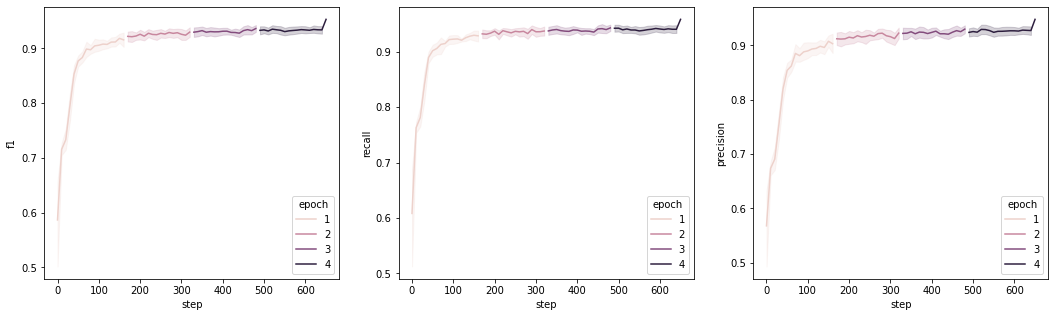

In [14]:
fig, ax = plt.subplots(ncols=3, figsize=(18,5))
seaborn.lineplot(data=eval_history, x='step', y='f1', hue='epoch', ax=ax[0])
seaborn.lineplot(data=eval_history, x='step', y='recall', hue='epoch', ax=ax[1])
seaborn.lineplot(data=eval_history, x='step', y='precision', hue='epoch', ax=ax[2])

In [22]:
# micro-averaged scores
test_scores.round(2)

,fold,f1,precision,recall
0,0,0.94,0.93,0.95
1,1,0.92,0.90,0.93
2,2,0.94,0.93,0.95
3,3,0.94,0.93,0.95
4,4,0.92,0.91,0.93
5,5,0.94,0.94,0.95
6,6,0.93,0.93,0.93
7,7,0.91,0.91,0.92
8,8,0.92,0.91,0.93
9,9,0.92,0.91,0.93


In [17]:
from sklearn.metrics import f1_score, precision_score, recall_score

In [31]:
# B-NotNegated, B-Negated
labmap = {'B-NotNegated': False, 'B-Negated': True, 'I-NotNegated': False, 'I-Negated': True}

manual_scores = []
confusion_matrix = []
for i in range(len(predlist)):
    # accuracy over all documents, flattened
    _predlist = [(labmap[t], 'B' if 'B-' in t else 'I') for l in predlist[i]['prediction'] for t in l if len(l)>0]
    _truthlist = [(labmap[t], 'B' if 'B-' in t else 'I') for l in predlist[i]['truth'] for t in l if len(l)>0]

    tr_c = []
    pr_c = []
    tr_r = []
    pr_r = []

    b_truth = []
    b_pred = []
    for _t,_p in zip(_truthlist, _predlist):
        if _t[1]==_p[1]=='B':
            tr_c.append(_t[0])
            pr_c.append(_p[0])
        tr_r.append(_t[0])
        pr_r.append(_p[0])

        b_truth.append(_t[1]=='B')
        b_pred.append(_p[1]=='B')

    tr_c, pr_c, tr_r, pr_r = np.array(tr_c), np.array(pr_c), np.array(tr_r), np.array(pr_r)
    b_truth, b_pred = np.array(b_truth), np.array(b_pred)

    TN_c = np.sum((pr_c==tr_c) & (pr_c==False))
    TP_c = np.sum((pr_c==tr_c) & (pr_c==True))
    FP_c = np.sum((pr_c!=tr_c) & (pr_c==True))
    FN_c = np.sum((pr_c!=tr_c) & (pr_c==False))

    TN_r = np.sum((pr_r==tr_r) & (pr_r==False))
    TP_r = np.sum((pr_r==tr_r) & (pr_r==True))
    FP_r = np.sum((pr_r!=tr_r) & (pr_r==True))
    FN_r = np.sum((pr_r!=tr_r) & (pr_r==False))

    TN_b = np.sum((b_pred==b_truth) & (b_pred==False))
    TP_b = np.sum((b_pred==b_truth) & (b_pred==True))
    FP_b = np.sum((b_pred!=b_truth) & (b_pred==True))
    FN_b = np.sum((b_pred!=b_truth) & (b_pred==False))


    # micro
    f1 = f1_score(tr_r, pr_r, average='micro')
    precision = precision_score(tr_r, pr_r, average='micro')
    recall = recall_score(tr_r, pr_r, average='micro')
    manual_scores.append({'list': 'raw', 
                          'fold': i, 
                          'focus': 'micro', 
                          'f1': f1, 
                          'precision': precision, 
                          'recall': recall})

    # macro
    f1 = f1_score(tr_r, pr_r, average='macro')
    precision = precision_score(tr_r, pr_r, average='macro')
    recall = recall_score(tr_r, pr_r, average='macro')
    manual_scores.append({'list': 'raw', 
                          'fold': i, 
                          'focus': 'macro', 
                          'f1': f1, 
                          'precision': precision, 
                          'recall': recall})

    # Negated
    f1 = f1_score(tr_r, pr_r)
    precision = precision_score(tr_r, pr_r)
    recall = recall_score(tr_r, pr_r)
    manual_scores.append({'list': 'raw', 
                          'fold': i, 
                          'focus': 'negated', 
                          'f1': f1, 
                          'precision': precision, 
                          'recall': recall})

    # NotNegated
    f1 = f1_score(~tr_r, ~pr_r)
    precision = precision_score(~tr_r, ~pr_r)
    recall = recall_score(~tr_r, ~pr_r)
    manual_scores.append({'list': 'raw',
                          'fold': i,
                          'focus': 'notnegated', 
                          'f1': f1,
                          'precision': precision,
                          'recall': recall})
    
    confusion_matrix.append({'list': 'raw', 'fold': i, 'TN': TN_r, 'TP': TP_r, 'FN': FN_r, 'FP': FP_r})    
    ######################################
    # micro
    f1 = f1_score(tr_c, pr_c, average='micro')
    precision = precision_score(tr_c, pr_c, average='micro')
    recall = recall_score(tr_c, pr_c, average='micro')
    manual_scores.append({'list': 'clean', 
                          'fold': i, 
                          'focus': 'micro', 
                          'f1': f1, 
                          'precision': precision, 
                          'recall': recall})

    # macro
    f1 = f1_score(tr_c, pr_c, average='macro')
    precision = precision_score(tr_c, pr_c, average='macro')
    recall = recall_score(tr_c, pr_c, average='macro')
    manual_scores.append({'list': 'clean', 
                          'fold': i, 
                          'focus': 'macro', 
                          'f1': f1, 
                          'precision': precision, 
                          'recall': recall})

    # Negated
    f1 = f1_score(tr_c, pr_c)
    precision = precision_score(tr_c, pr_c)
    recall = recall_score(tr_c, pr_c)
    manual_scores.append({'list': 'clean', 
                          'fold': i, 
                          'focus': 'negated', 
                          'f1': f1, 
                          'precision': precision, 
                          'recall': recall})

    # NotNegated
    f1 = f1_score(~tr_c, ~pr_c)
    precision = precision_score(~tr_c, ~pr_c)
    recall = recall_score(~tr_c, ~pr_c)
    manual_scores.append({'list': 'clean',
                          'fold': i,
                          'focus': 'notnegated', 
                          'f1': f1,
                          'precision': precision,
                          'recall': recall})
    
    confusion_matrix.append({'list': 'clean', 'fold': i, 'TN': TN_c, 'TP': TP_c, 'FN': FN_c, 'FP': FP_c})    
    ######################################
    # micro
    f1 = f1_score(b_truth, b_pred, average='micro')
    precision = precision_score(b_truth, b_pred, average='micro')
    recall = recall_score(b_truth, b_pred, average='micro')
    manual_scores.append({'list': 'B_I', 
                          'fold': i, 
                          'focus': 'micro', 
                          'f1': f1, 
                          'precision': precision, 
                          'recall': recall})

    # macro
    f1 = f1_score(b_truth, b_pred, average='macro')
    precision = precision_score(b_truth, b_pred, average='macro')
    recall = recall_score(b_truth, b_pred, average='macro')
    manual_scores.append({'list': 'B_I', 
                          'fold': i, 
                          'focus': 'macro', 
                          'f1': f1, 
                          'precision': precision, 
                          'recall': recall})

    # Negated
    f1 = f1_score(b_truth, b_pred)
    precision = precision_score(b_truth, b_pred)
    recall = recall_score(b_truth, b_pred)
    manual_scores.append({'list': 'B_I', 
                          'fold': i, 
                          'focus': 'negated', 
                          'f1': f1, 
                          'precision': precision, 
                          'recall': recall})

    # NotNegated
    f1 = f1_score(~b_truth, ~b_pred)
    precision = precision_score(~b_truth, ~b_pred)
    recall = recall_score(~b_truth, ~b_pred)
    manual_scores.append({'list': 'B_I',
                          'fold': i,
                          'focus': 'notnegated', 
                          'f1': f1,
                          'precision': precision,
                          'recall': recall})
    
    confusion_matrix.append({'list': 'B_I', 'fold': i, 'TN': TN_b, 'TP': TP_b, 'FN': FN_b, 'FP': FP_b})    
    
manual_scores_df = pd.DataFrame(data=manual_scores)
confusion_matrix_df = pd.DataFrame(data=confusion_matrix)

In [30]:
manual_scores_df.groupby(['list', 'focus']).mean()

fold        f1  precision    recall
list  focus                                          
B_I   macro        4.5  0.897301   0.903875  0.891532
      micro        4.5  0.958689   0.958689  0.958689
      negated      4.5  0.976669   0.974505  0.978865
      notnegated   4.5  0.817933   0.833245  0.804199
clean macro        4.5  0.955152   0.964960  0.946939
      micro        4.5  0.979019   0.979019  0.979019
      negated      4.5  0.922474   0.945850  0.902200
      notnegated   4.5  0.987831   0.984070  0.991679
raw   macro        4.5  0.952391   0.962784  0.943883
      micro        4.5  0.978789   0.978789  0.978789
      negated      4.5  0.916982   0.941558  0.896083
      notnegated   4.5  0.987800   0.984010  0.991683

In [33]:
Texts

Id
DL1112            Patient kan zich geen trauma herinneren .
DL1113    Patient werd gezien op onze polikliniek in ver...
DL1114    De bevalling geschiedde in stuitligging . Echo...
DL1115    Opname indikatie : Coxarthrosis duplex . Post ...
DL1116    Luisa is bij ons bekend met een dysplasie van ...
                                ...                        
SP2115    Conclusie na ond : lijkt op een letsel van de ...
SP2116    De klachten van patiente kunnen goed passen bi...
SP2117    Geachte collega , Bovengenoemde patiï¿½nt zag ...
SP2120                       C / Rectaal bloedverlies obv .
SP2122    Verhoogde bloeddruk 1e meting : 140 / 95 2e me...
Name: Word, Length: 3230, dtype: object

In [20]:
Texts['DL1174']

'Anamnese : Name # heeft sedert drie jaar niet progressieve pijnklachten ter hoogte van de rechter knie , zonder voorafgaand trauma . Geen atrofie of hydrops . 03 - 01 - 1996 : Geen ossale afwijkingen , met name geen aanwijzingen voor een osteochondritis dissecans . Conclusie : Lang bestaande knieklachten rechts op basis van retropatellaire chondropathie rechts .'

537